In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
import json
import os
import random
import io

In [2]:
X = []
all_events = []
masks = []
X_id = []

def get_signal(filename):
    with open(filename, 'r') as f:
        return json.load(f)[0]


def get_events(filename):
    with open(filename, 'rb') as f:
        events = json.load(f)
    events = list(filter(lambda x: x["type"] == 1, events))
    events = list(filter(lambda x: x["data"]["type"] >= 5, events))
    return events

def x_corrected(X, masks, X_id):
    x_8951 = []
    mask_8951 = []
    x_116615 = []
    mask_116615 = []
    x_116909 = []
    mask_116909 = []
    for i in range(len(X_id)):
        
        if X_id[i] == "17470_signal.json":
            X[i] = X[i][:6300000]
            masks[i] = masks[i][:6300000]
            
        elif X_id[i] == "116615_signal.json":
            x_116615.append(X[i][2513218:4323131])
            mask_116615.append(masks[i][2513218:4323131])
            
            X[i] = X[i][:1009860]
            masks[i] = masks[i][:1009860]
            
        elif X_id[i] == "116909_signal.json":
            
            x_116909.append(X[i][7163202:8291909])
            mask_116909.append(masks[i][7163202:8291909])
            
            X[i] = X[i][:4427637]
            masks[i] = masks[i][:4427637]
            
        elif X_id[i] == "20464_signal.json":
            X[i] = X[i][1797672:4221158]
            masks[i] = masks[i][1797672:4221158]
            
        elif X_id[i] == "118552_signal.json":
            X[i] = X[i][3878216:4750764]
            masks[i] = masks[i][3878216:4750764]
            
        elif X_id[i] == "118651_signal.json":
            X[i] = X[i][28118412:29268580]
            masks[i] = masks[i][28118412:29268580]

        elif X_id[i] == "118548_signal.json":
            X[i] = X[i][758756:1412460]
            masks[i] = masks[i][758756:1412460]
        
        elif X_id[i] == "118547_signal.json":
            X[i] = X[i][10402460:12956676]
            masks[i] = masks[i][10402460:12956676]    
            
        elif X_id[i] == "8951_signal.json":

            x_8951.append(X[i][11101472:17100332])
            x_8951.append(X[i][3875159:4217497])
            mask_8951.append(masks[i][11101472:17100332])
            mask_8951.append(masks[i][3875159:4217497])
            
            X[i] = X[i][176579:1650787]
            masks[i] = masks[i][176579:1650787]
            
    X = X + x_8951 + x_116909 + x_116615
    masks = masks + mask_8951 + mask_116909 + mask_116615
    X_id = X_id + 2 * ['8951_signal.json'] + ['116909_signal.json'] + ['116615_signal.json']
        
    return X, masks, X_id


directory = 'ecg/'
for filename in sorted(os.listdir(directory)):
    path = directory + "/" + filename
    if "signal" in filename:
        X.append(get_signal(path))
        X_id.append(filename)
    if "events" in filename:
        all_events.append(get_events(path))
        
for signal, events in zip(X, all_events):
    mask = np.zeros(len(signal), dtype=np.int8)
    for event in events:
        m = event["data"]
        mask[m["begin"]:m["end"]] = m["type"] - 4
    masks.append(mask)
    
X, masks, X_id = x_corrected(X,masks, X_id)

for i in range(len(X)):
    X[i] = np.array(X[i]) * 0.001
    
X = np.array(X, dtype=object)
masks = np.array(masks, dtype=object)

In [3]:
X_id

['116615_signal.json',
 '116621_signal.json',
 '116909_signal.json',
 '117310_signal.json',
 '117311_signal.json',
 '117312_signal.json',
 '117316_signal.json',
 '117460_signal.json',
 '117461_signal.json',
 '117472_signal.json',
 '117473_signal.json',
 '117542_signal.json',
 '118547_signal.json',
 '118548_signal.json',
 '118552_signal.json',
 '118651_signal.json',
 '17464_signal.json',
 '17470_signal.json',
 '17554_signal.json',
 '17555_signal.json',
 '20464_signal.json',
 '8951_signal.json',
 '8951_signal.json',
 '8951_signal.json',
 '116909_signal.json',
 '116615_signal.json']

In [4]:
sample_rate = 500

In [5]:
# Вспомогательные функции, превращающие маску в сегментацию

v_to_del = {1:'noise', 2:'artefacts'}

def remove_small(signal):
    max_dist = 12
    last_zero = 0
    for i in range(len(signal)):
        if signal[i] == 0:
            if i - last_zero < max_dist:
                signal[last_zero:i] = 0
            last_zero = i

def merge_small(signal):
    max_dist = 100
    lasts = np.full(signal.max() + 1, -(max_dist+1))
    for i in range(len(signal)):
        m = signal[i]
        if i - lasts[m] < max_dist and m > 0:
            signal[lasts[m]:i] = m
        lasts[m] = i

def mask_to_delineation(mask):
    merge_small(mask)
    remove_small(mask)
    delineation = {'noise':[], 'artefacts':[]}
    i = 0
    mask_length = len(mask)
    while i < mask_length:
        v = mask[i]
        if v > 0:
            delineation[v_to_del[v]].append([i, 0])
            while i < mask_length and mask[i] == v:
                delineation[v_to_del[v]][-1][1] = i
                i += 1
            t = delineation[v_to_del[v]][-1]
        i += 1
    return delineation

In [6]:
wave_type_to_color = {
    "artefacts": "yellow",
    "noise": "red"
}

def plot_signal_with_mask(signal, mask):
    plt.figure(figsize=(18, 5))
    plt.title("Сигнал с маской")
    plt.xlabel("Время (сек)")
    plt.ylabel("Амплитуда (мВ)")
    x_axis_values = np.linspace(0, len(signal) / sample_rate, len(signal))
    plt.plot(x_axis_values, signal, linewidth=2, color="black")
    
    delineation = mask_to_delineation(mask)
    for wave_type in ["noise", "artefacts"]:
        color = wave_type_to_color[wave_type]
        for begin, end in delineation[wave_type]:
            begin /= sample_rate
            end /= sample_rate
            plt.axvspan(begin, end, facecolor=color, alpha=0.5)

In [7]:
import torch.nn.functional as F

weights = torch.Tensor([1., 5., 5.])


def get_loss_with_confusion(model, X_batch, y_batch, w):
    logits = model(X_batch)
    logits = logits[:, :, 2000:-2000]
    y_batch = y_batch[:, 2000:-2000]
    w = w[:, 2000:-2000]
    loss = (w * F.cross_entropy(logits, y_batch, weight=weights)).mean()
    
    y_batch = y_batch.data.numpy().reshape(-1)
    logits = logits.data.numpy()
    y_pred = np.argmax(logits, axis=1).reshape(-1)
    return loss, confusion_matrix(y_batch, y_pred, labels=(0, 1, 2))
    

def get_loss(model, X_batch, y_batch, w):
    logits = model(X_batch)
    logits = logits[:, :, 2000:-2000]
    y_batch = y_batch[:, 2000:-2000]
    w = w[:, 2000:-2000]
    return (w * F.cross_entropy(logits, y_batch, weight=weights)).mean()

In [8]:
class UNetConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetConv, self).__init__()
        self._model = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=9, padding=4),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=9, padding=4),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, X):
        return self._model(X)
    
    
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDown, self).__init__()
        self._model = nn.Sequential(
            nn.MaxPool1d(3),
            UNetConv(in_channels, out_channels)
        )
    
    def forward(self, X):
        return self._model(X)
    

class UNetUp(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels):
        super(UNetUp, self).__init__()
        self._up = nn.ConvTranspose1d(in_channels, in_channels, kernel_size=9, stride=3, padding=3)
        self._model = UNetConv(in_channels + in_channels_skip, out_channels)
    
    def forward(self, X_skip, X):
        X = self._up(X)  
        diff = X_skip.size()[2] - X.size()[2]
        X = F.pad(X, (diff // 2, diff - diff // 2))  
        return self._model(torch.cat([X_skip, X], dim=1))

In [9]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        n = 4
        self._input = UNetConv(in_channels, n)
        self._down1 = UNetDown(n, 2*n)
        self._down2 = UNetDown(2*n, 4*n)
        self._down3 = UNetDown(4*n, 8*n)
        self._down4 = UNetDown(8*n, 16*n)
        self._up1 = UNetUp(16*n, 8*n, 8*n)
        self._up2 = UNetUp(8*n, 4*n, 4*n)
        self._up3 = UNetUp(4*n, 2*n, 2*n)
        self._up4 = UNetUp(2*n, n, n)
        self._output = nn.Conv1d(n, num_classes, kernel_size=1)
        
    def forward(self, X):
        x1 = self._input(X)
        x2 = self._down1(x1)
        x3 = self._down2(x2)
        x4 = self._down3(x3)
        x = self._down4(x4)
        x = self._up1(x4, x)
        x = self._up2(x3, x)
        x = self._up3(x2, x)
        x = self._up4(x1, x)
        return self._output(x)

In [10]:
signals_train = np.load("train-test-data/signals_train.npy", allow_pickle=True).tolist()
signals_test = np.load("train-test-data/signals_test.npy", allow_pickle=True).tolist()
masks_train = np.load("train-test-data/masks_train.npy", allow_pickle=True)
masks_test = np.load("train-test-data/masks_test.npy", allow_pickle=True)
id_train = np.load("train-test-data/id_train.npy", allow_pickle=True)
id_test = np.load("train-test-data/id_test.npy", allow_pickle=True)
start_train = np.load("train-test-data/start_train.npy", allow_pickle=True)
start_test = np.load("train-test-data/start_test.npy", allow_pickle=True)

In [11]:
model = UNet(1, 3)

In [4137]:
model.load_state_dict(torch.load("20.04.21/unet"))
model.eval()

UNet(
  (_input): UNetConv(
    (_model): Sequential(
      (0): Conv1d(1, 4, kernel_size=(9,), stride=(1,), padding=(4,))
      (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(4, 4, kernel_size=(9,), stride=(1,), padding=(4,))
      (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (_down1): UNetDown(
    (_model): Sequential(
      (0): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (1): UNetConv(
        (_model): Sequential(
          (0): Conv1d(4, 8, kernel_size=(9,), stride=(1,), padding=(4,))
          (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(8, 8, kernel_size=(9,), stride=(1,), padding=(4,))
          (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
 

In [4257]:
# получение маски по сигналу (сигнал должен быть коротким, иначе переполнение ram)
def get_mask(signal, threshold = 0):
    signal = np.expand_dims(signal, axis=(0, 1))
    signal = torch.FloatTensor(signal)
    mask = model(signal)
    mask[:,1:] += threshold
    mask = mask[0]
    mask = mask.argmax(axis=0)
    return mask.data.numpy().astype(np.int32)

#def get_mask_probs(signal):
#    signal = np.expand_dims(signal, axis=(0, 1))
#    signal = torch.FloatTensor(signal)
#    mask = model(signal)[0]
#    mask = mask.softmax(axis=0)
#    return mask.data.numpy().astype(np.float)
#def get_mask(signal, threshold = 0.75):
#    signal = np.expand_dims(signal, axis=(0, 1))
#    signal = torch.FloatTensor(signal)
#    mask = model(signal)[0]
#    mask = mask.softmax(axis=0)
#    mask[0] = (mask[0] >= threshold).int()
#    mask = mask.argmax(axis=0)
#    return mask.data.numpy().astype(np.int32)

In [4270]:
#ЭКГ может быть очень длинной, поэтому нужна эта функция
def get_full_mask_ecg(signal, threshold):
    mask_full = np.array([], dtype = np.int64)
    index = 0
    begin = 0
    while len(signal) - index >= 400000:
        if index > 0:
            begin = 2500
        mask_full = np.hstack([mask_full, get_mask(signal[index:index+300000], threshold)[begin:-2500]])
        index += 295000
    mask_full = np.hstack([mask_full, get_mask(signal[index:], threshold)[begin:]])
    return mask_full

In [15]:
#посчитаем accuracy в окрестности 1 секунда слева, 1 секунда справа
# истинный класс true_class, предсказание - unet_class

def accuracy_in_vicinity(true_mask, unet_mask, true_class, unet_class):
    r = np.zeros(1001)
    r[:500] = np.linspace(0, 1, 500)
    r[500] = 1
    r[501:] = np.linspace(0, 1, 500)[::-1]
    
    accuracy = []
    index = 0
    
    m = np.full(len(true_mask), 1)
    m[(true_mask == true_class) & (unet_mask == unet_class)] = 0
    
    current_accuracy = (m[:1001] * r).sum()
    accuracy.append(current_accuracy)
    while 1001 + index < len(true_mask):
        index += 1
        accuracy.append((m[index:1001+index] * r).sum())
    return accuracy

In [16]:
#уникальные индексы с наименьшим accuracy по убыванию
def unique_index(mass, offset):
    mass_sort = np.sort(mass)
    ind_sort = np.searchsorted(mass_sort, mass)
    flag = np.array([False for i in range(len(mass))])
    unique = np.array([], dtype = 'int64')
    for i in range(len(mass)):
        if flag[ind_sort[i]] == False:
            left = mass[i] - offset
            right = mass[i] + offset
            unique = np.append(unique, mass[i])
            k = 0
            while ind_sort[i] - k >= 0 and flag[ind_sort[i] - k] == False and mass_sort[ind_sort[i] - k] >= left:
                flag[ind_sort[i] - k] = True
                k += 1
            k = 1
            while ind_sort[i] + k < len(mass) and flag[ind_sort[i] + k] == False and mass_sort[ind_sort[i] + k] <= right:
                flag[ind_sort[i] + k] = True
                k += 1
    return unique

In [17]:
def draw_ecg(signal, mask_true, mask_pred, index, offset):
    plot_signal_with_mask(signal[index - offset:index + offset], mask_true[index - offset: index + offset])
    plot_signal_with_mask(signal[index - offset:index + offset], mask_pred[index - offset: index + offset])

In [1310]:
def get_results(signals, true_masks, unet_masks, true_class, unet_class):
    
    indexed = np.empty(len(signals), dtype = 'object')
    accuracy = np.empty(len(signals), dtype = 'object')
    
    for i in range(len(signals)):
        res = np.array(accuracy_in_vicinity(true_masks[i], unet_masks[i], true_class, unet_class))
        index = np.argsort(res[5000:-5000]) 
        uniq_index = unique_index(index, 1500)
        indexed[i] = uniq_index
        accuracy[i] = res[uniq_index + 5000]
        print(" Выполнено:", "%.2f" % ((i + 1) / len(signals) * 100), "%")
        clear_output(True)
    
    index_signals = []
    id_signals = []
    
    current_ind = np.array([indexed[i][0] for i in range(len(indexed))])
    current_acc = np.array([accuracy[i][0] for i in range(len(accuracy))])
    flags = np.zeros((len(current_ind)), dtype = 'int32')
    
    k = 0
    while(k < 20):
        m = current_acc.argmin()
        id_signals.append(m)
        index_signals.append(current_ind[m])
        flags[m] += 1
        current_ind[m] = indexed[m][flags[m]] 
        current_acc[m] = accuracy[m][flags[m]] 
        k += 1
    
    clear_output(True)
    
    return np.array(index_signals) + 500 + 5000, id_signals

# Проверка на train

In [19]:
len_train = len(signals_train)

In [20]:
print(len_train, "сигналов по 8-12 минут")

183 сигналов по 8-12 минут


In [21]:
# get unet train
unet_train = np.empty(len_train, dtype = 'object')
for i in range(len_train):
    unet_train[i] = get_full_mask_ecg(signals_train[i])
    print(" Выполнено:", "%.2f" % ((i + 1) / len_train * 100), "%")
    clear_output(True)

 Выполнено: 100.00 %


In [739]:
# confusion matrix train
conf_matrix_train = np.zeros((3,3), dtype = 'int64')
for i in range(len_train):
    conf_matrix_train += confusion_matrix(masks_train[i][2500:-2500], unet_train[i][2500:-2500], labels = [0,1,2])
    print(" Выполнено:", "%.2f" % ((i + 1) / len_train * 100), "%")
    clear_output(True)
conf_matrix_train

array([[44232171,    93023,  1361363],
       [   57371,  2452725,    42353],
       [   79593,    25831,  2345570]])

In [22]:
# confusion matrix train
conf_matrix_train = np.zeros((3,3), dtype = 'int64')
for i in range(len_train):
    conf_matrix_train += confusion_matrix(masks_train[i][2500:-2500], unet_train[i][2500:-2500], labels = [0,1,2])
    print(" Выполнено:", "%.2f" % ((i + 1) / len_train * 100), "%")
    clear_output(True)
conf_matrix_train

array([[48612883,   367190,  1530460],
       [    6877,  2271209,    49274],
       [   66314,    40231,  2120562]])

In [23]:
a1,b1, ind, acc = get_results(signals_train, masks_train, unet_train, 2, 0)

KeyboardInterrupt: 

In [263]:
def print_train_ecg(index, offset):
    draw_ecg(signals_train[b1[index]], masks_train[b1[index]], unet_train[b1[index]], a1[index], offset)
    return "https://healing-pebbles.ru/ecg?id="+str(id_train[b1[index]][:-12])+"&begin="+str(start_train[b1[index]] + a1[index] - offset)+"&end="+str(start_train[b1[index]] + a1[index] + offset)

'https://healing-pebbles.ru/ecg?id=17464&begin=1887085&end=1890085'

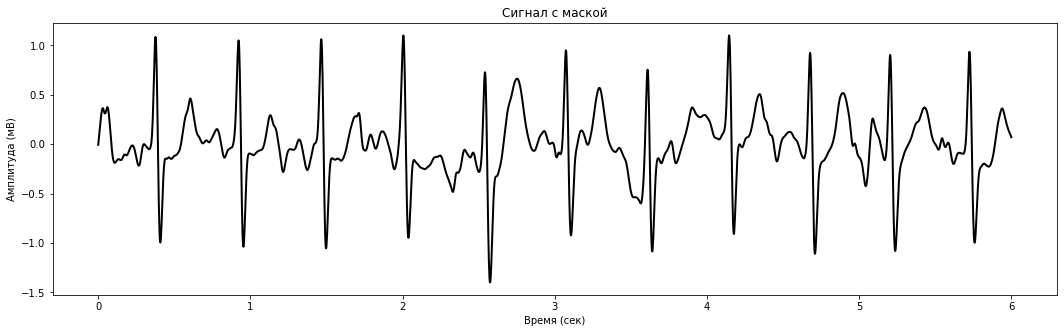

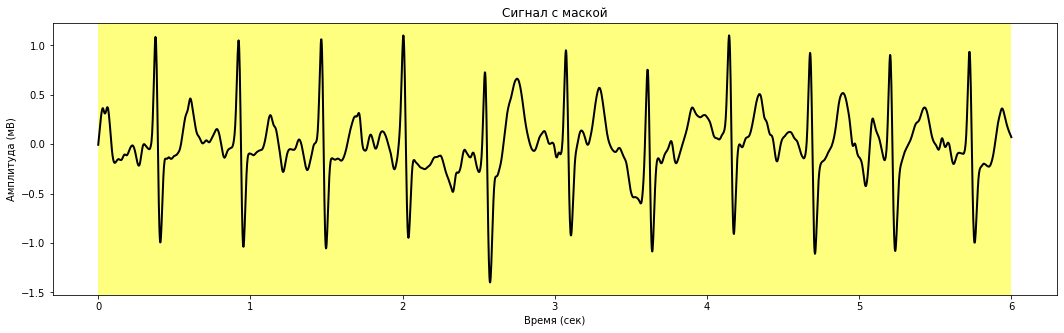

In [531]:
print_train_ecg(0, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=16406541&end=16409541'

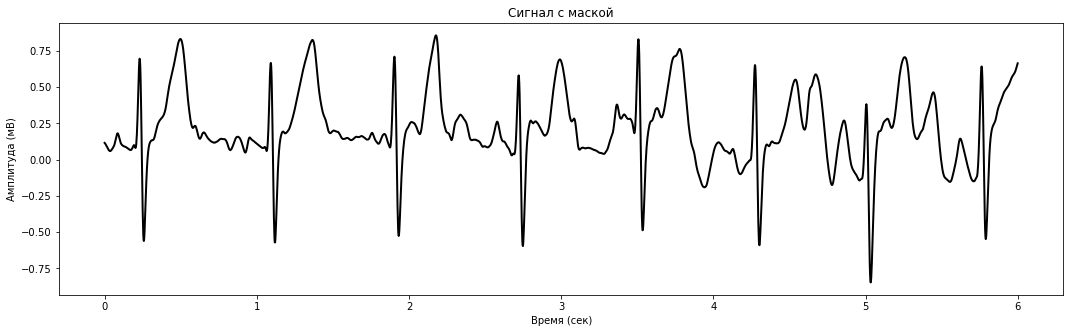

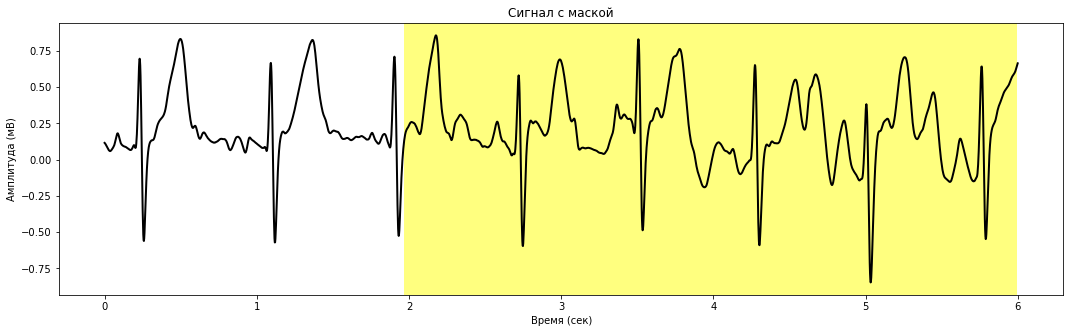

In [532]:
print_train_ecg(1, 1500)

'https://healing-pebbles.ru/ecg?id=117312&begin=1740017&end=1743017'

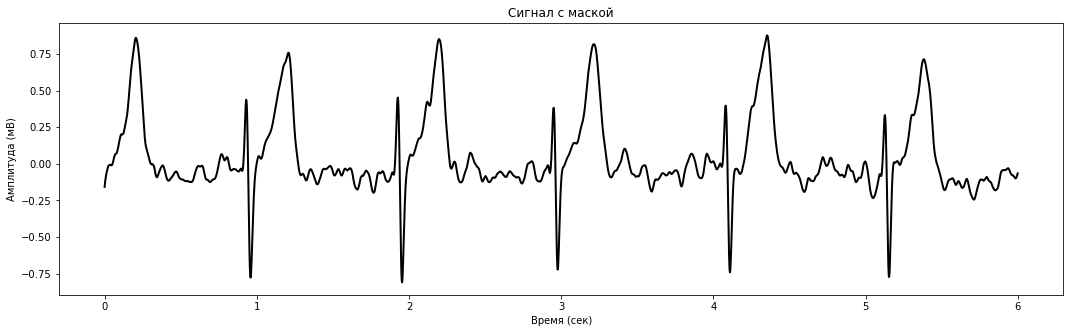

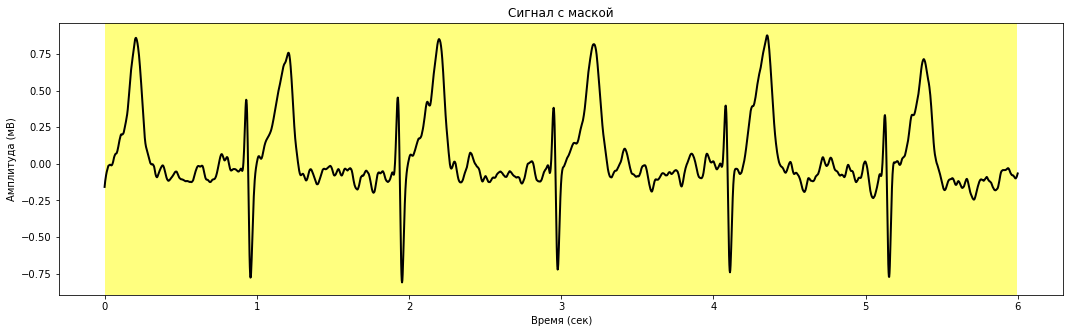

In [533]:
print_train_ecg(2, 1500)

'https://healing-pebbles.ru/ecg?id=17464&begin=1438499&end=1441499'

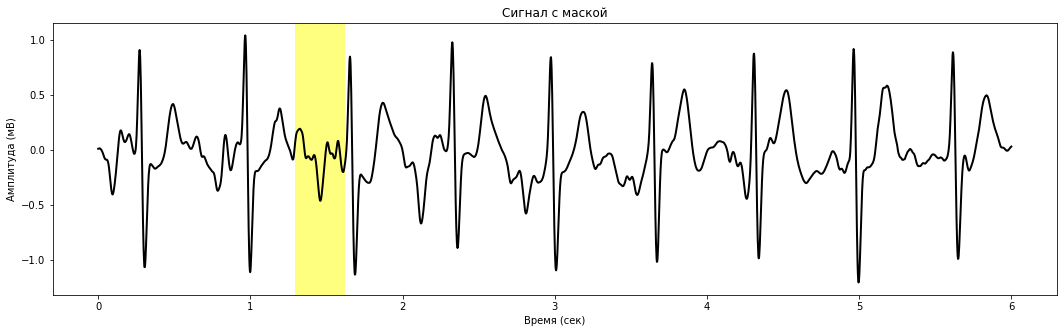

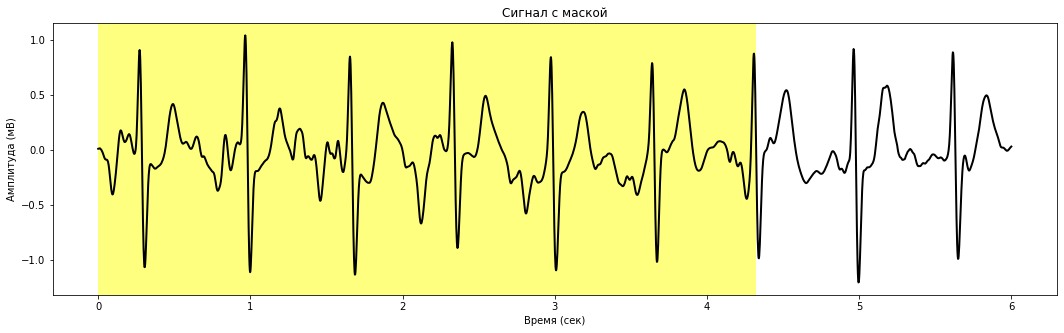

In [534]:
print_train_ecg(3, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=14992999&end=14995999'

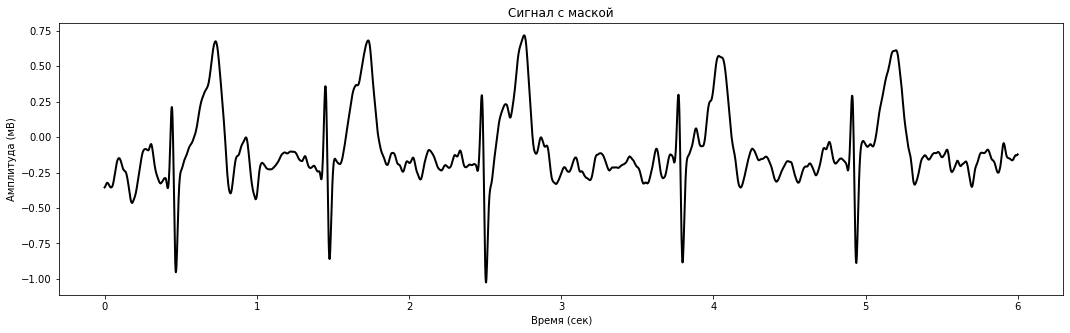

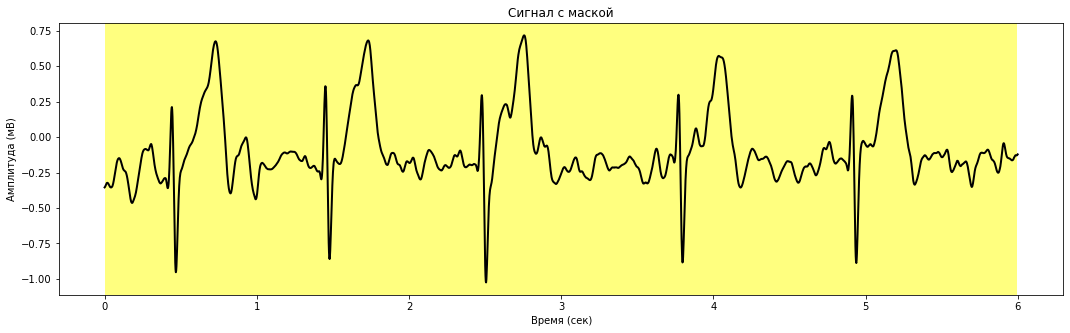

In [535]:
print_train_ecg(4, 1500)

'https://healing-pebbles.ru/ecg?id=17464&begin=900878&end=903878'

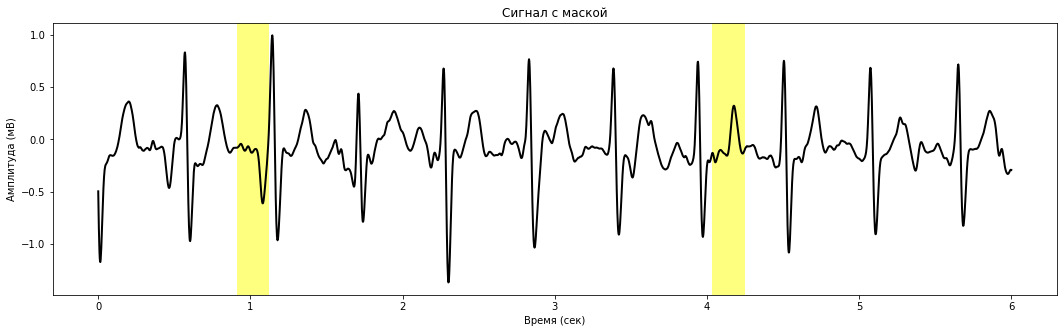

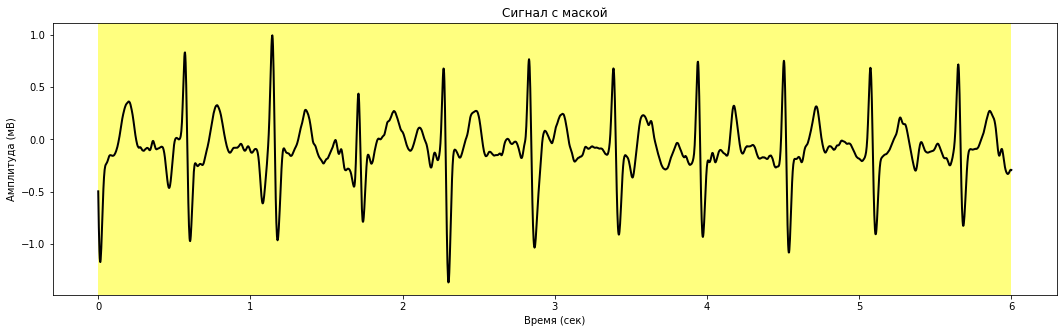

In [536]:
print_train_ecg(5, 1500)

'https://healing-pebbles.ru/ecg?id=17464&begin=930872&end=933872'

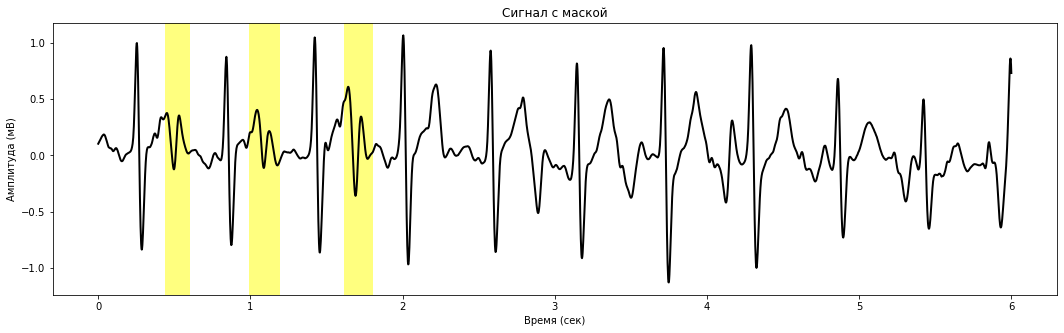

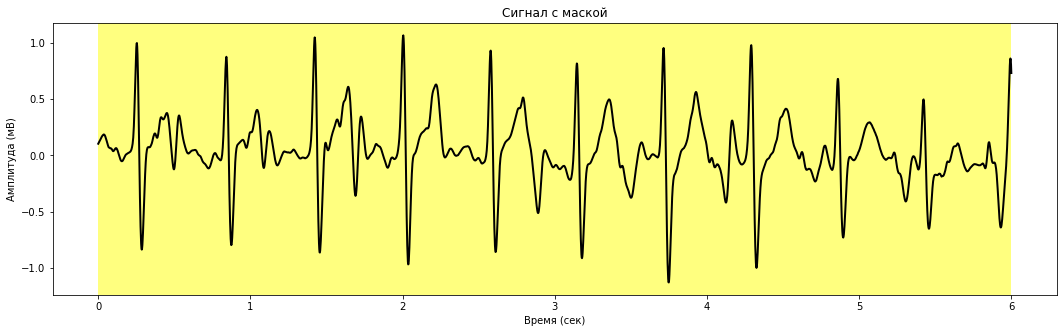

In [537]:
print_train_ecg(6, 1500)

'https://healing-pebbles.ru/ecg?id=116621&begin=1264000&end=1267000'

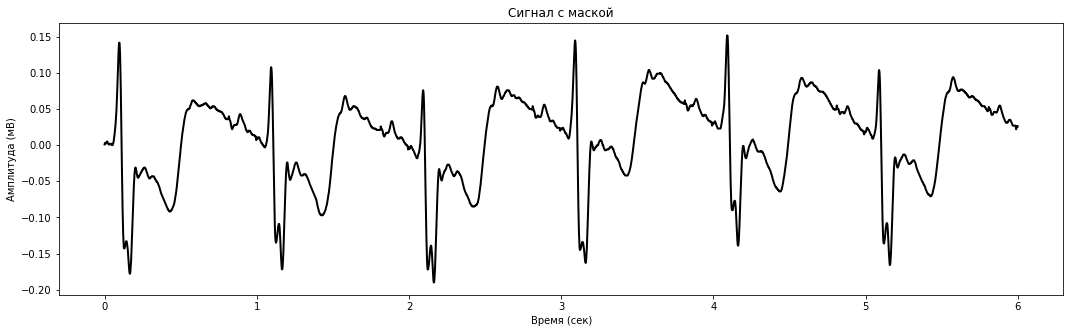

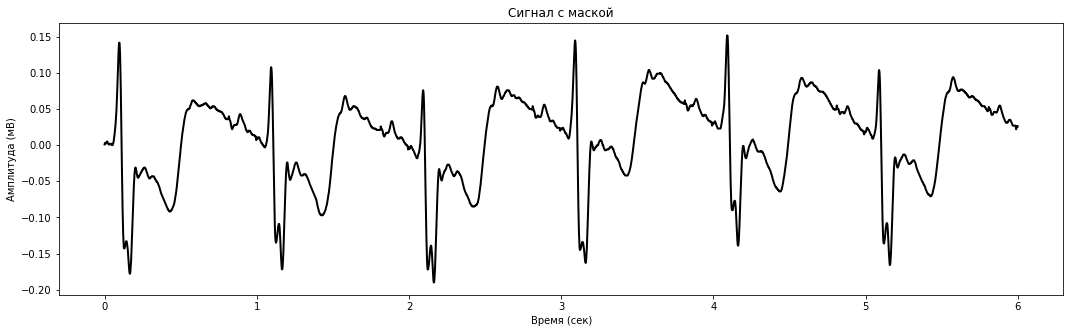

In [538]:
print_train_ecg(7, 1500)

'https://healing-pebbles.ru/ecg?id=116909&begin=2434000&end=2437000'

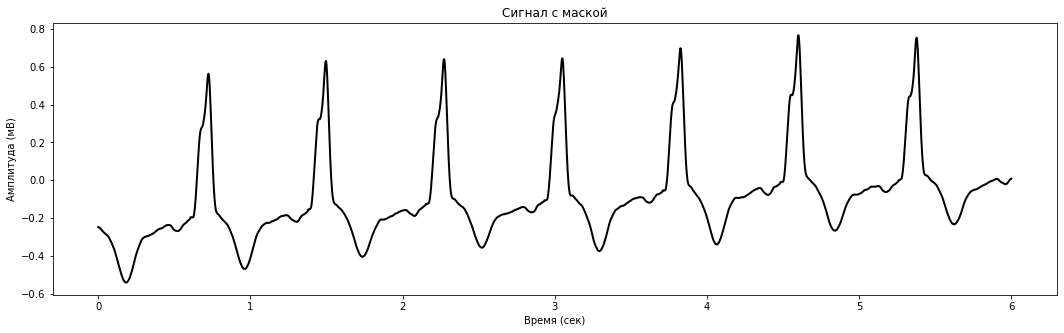

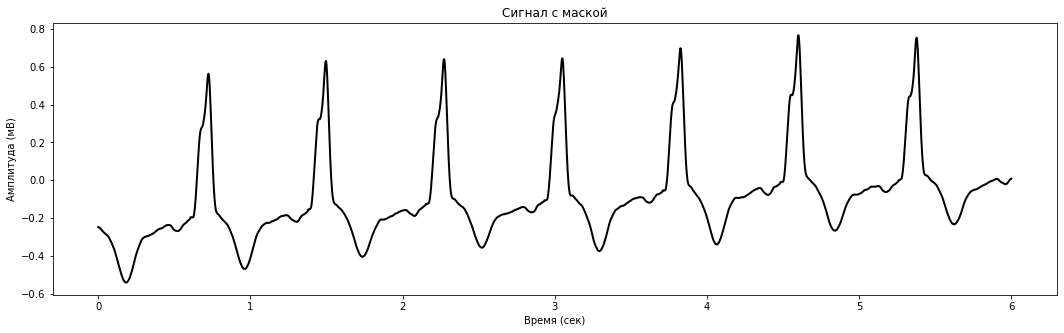

In [539]:
print_train_ecg(8, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=8374000&end=8377000'

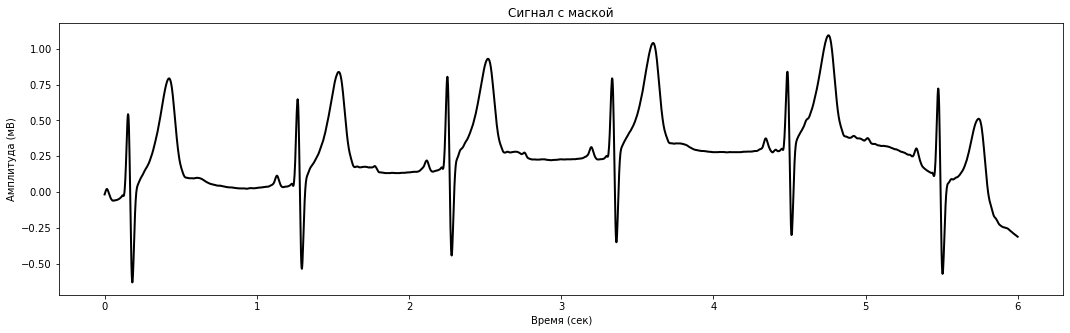

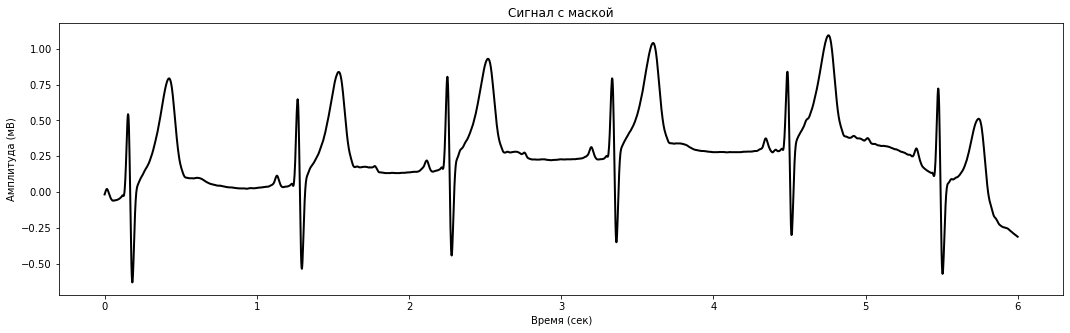

In [540]:
print_train_ecg(9, 1500)

In [290]:
a1,b1 = get_results(signals_train, masks_train, unet_train, 0, 2)

'https://healing-pebbles.ru/ecg?id=17464&begin=870644&end=873644'

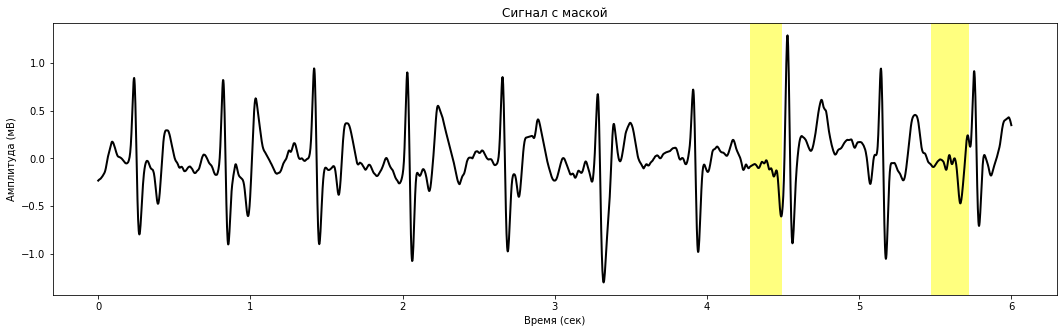

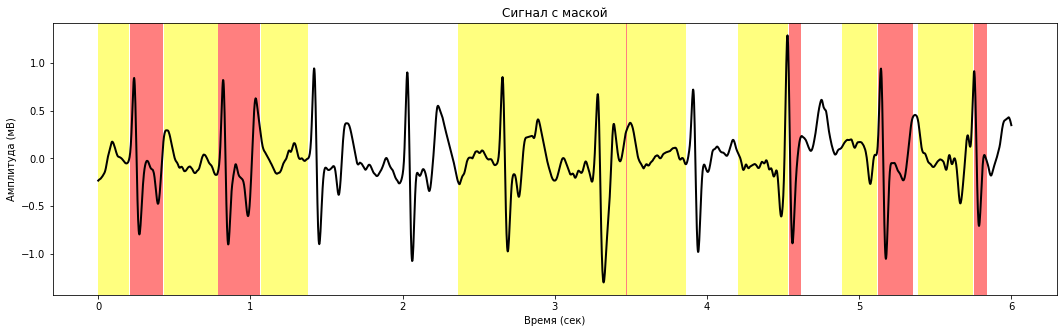

In [291]:
print_train_ecg(0, 1500)

'https://healing-pebbles.ru/ecg?id=117312&begin=4122507&end=4125507'

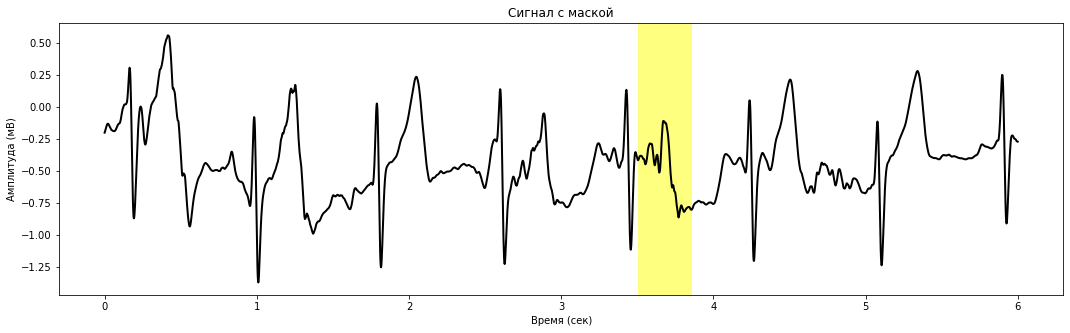

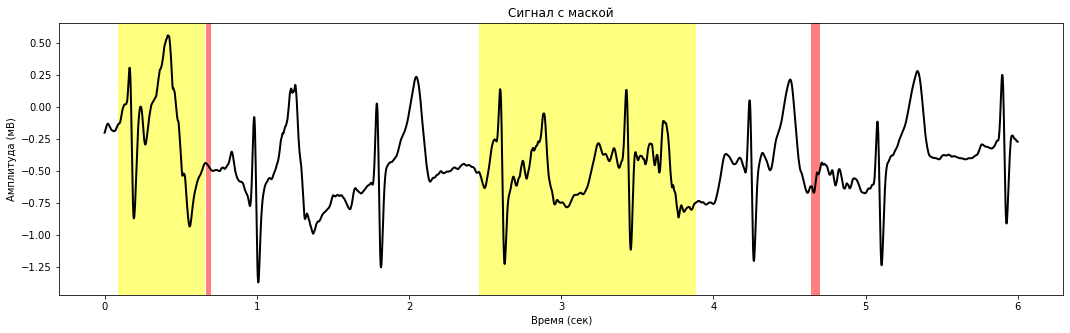

In [292]:
print_train_ecg(1, 1500)

'https://healing-pebbles.ru/ecg?id=117312&begin=1429498&end=1432498'

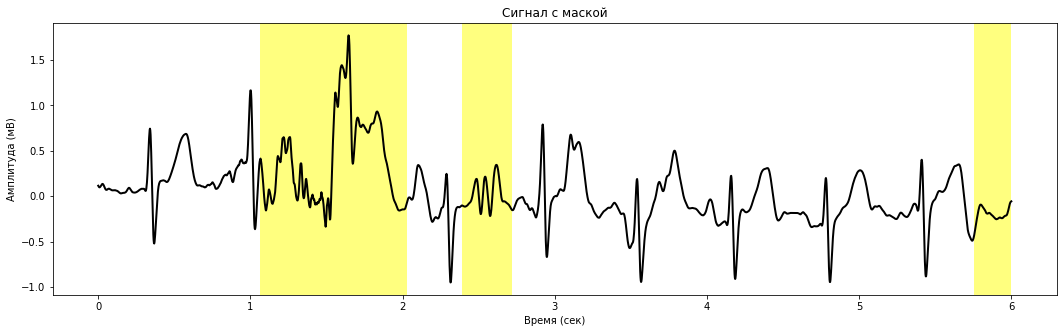

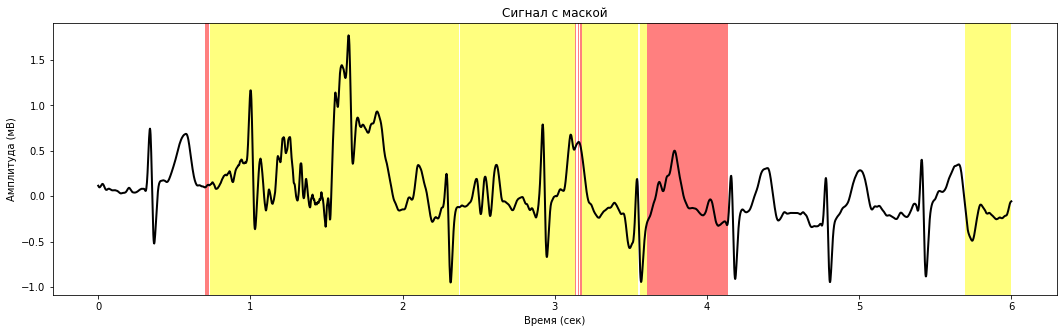

In [293]:
print_train_ecg(2, 1500)

'https://healing-pebbles.ru/ecg?id=17464&begin=925948&end=928948'

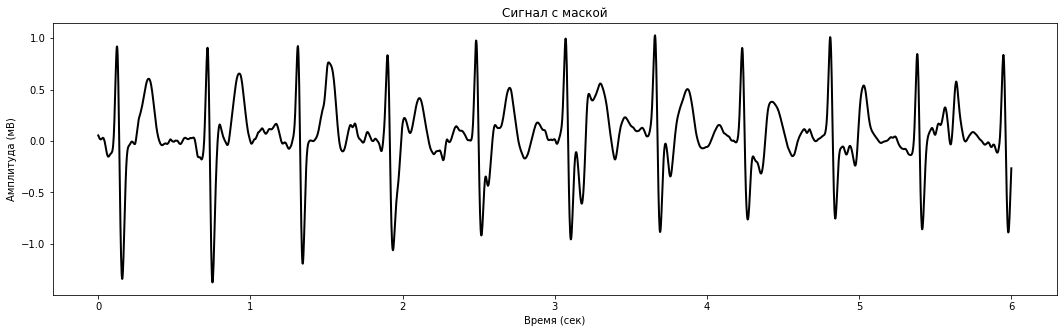

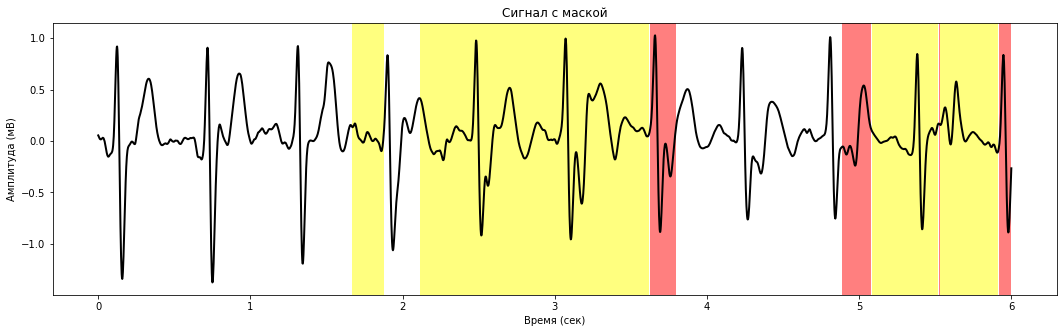

In [294]:
print_train_ecg(3, 1500)

'https://healing-pebbles.ru/ecg?id=17464&begin=895535&end=898535'

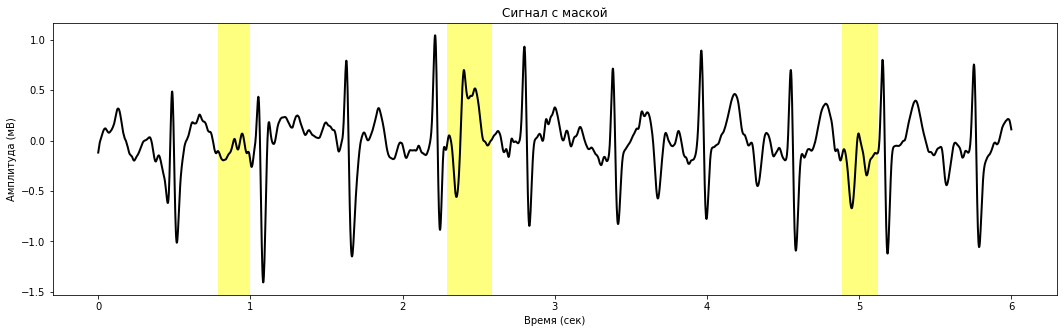

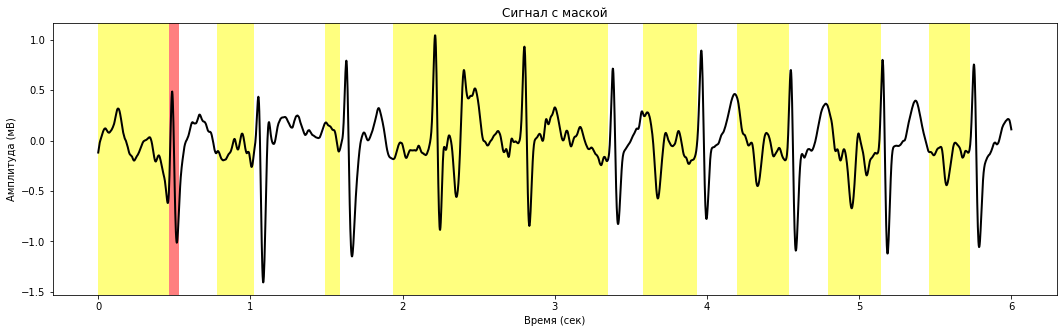

In [295]:
print_train_ecg(4, 1500)

'https://healing-pebbles.ru/ecg?id=17470&begin=3951137&end=3954137'

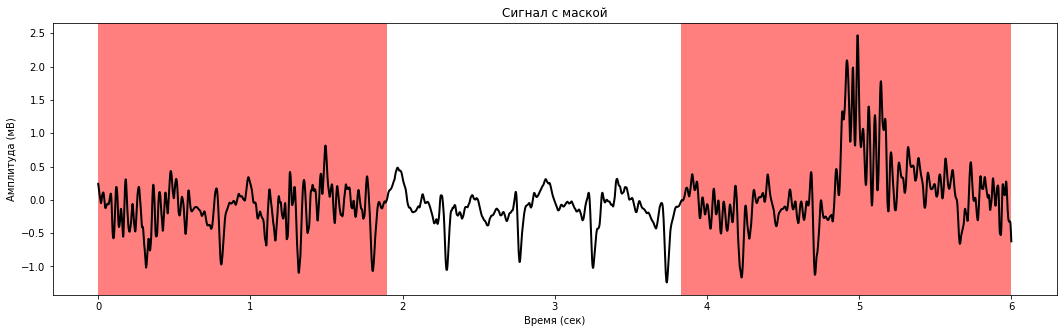

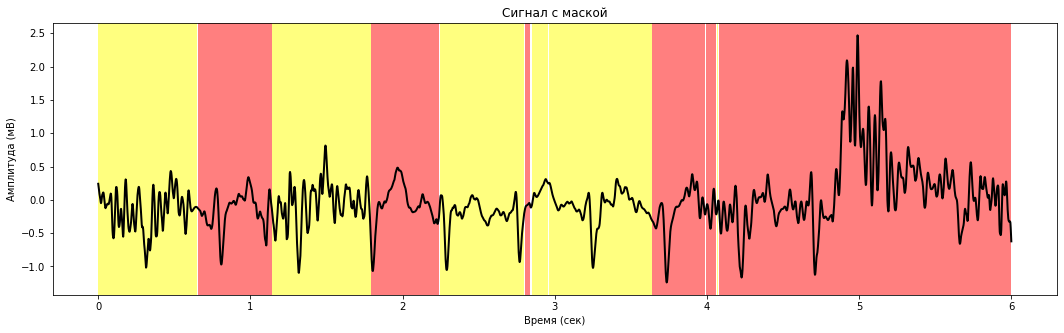

In [296]:
print_train_ecg(5, 1500)

'https://healing-pebbles.ru/ecg?id=17470&begin=3945079&end=3948079'

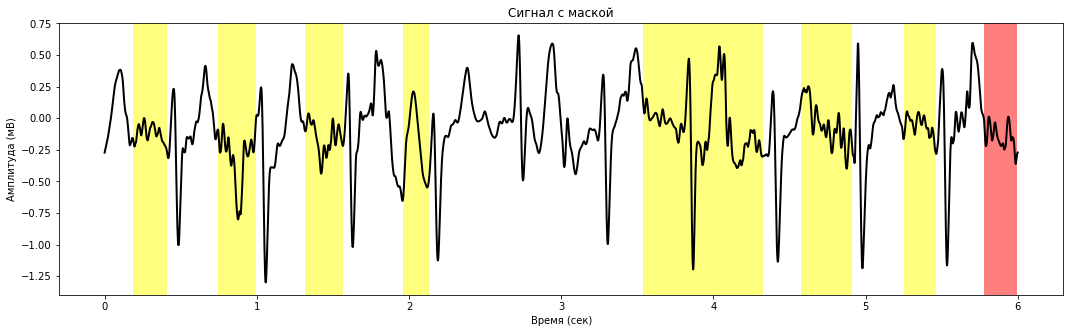

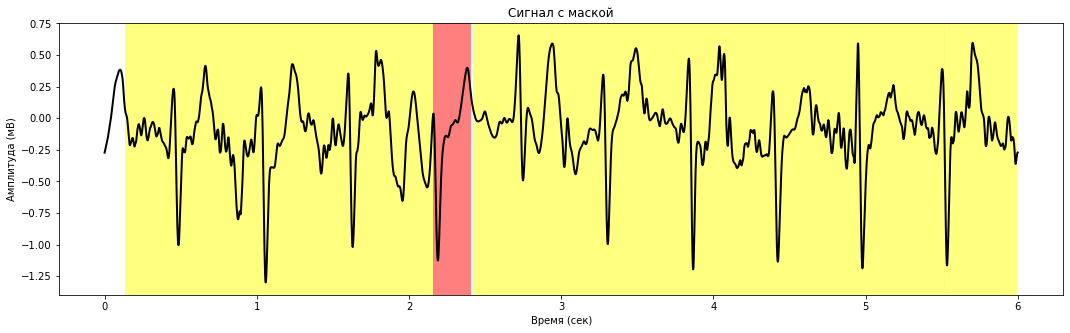

In [297]:
print_train_ecg(6, 1500)

'https://healing-pebbles.ru/ecg?id=17470&begin=302229&end=305229'

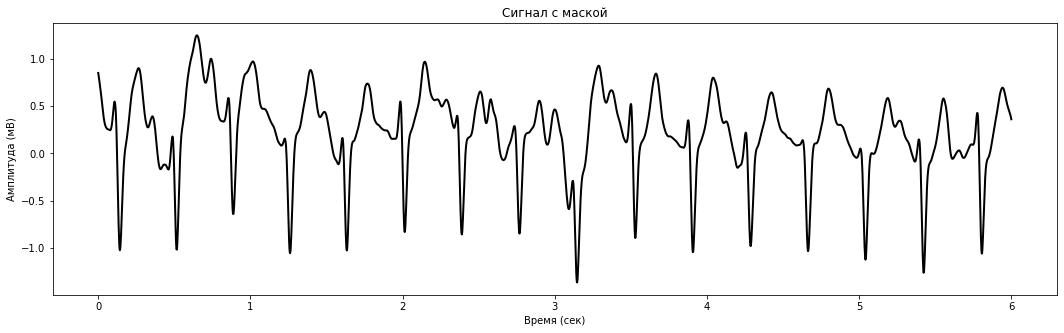

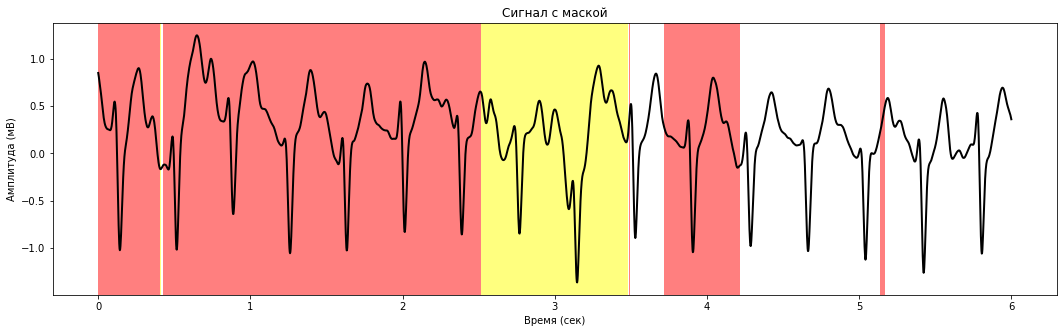

In [298]:
print_train_ecg(7, 1500)

'https://healing-pebbles.ru/ecg?id=117460&begin=1484571&end=1487571'

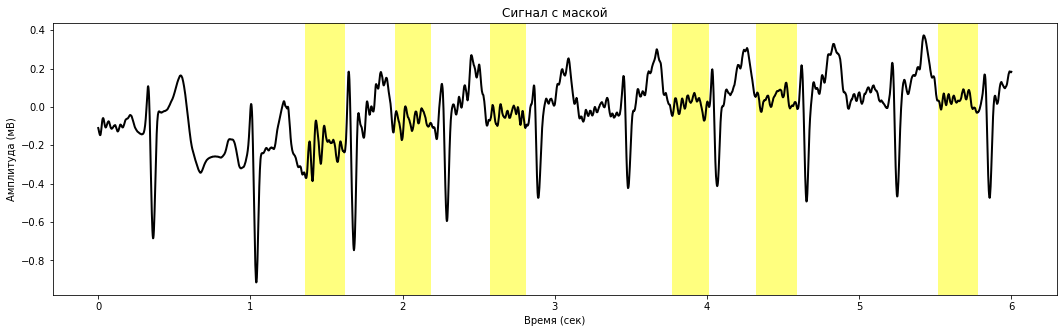

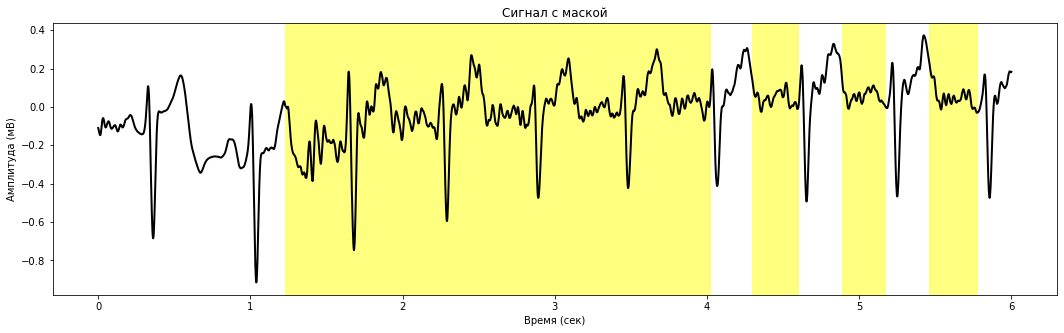

In [299]:
print_train_ecg(8, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=5762123&end=5765123'

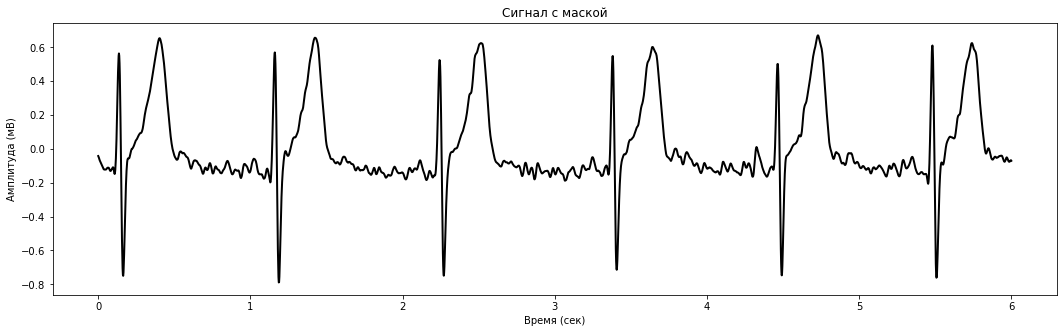

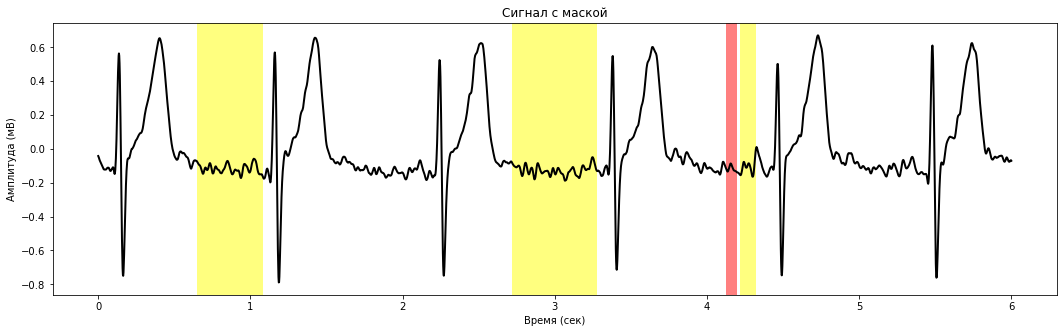

In [300]:
print_train_ecg(9, 1500)

# Проверка на test

In [4263]:
len_test = len(signals_test)

In [4264]:
print(len_test, "сигналов по 8-12 минут")

61 сигналов по 8-12 минут


In [4295]:
threshold = 4.6

In [4296]:
# get unet test
unet_test = np.empty(len_test, dtype = 'object')
for i in range(len_test):
    unet_test[i] = get_full_mask_ecg(signals_test[i], threshold)
    print(" Выполнено:", "%.2f" % ((i + 1) / len_test * 100), "%")
    clear_output(True)

 Выполнено: 100.00 %


In [766]:
# confusion matrix test
conf_matrix_test = np.zeros((3,3), dtype = 'int64')
for i in range(len_test):
    conf_matrix_test += confusion_matrix(masks_test[i][2500:-2500], unet_test[i][2500:-2500], labels = [0,1,2])
    print(" Выполнено:", "%.2f" % ((i + 1) / len_test * 100), "%")
    clear_output(True)
conf_matrix_test

array([[16215318,    14423,   431014],
       [   12593,    90858,    12388],
       [   34020,    12381,   282005]])

In [1244]:
# confusion matrix test
conf_matrix_test = np.zeros((3,3), dtype = 'int64')
for i in range(len_test):
    conf_matrix_test += confusion_matrix(masks_test[i][2500:-2500], unet_test[i][2500:-2500], labels = [0,1,2])
    print(" Выполнено:", "%.2f" % ((i + 1) / len_test * 100), "%")
    clear_output(True)
conf_matrix_test

array([[16023315,    70110,   558199],
       [    3471,   348734,    15474],
       [   38157,    11711,   565829]])

In [4297]:
# confusion matrix test
conf_matrix_test = np.zeros((3,3), dtype = 'int64')
for i in range(len_test):
    conf_matrix_test += confusion_matrix(masks_test[i][2500:-2500], unet_test[i][2500:-2500], labels = [0,1,2])
    print(" Выполнено:", "%.2f" % ((i + 1) / len_test * 100), "%")
    clear_output(True)
conf_matrix_test

array([[13517727,   173399,  2960394],
       [    2931,   353240,    11508],
       [    5580,    18924,   591297]])

In [4299]:
conf_matrix_test[0][1:].sum() / conf_matrix_test[0].sum()

0.18819861490122222

In [4300]:
a2,b2 = get_results(signals_test[0:10], masks_test, unet_test, 0, 2)

In [4301]:
def print_test_ecg(index, offset):
    draw_ecg(signals_test[b2[index]], masks_test[b2[index]], unet_test[b2[index]], a2[index], offset)
    return "https://healing-pebbles.ru/ecg?id="+str(id_test[b2[index]][:-12])+"&begin="+str(start_test[b2[index]] + a2[index] - offset)+"&end="+str(start_test[b2[index]] + a2[index] + offset)

'https://healing-pebbles.ru/ecg?id=117312&begin=4118086&end=4121086'

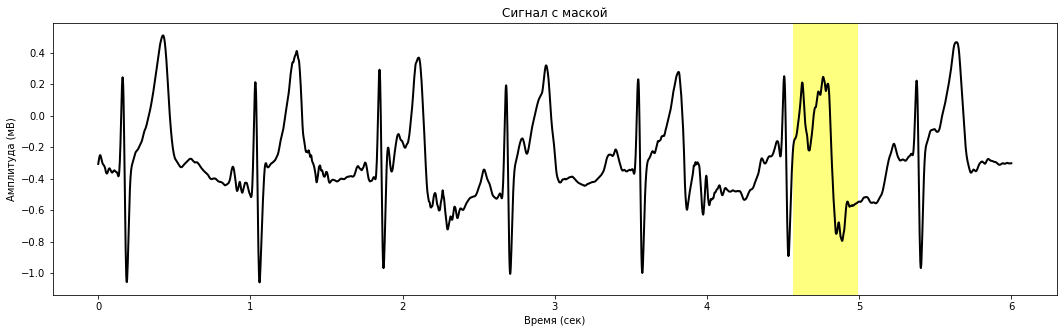

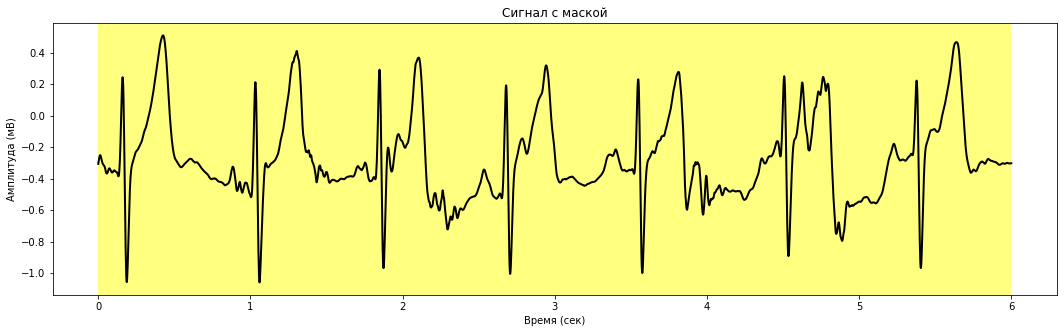

In [4302]:
print_test_ecg(0, 1500)

'https://healing-pebbles.ru/ecg?id=117312&begin=4121331&end=4124331'

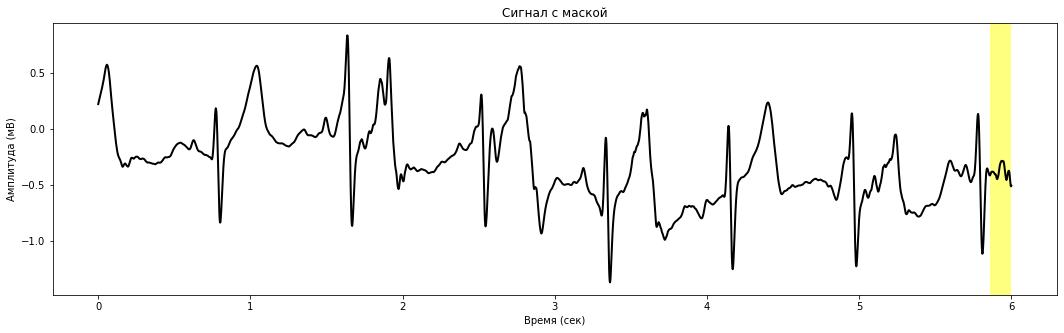

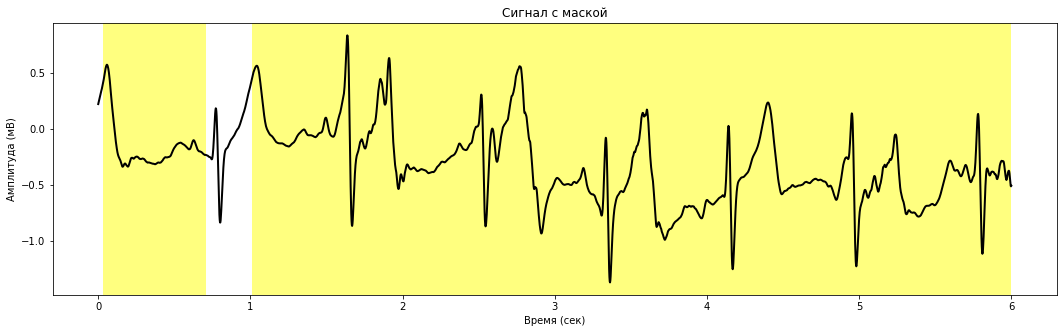

In [4303]:
print_test_ecg(1, 1500)

'https://healing-pebbles.ru/ecg?id=118548&begin=927465&end=930465'

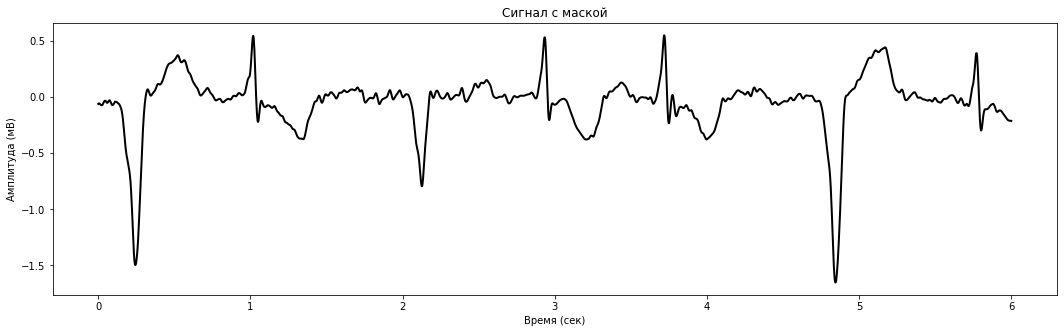

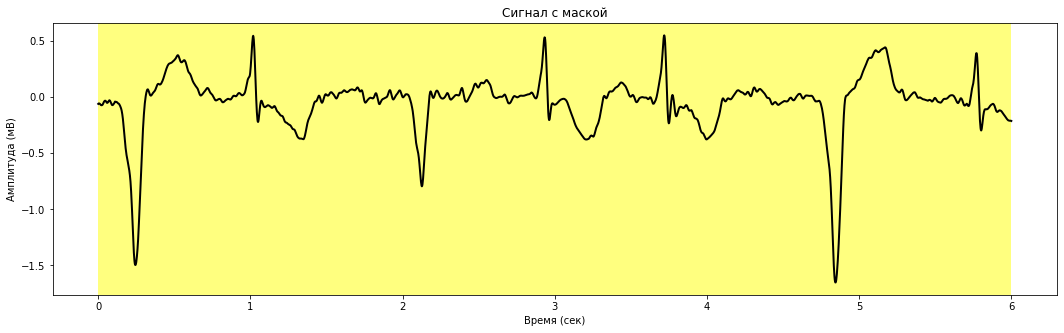

In [4304]:
print_test_ecg(2, 1500)

'https://healing-pebbles.ru/ecg?id=118548&begin=910309&end=913309'

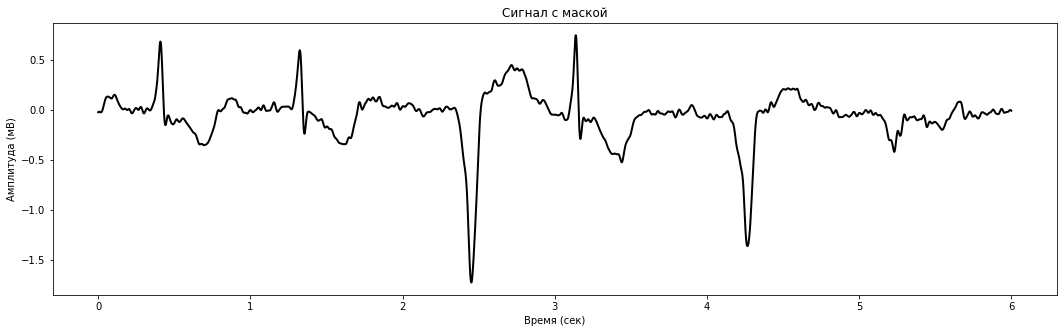

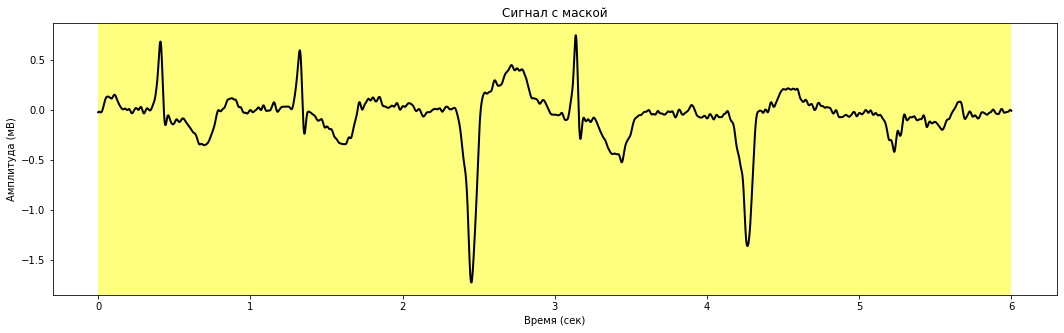

In [4305]:
print_test_ecg(3, 1500)

'https://healing-pebbles.ru/ecg?id=118548&begin=908523&end=911523'

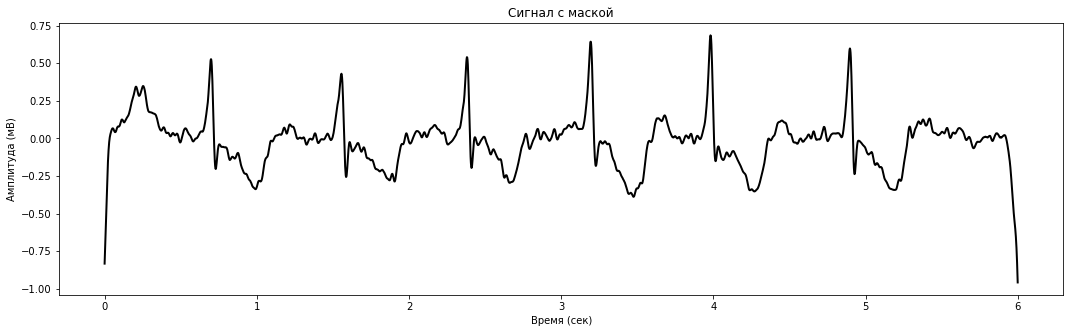

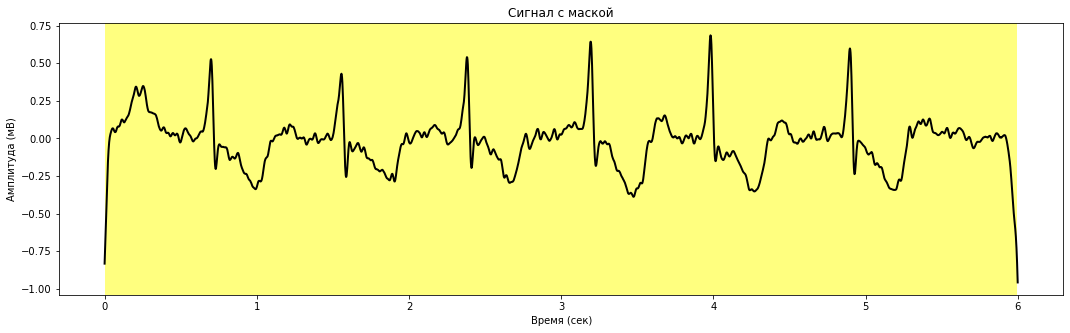

In [4306]:
print_test_ecg(4, 1500)

'https://healing-pebbles.ru/ecg?id=118548&begin=906989&end=909989'

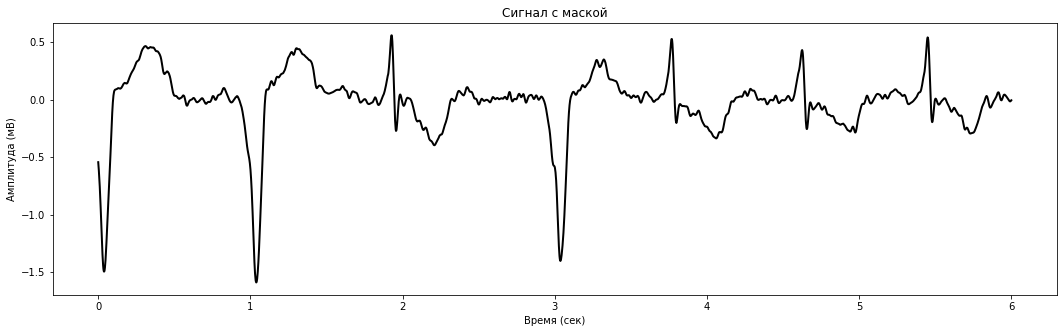

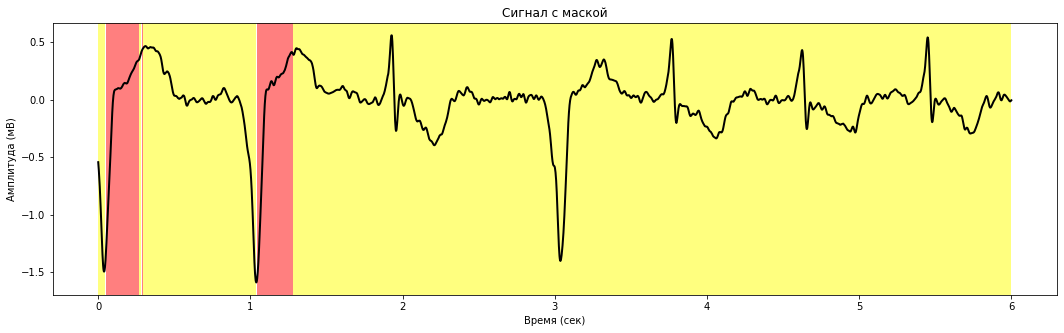

In [4307]:
print_test_ecg(5, 1500)

'https://healing-pebbles.ru/ecg?id=118548&begin=901647&end=904647'

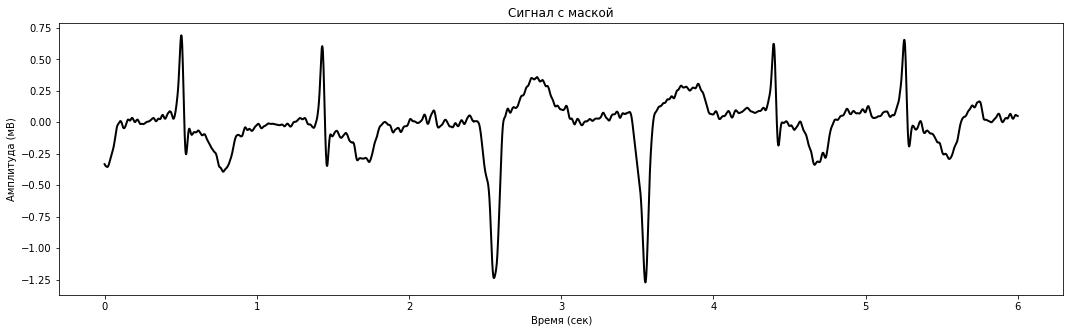

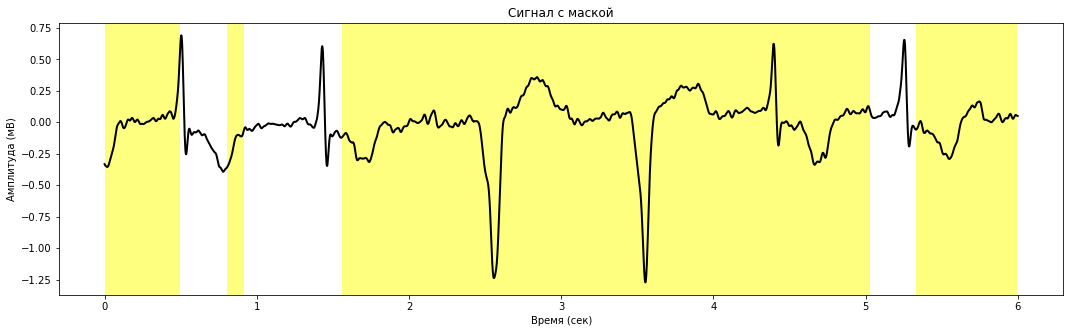

In [4308]:
print_test_ecg(6, 1500)

'https://healing-pebbles.ru/ecg?id=118548&begin=932126&end=935126'

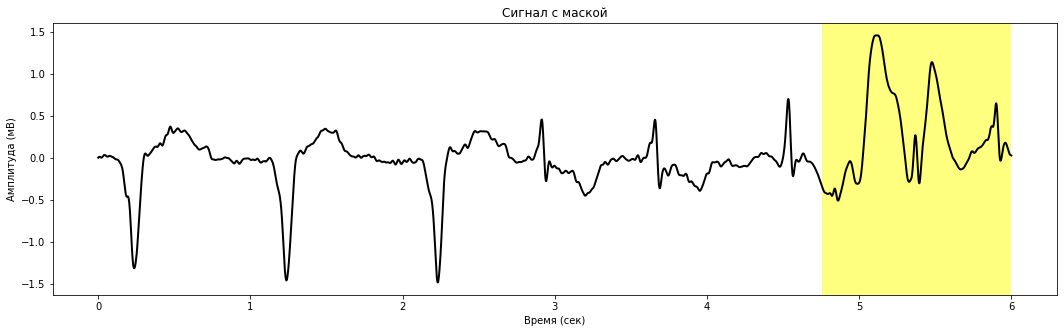

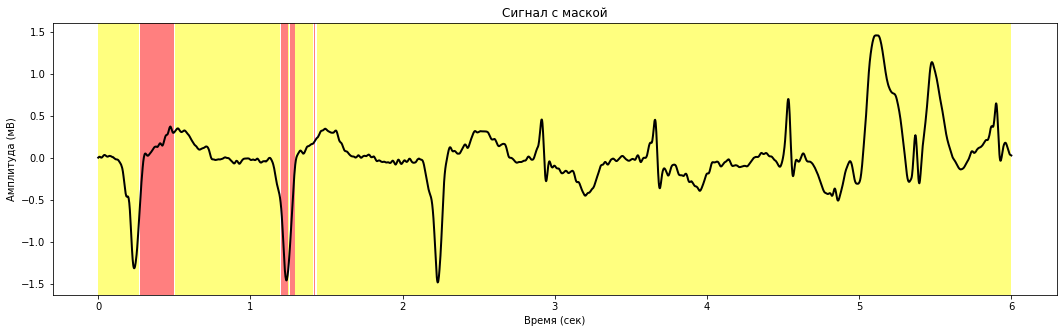

In [4309]:
print_test_ecg(7, 1500)

'https://healing-pebbles.ru/ecg?id=118548&begin=928976&end=931976'

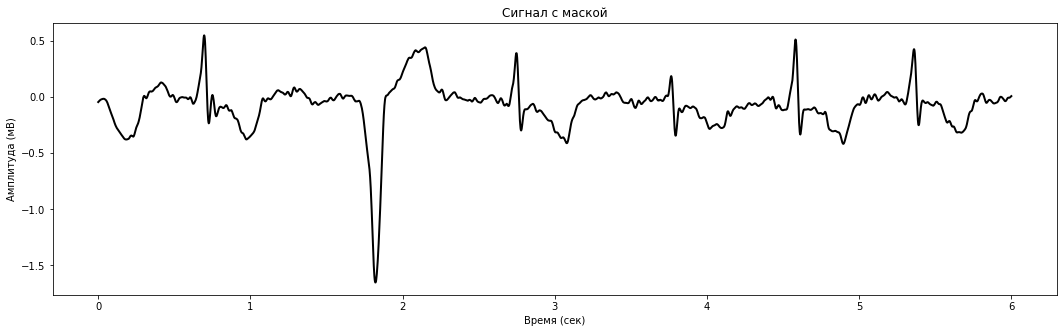

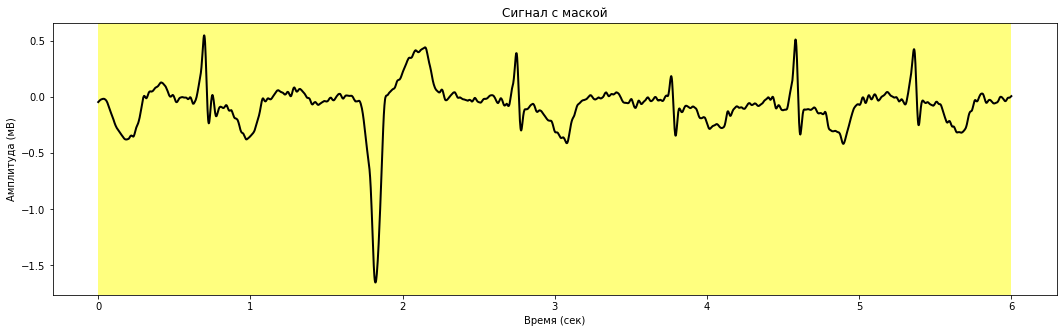

In [4310]:
print_test_ecg(8, 1500)

'https://healing-pebbles.ru/ecg?id=118548&begin=913592&end=916592'

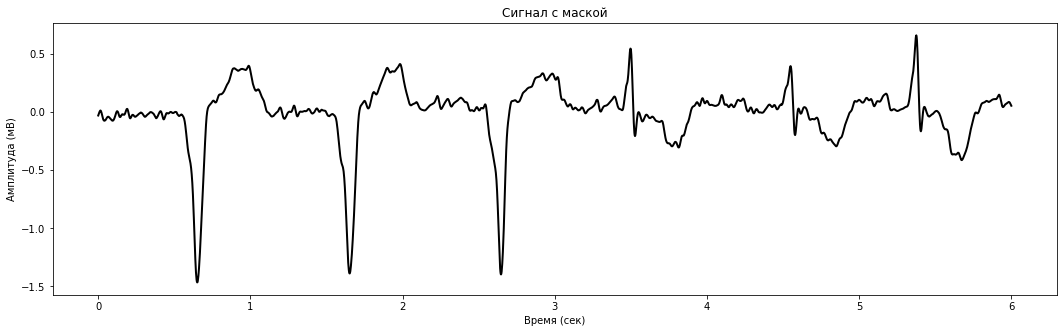

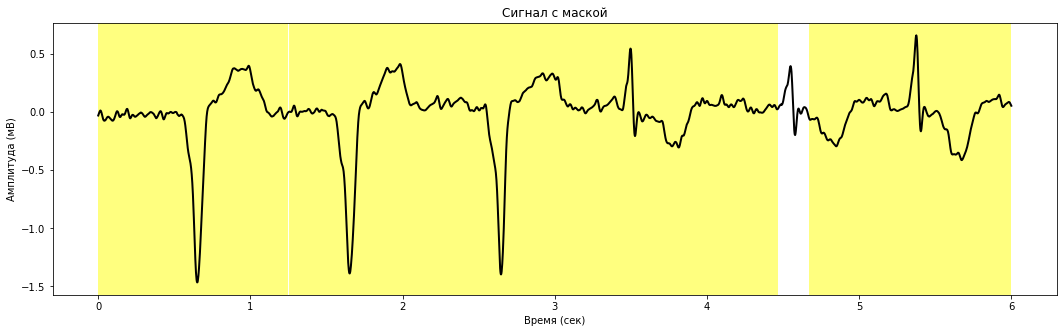

In [4311]:
print_test_ecg(9, 1500)

In [1508]:
a2,b2 = get_results(signals_test, masks_test, unet_test, 2, 0)

'https://healing-pebbles.ru/ecg?id=117311&begin=14950970&end=14953970'

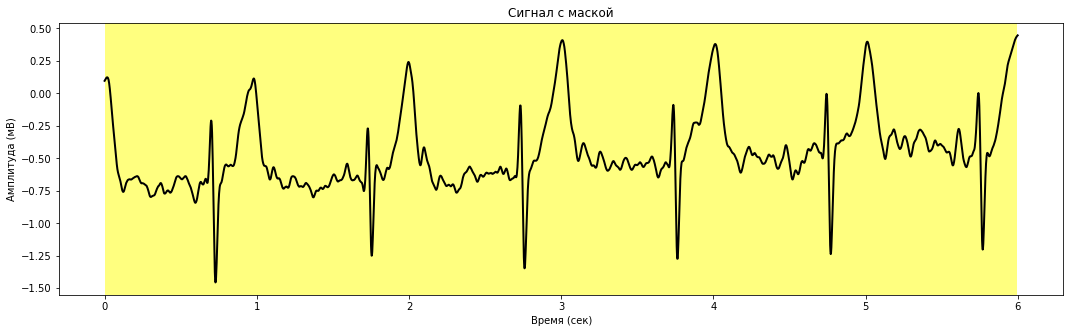

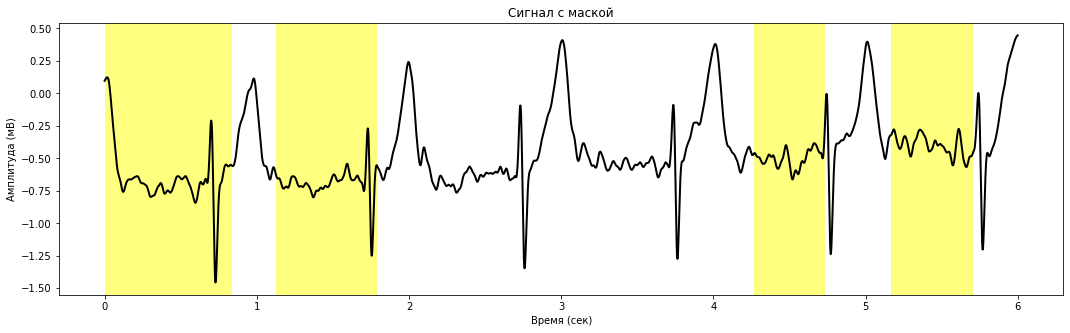

In [1509]:
print_test_ecg(0, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=14923769&end=14926769'

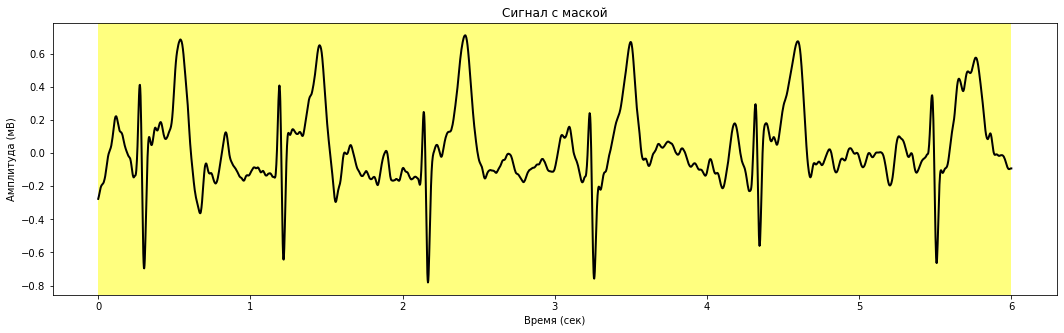

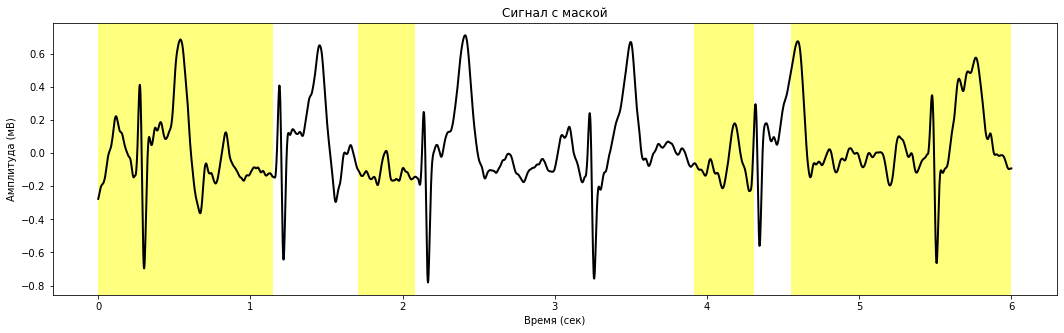

In [1510]:
print_test_ecg(1, 1500)

'https://healing-pebbles.ru/ecg?id=117473&begin=1983538&end=1986538'

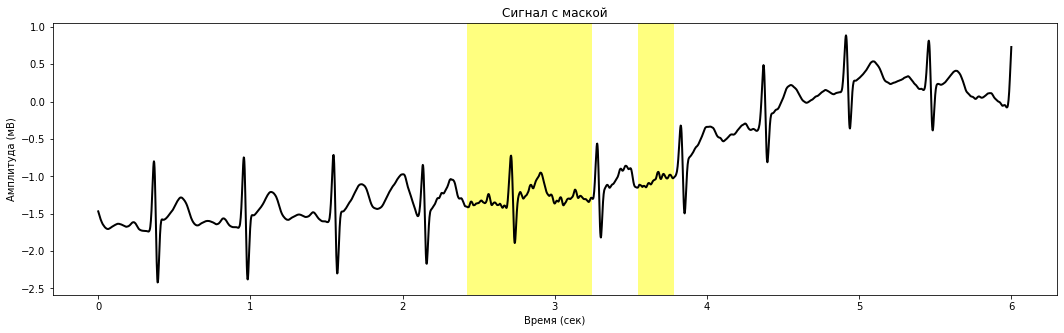

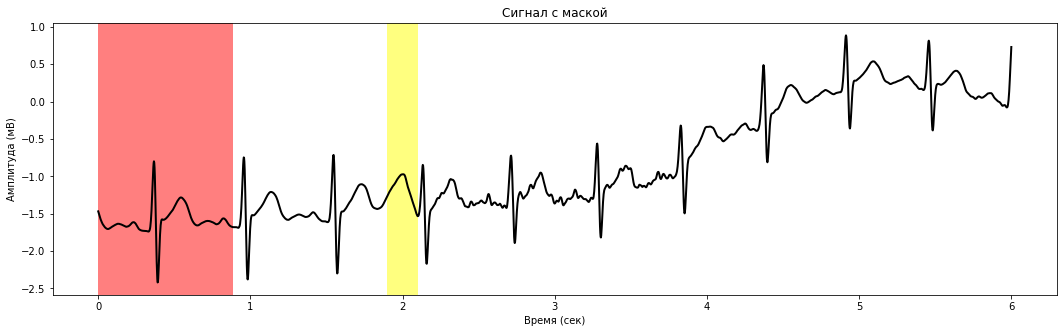

In [1511]:
print_test_ecg(2, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=14930172&end=14933172'

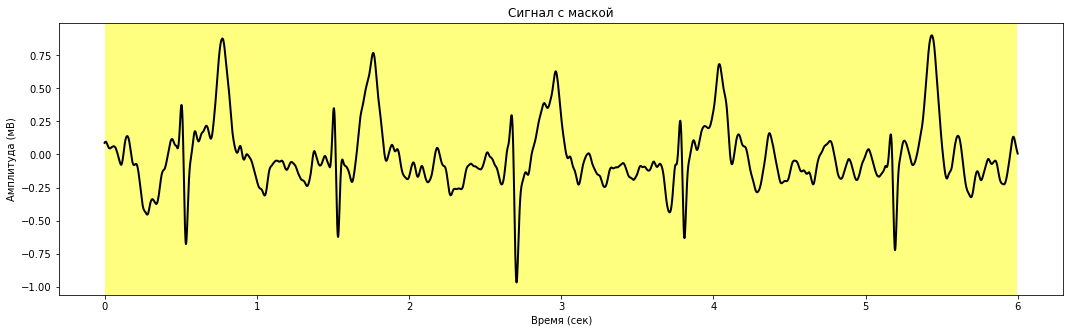

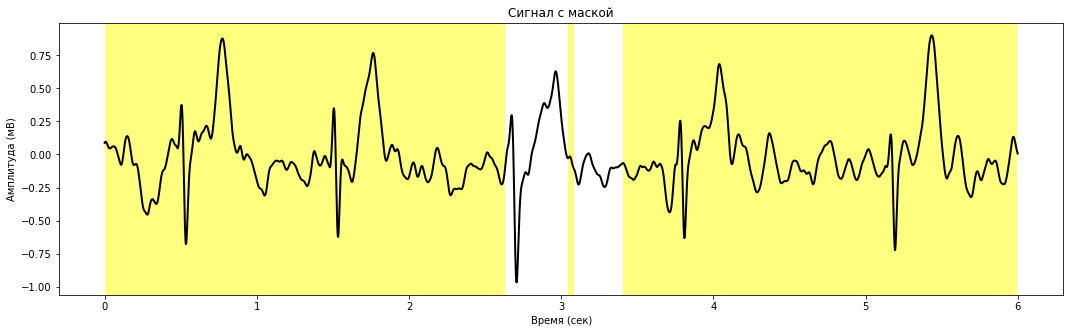

In [1512]:
print_test_ecg(3, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=4056034&end=4059034'

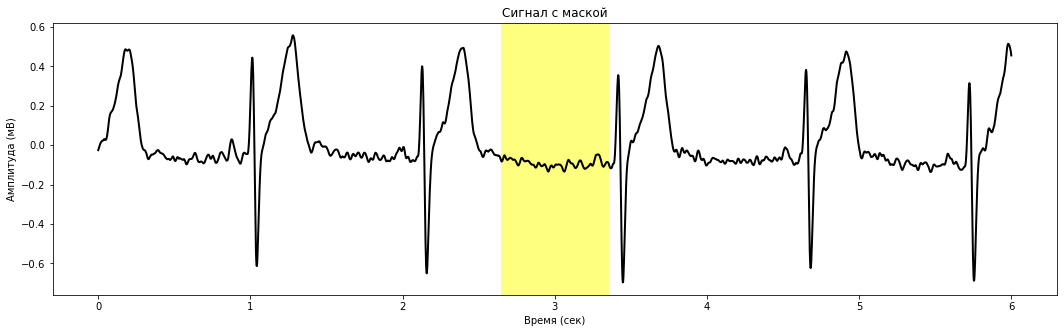

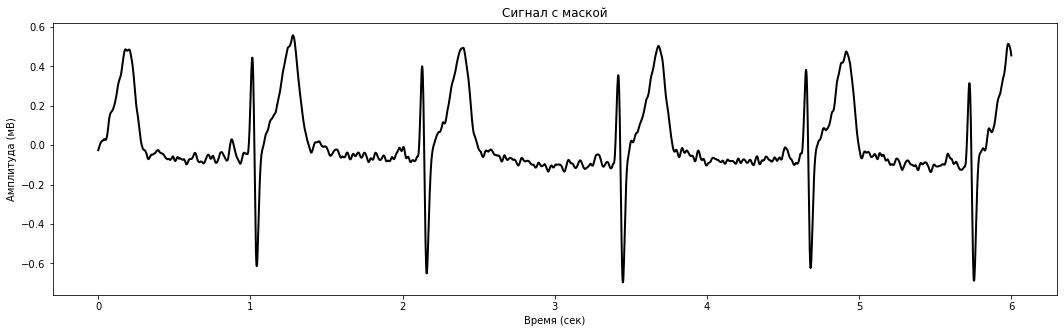

In [1513]:
print_test_ecg(4, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=14976290&end=14979290'

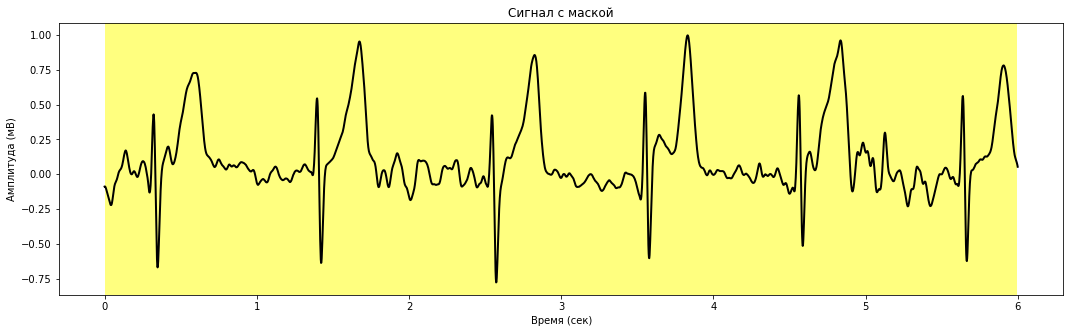

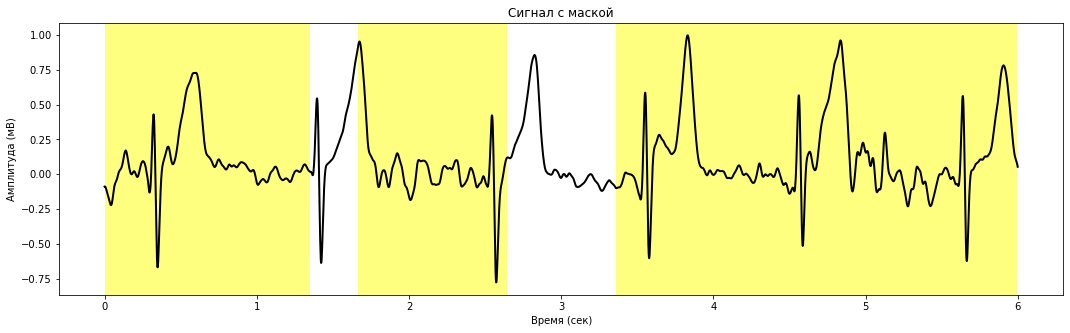

In [1514]:
print_test_ecg(5, 1500)

'https://healing-pebbles.ru/ecg?id=117473&begin=1216549&end=1219549'

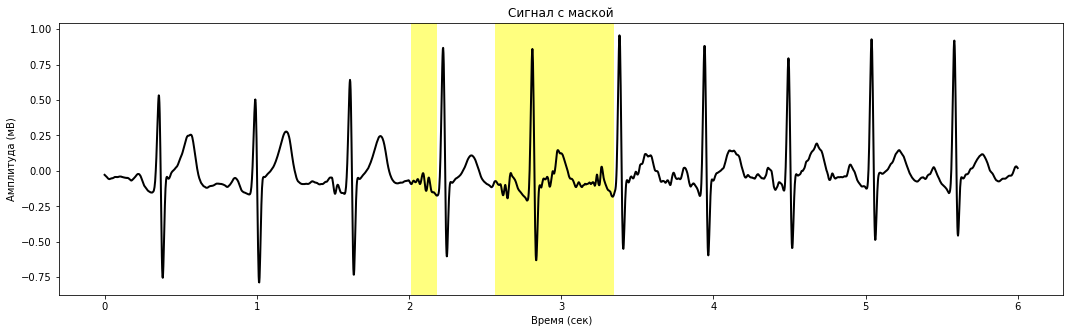

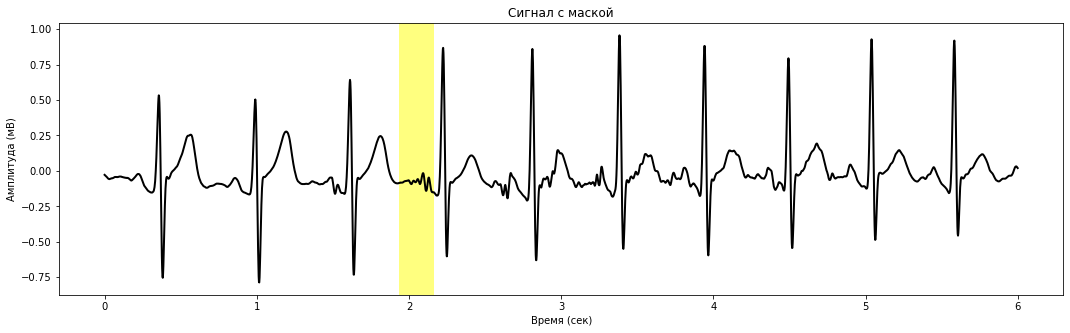

In [1515]:
print_test_ecg(6, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=4001731&end=4004731'

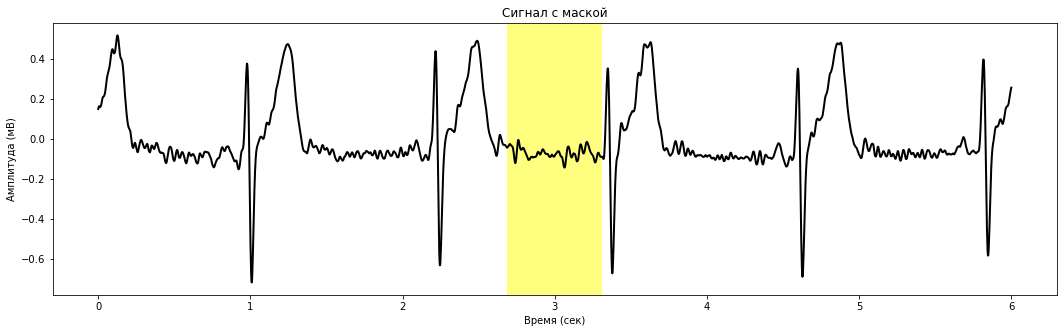

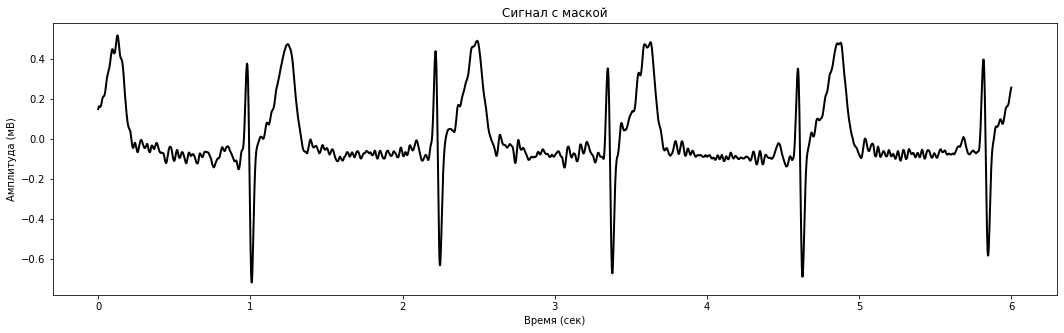

In [1516]:
print_test_ecg(7, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=4029820&end=4032820'

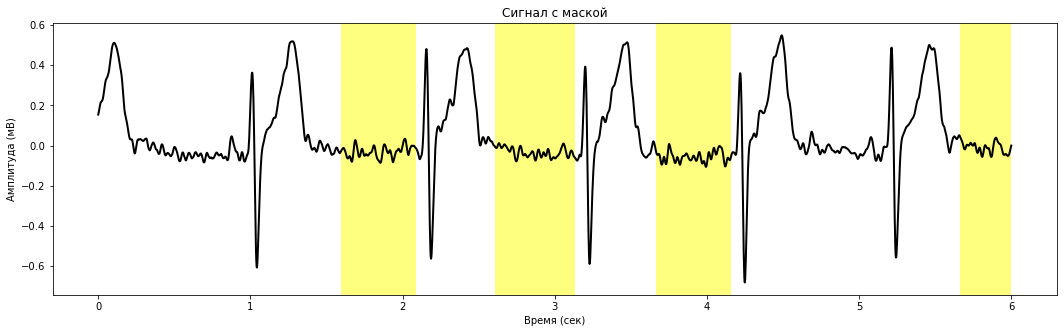

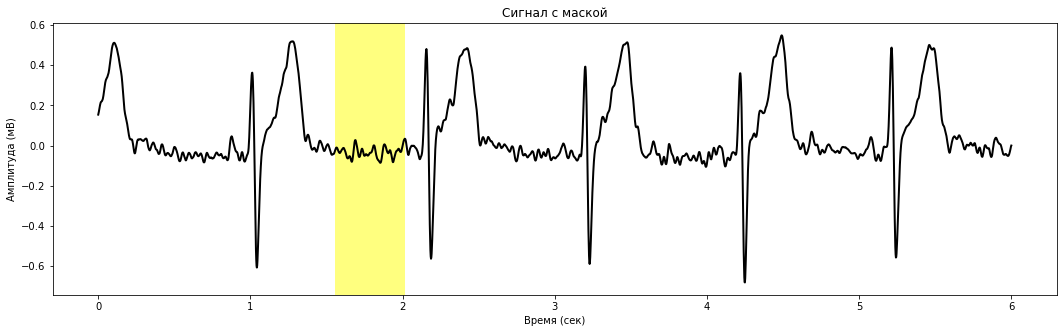

In [1517]:
print_test_ecg(8, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=4023726&end=4026726'

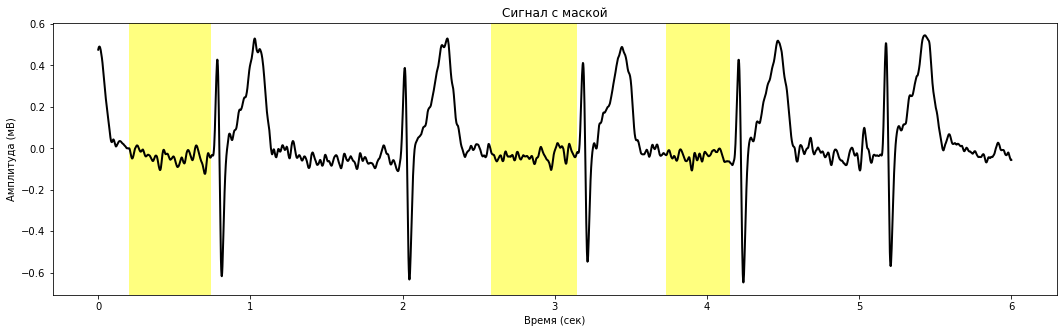

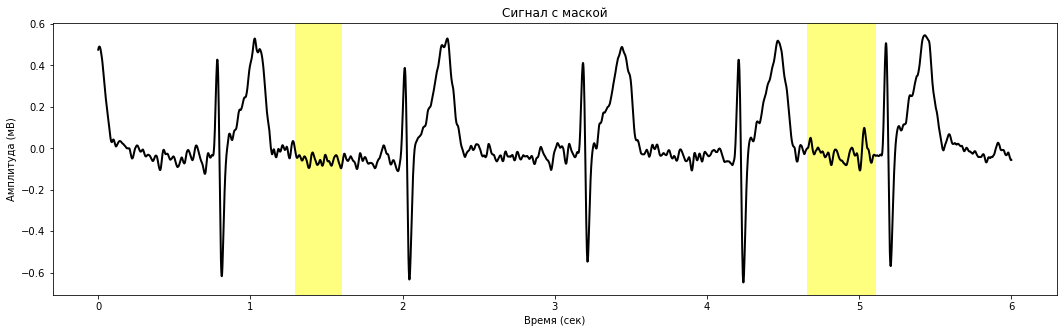

In [1518]:
print_test_ecg(9, 1500)

'https://healing-pebbles.ru/ecg?id=116909&begin=1192780&end=1195780'

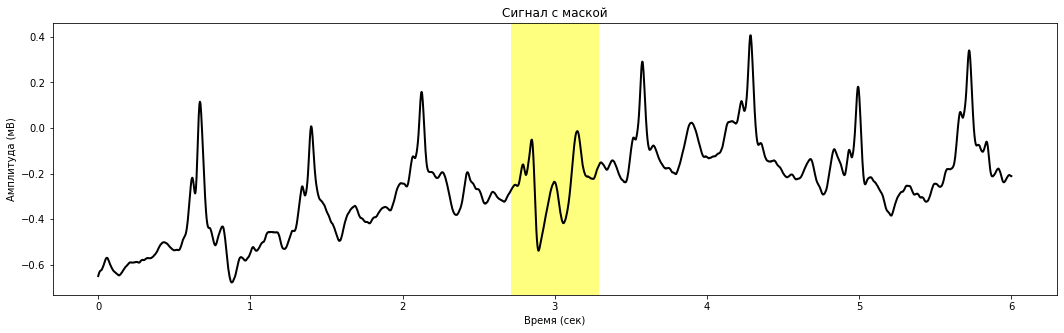

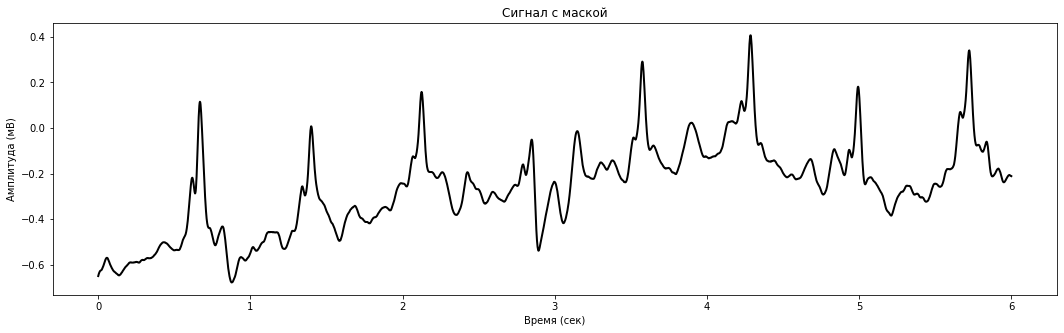

In [1519]:
print_test_ecg(10, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=4057820&end=4060820'

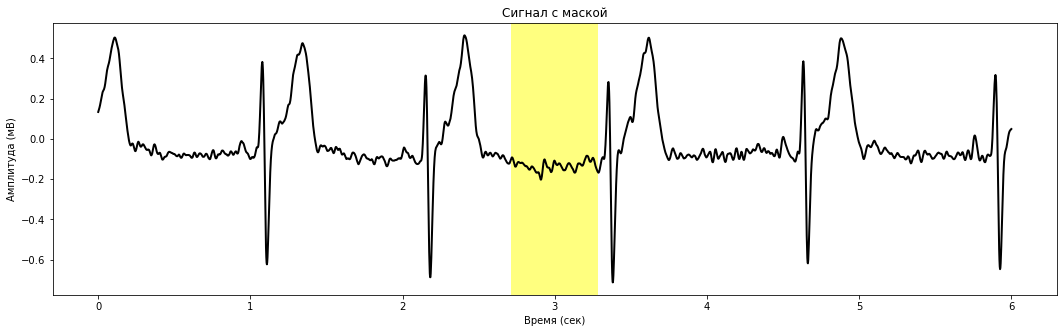

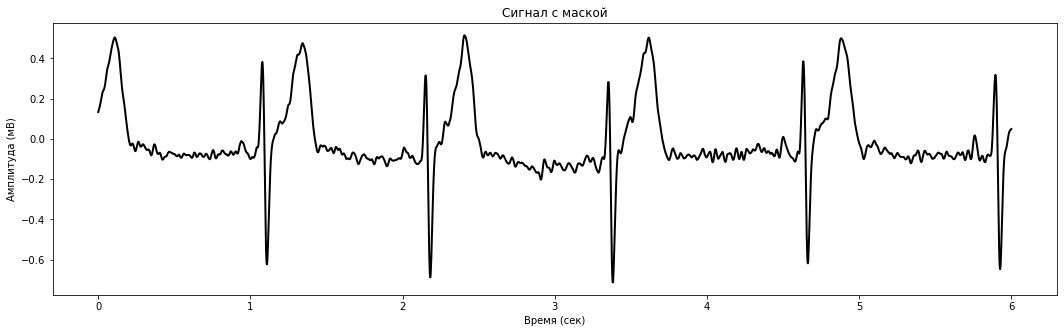

In [1520]:
print_test_ecg(11, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=4087057&end=4090057'

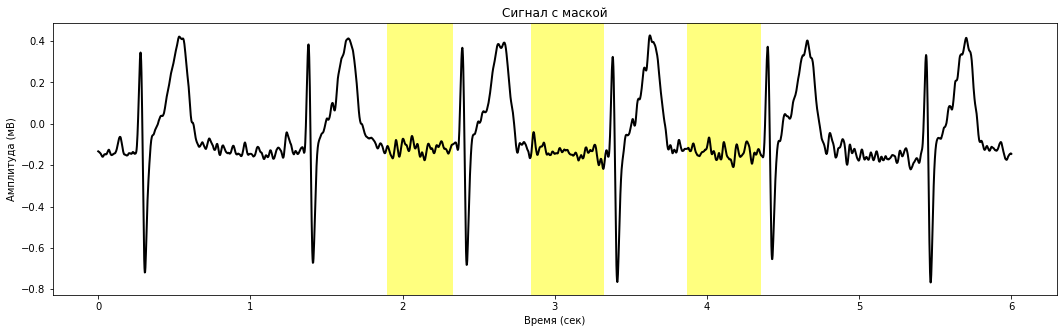

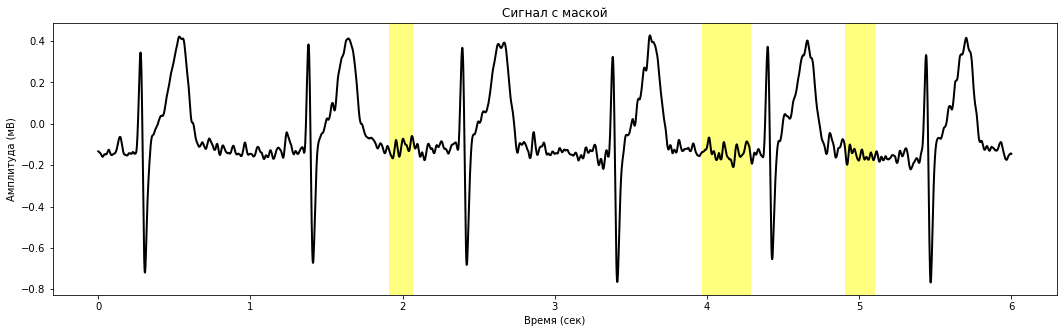

In [1521]:
print_test_ecg(12, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=6029925&end=6032925'

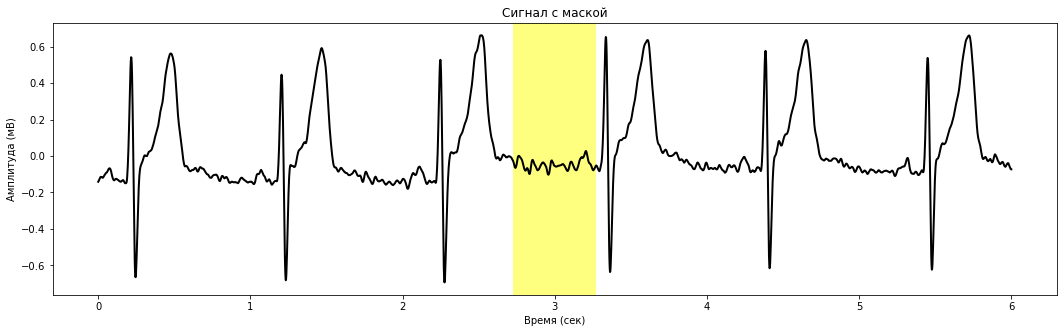

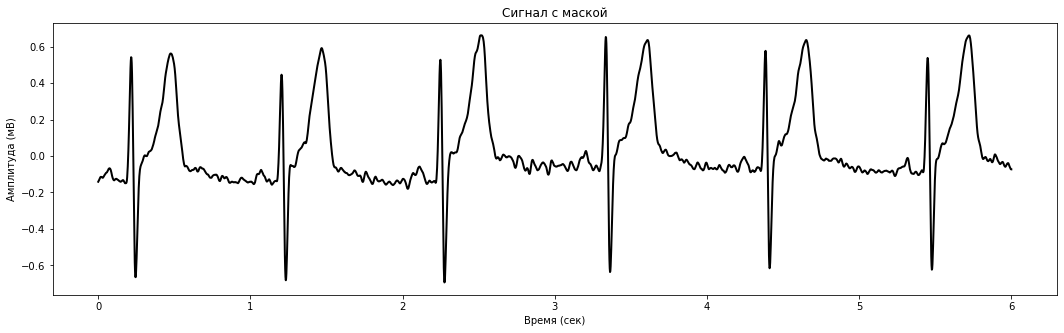

In [1522]:
print_test_ecg(13, 1500)

'https://healing-pebbles.ru/ecg?id=117460&begin=1294355&end=1297355'

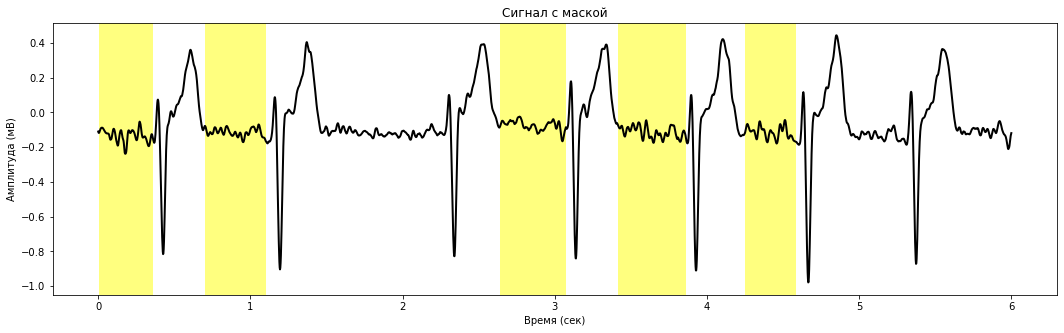

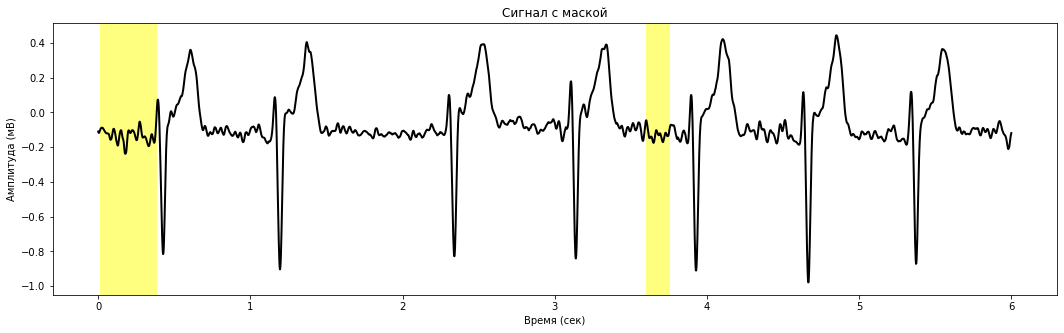

In [1523]:
print_test_ecg(14, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=6001885&end=6004885'

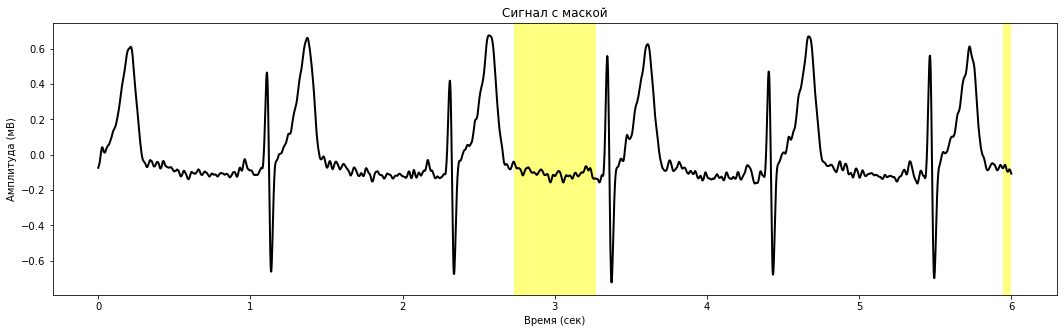

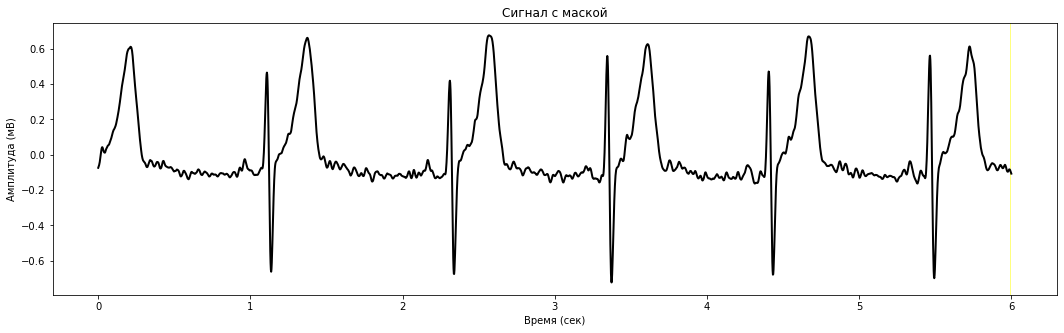

In [1524]:
print_test_ecg(15, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=11036418&end=11039418'

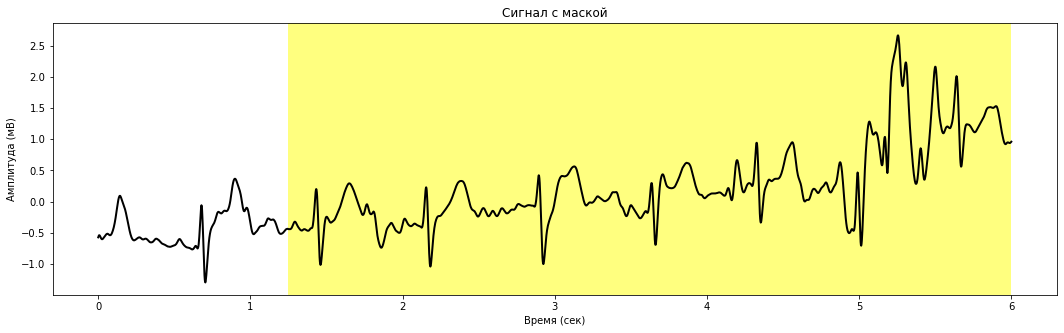

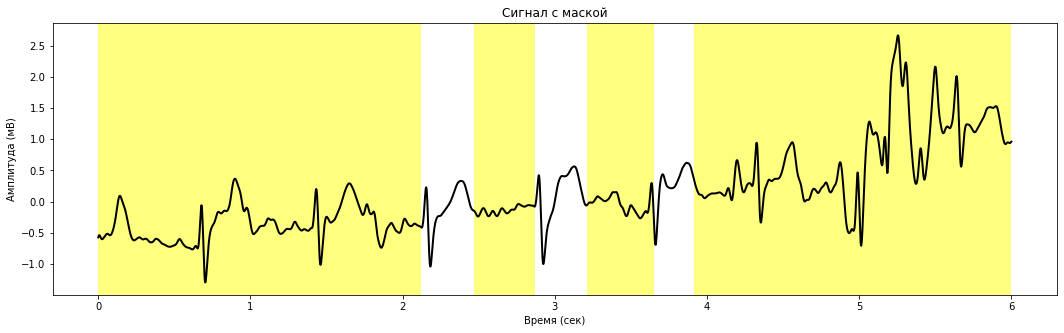

In [1525]:
print_test_ecg(16, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=4003535&end=4006535'

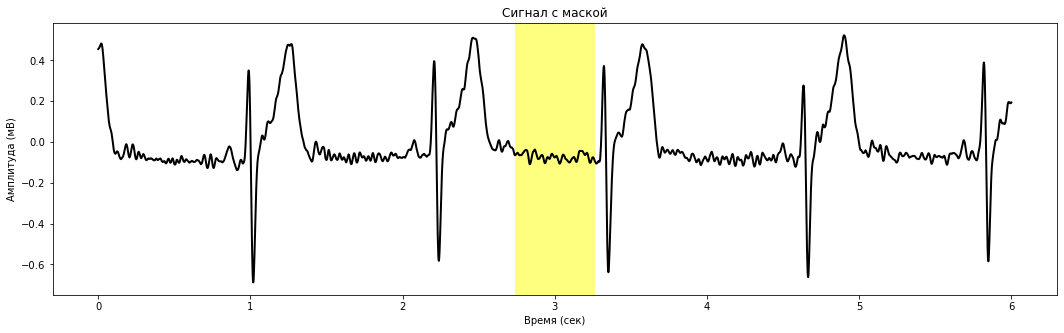

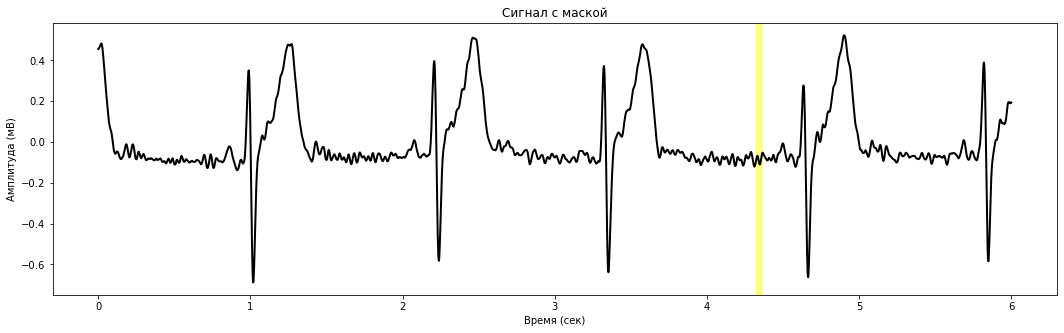

In [1526]:
print_test_ecg(17, 1500)

'https://healing-pebbles.ru/ecg?id=117311&begin=4388223&end=4391223'

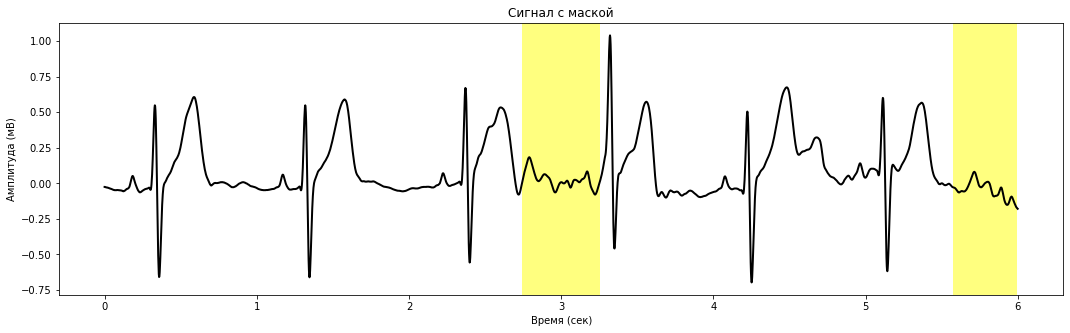

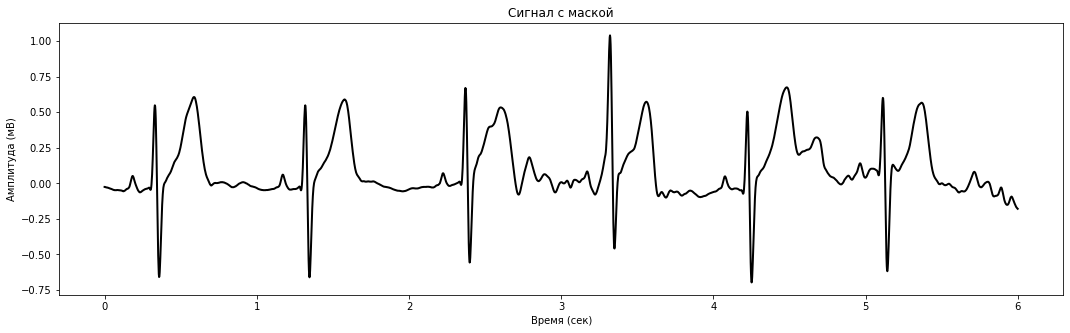

In [1527]:
print_test_ecg(18, 1500)

'https://healing-pebbles.ru/ecg?id=117316&begin=189572&end=192572'

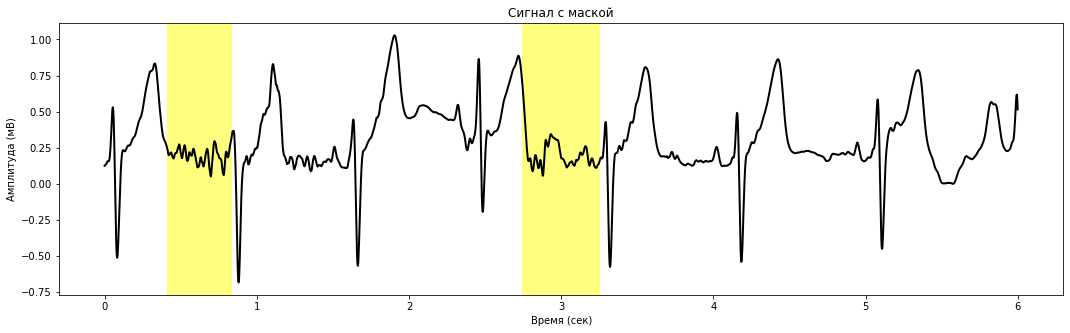

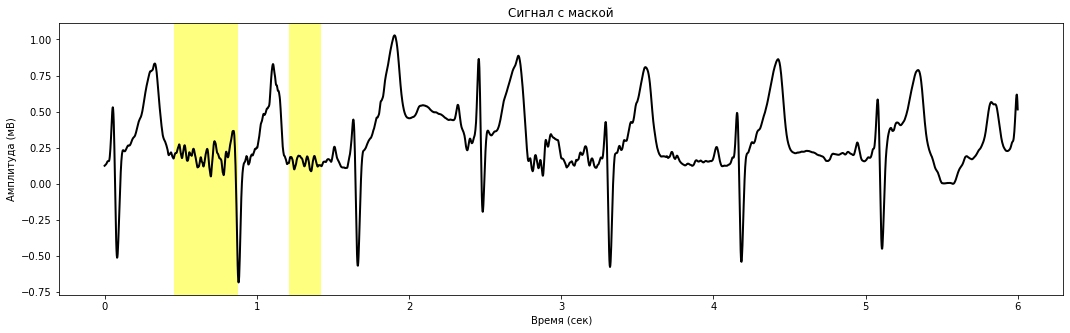

In [1528]:
print_test_ecg(19, 1500)

In [1311]:
a2,b2 = get_results(signals_test, masks_test, unet_test, 0, 1)

'https://healing-pebbles.ru/ecg?id=17470&begin=4461595&end=4464595'

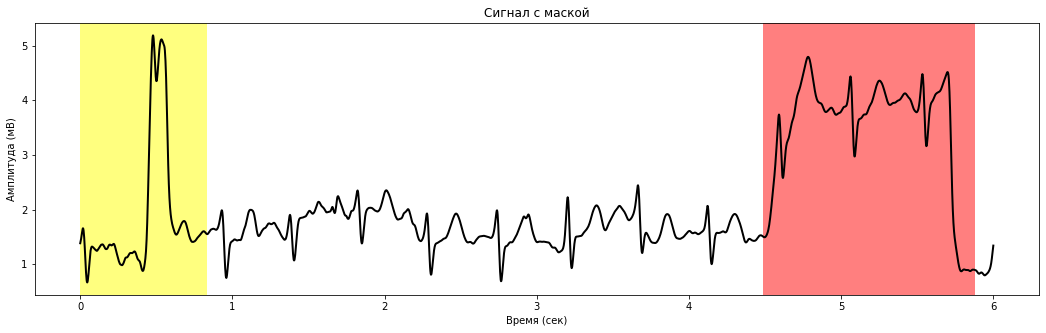

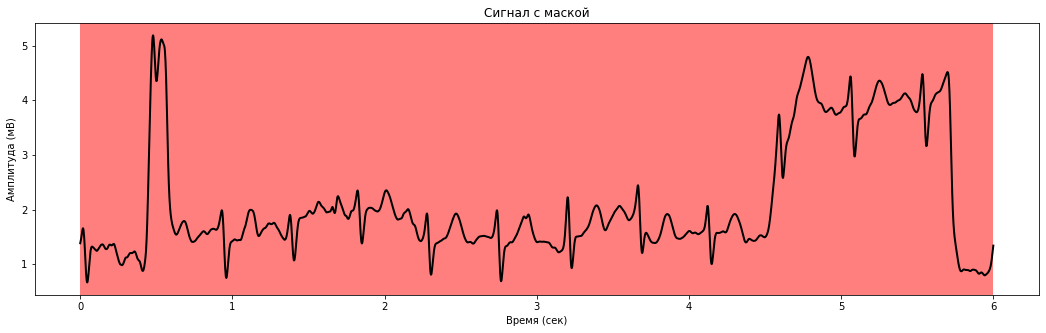

In [1325]:
print_test_ecg(0, 1500)

'https://healing-pebbles.ru/ecg?id=17470&begin=4511208&end=4514208'

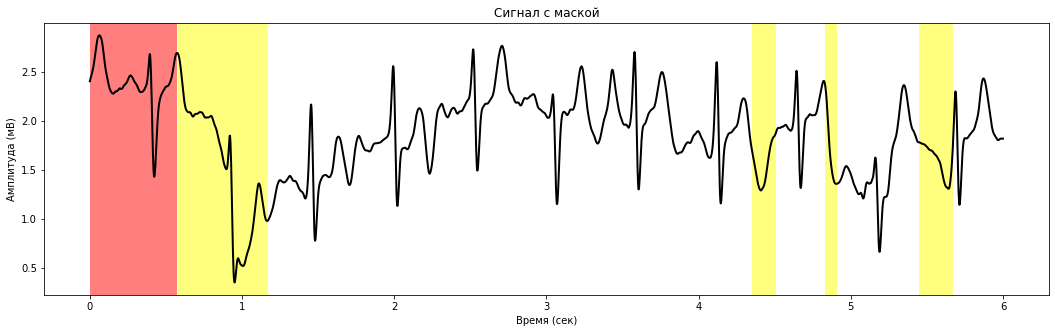

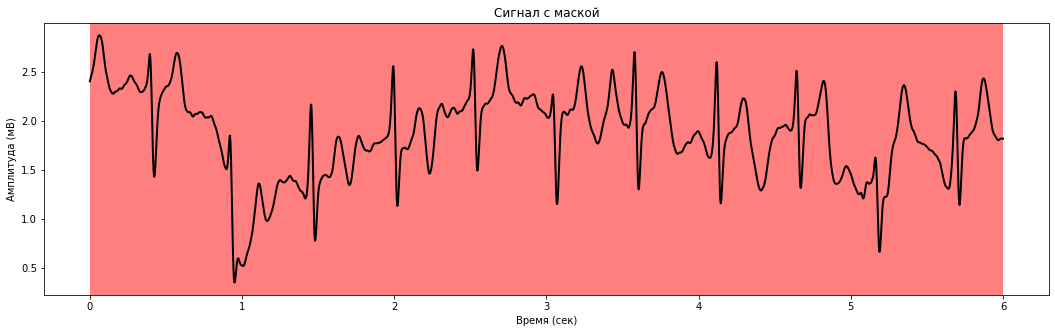

In [1326]:
print_test_ecg(1, 1500)

'https://healing-pebbles.ru/ecg?id=17470&begin=4300035&end=4303035'

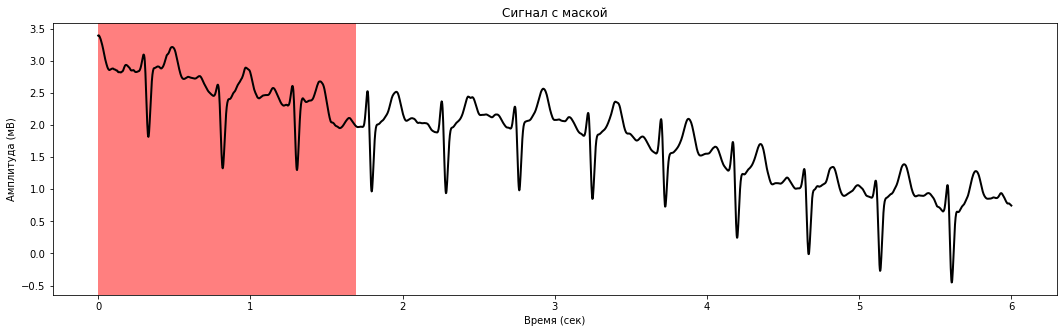

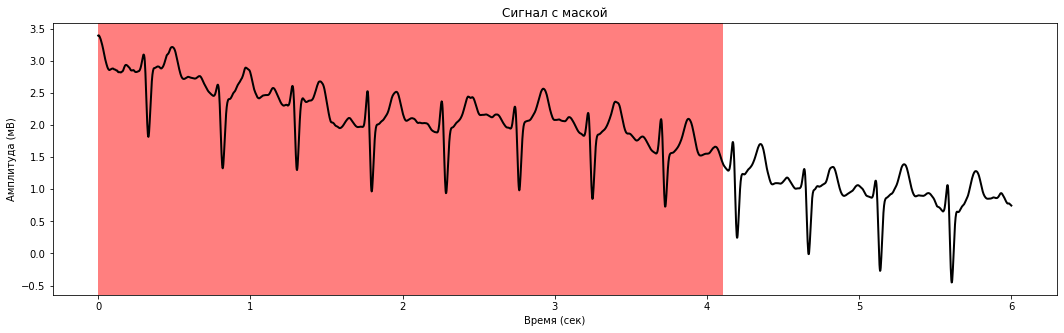

In [1327]:
print_test_ecg(2, 1500)

'https://healing-pebbles.ru/ecg?id=117312&begin=310348&end=313348'

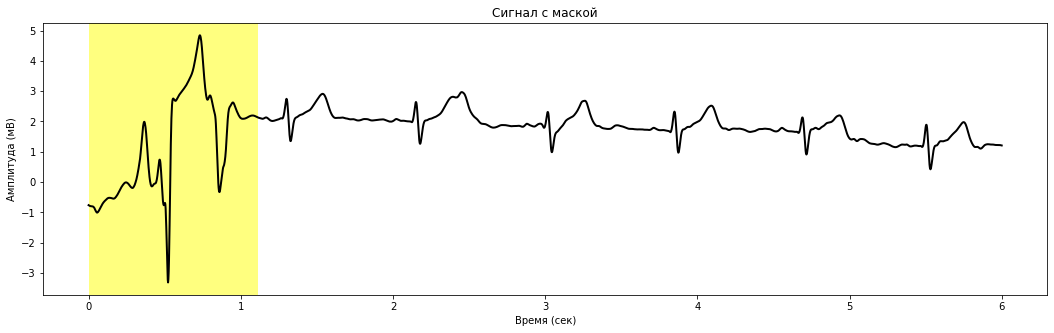

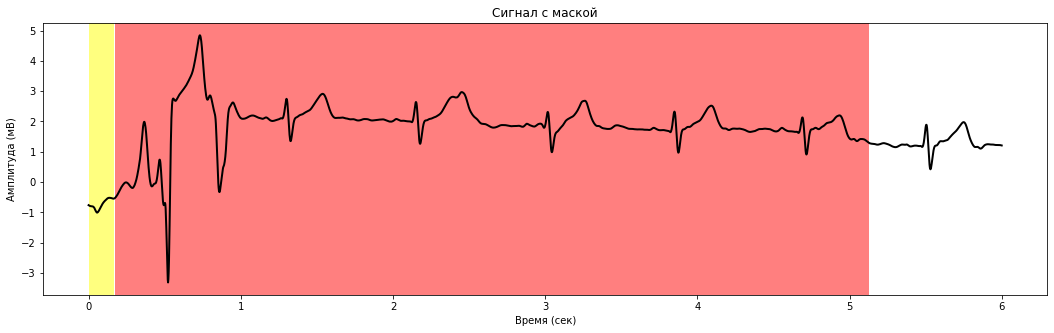

In [1328]:
print_test_ecg(3, 1500)

'https://healing-pebbles.ru/ecg?id=116909&begin=547581&end=550581'

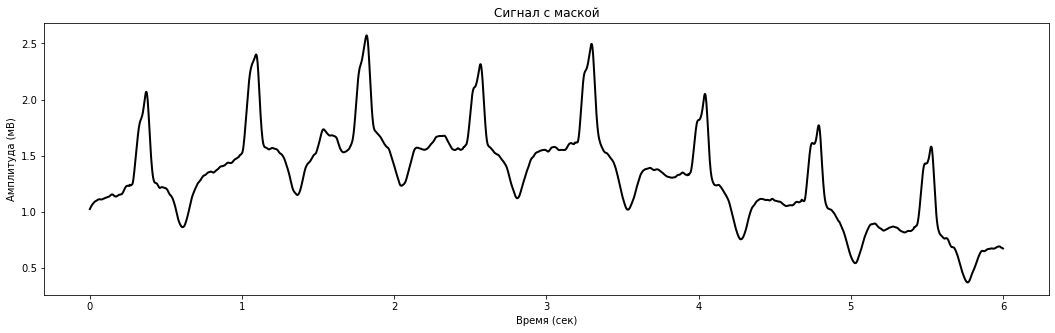

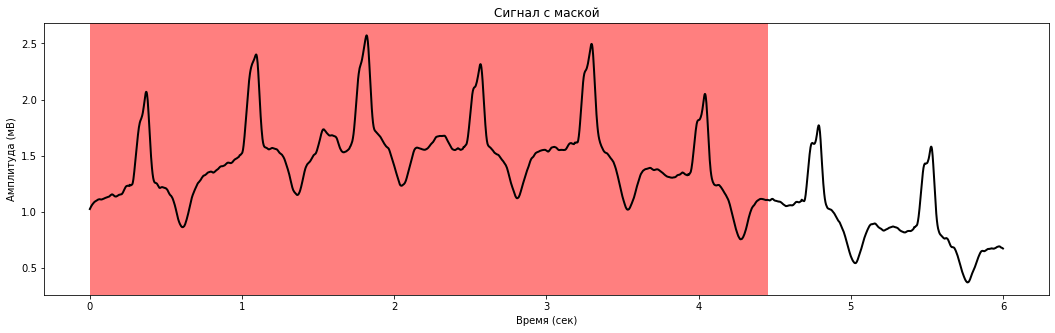

In [1329]:
print_test_ecg(4, 1500)

'https://healing-pebbles.ru/ecg?id=116909&begin=114203&end=117203'

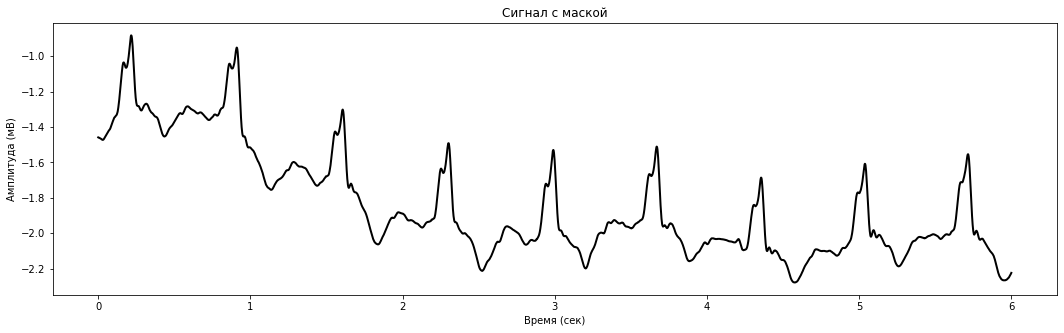

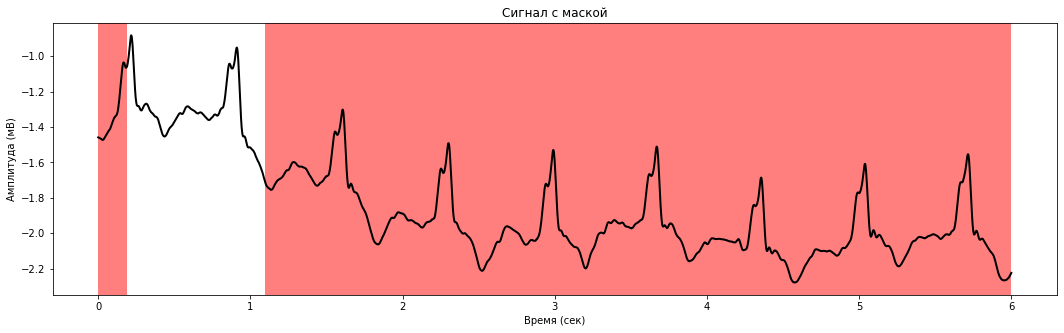

In [1330]:
print_test_ecg(5, 1500)

'https://healing-pebbles.ru/ecg?id=116909&begin=115791&end=118791'

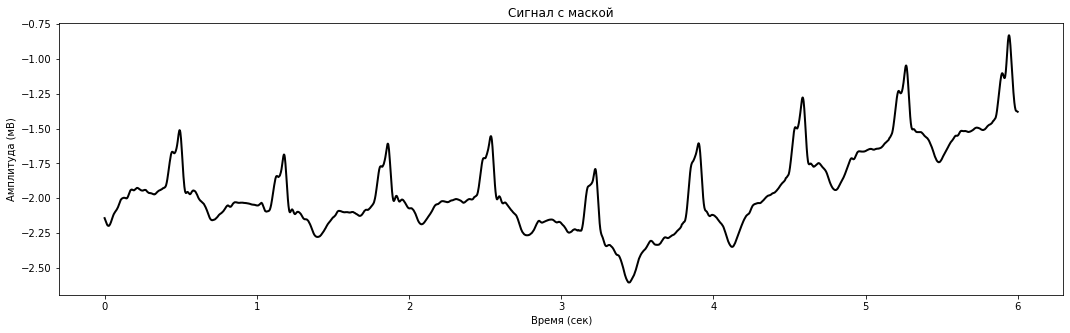

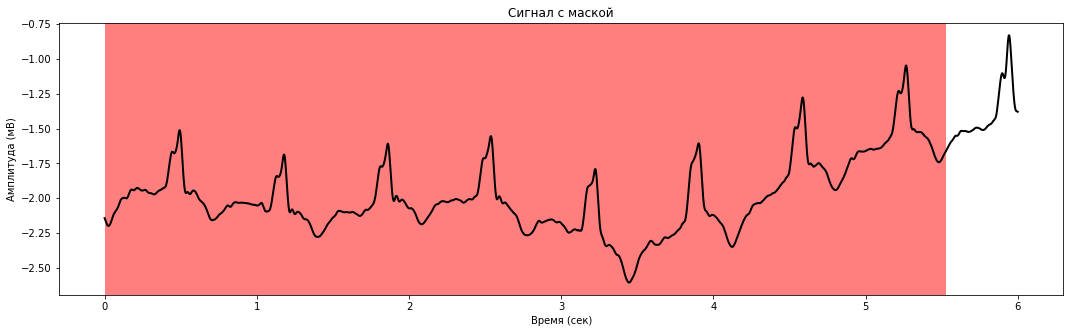

In [1331]:
print_test_ecg(6, 1500)

'https://healing-pebbles.ru/ecg?id=116615&begin=483249&end=486249'

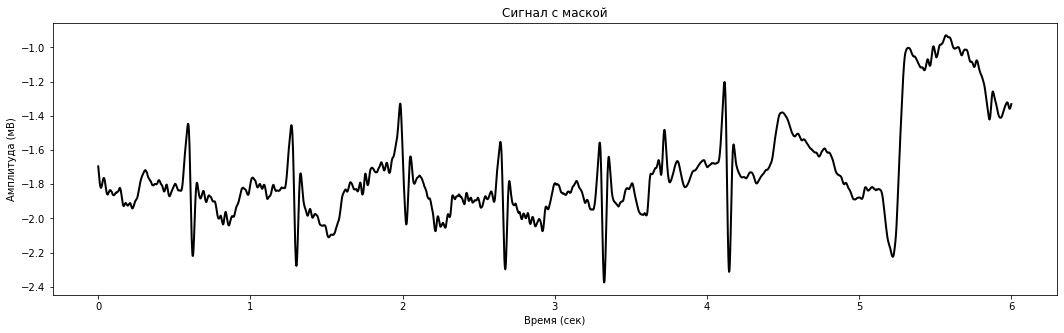

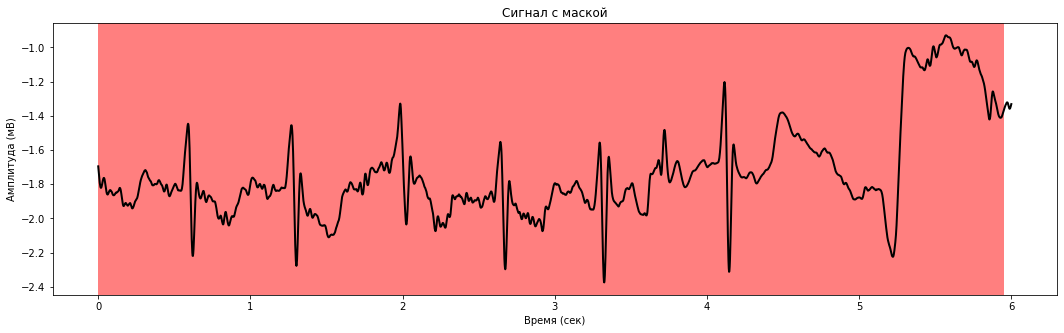

In [1332]:
print_test_ecg(7, 1500)

'https://healing-pebbles.ru/ecg?id=117542&begin=54984&end=57984'

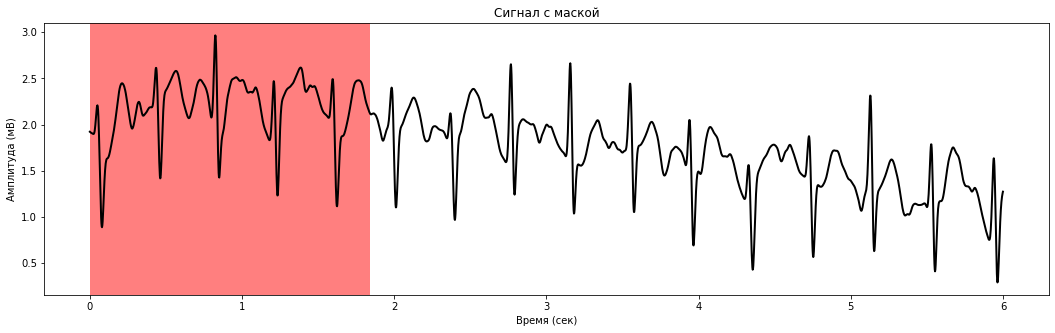

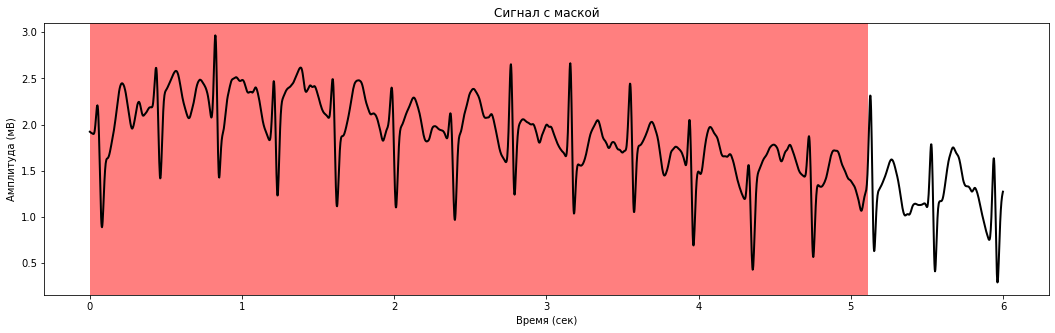

In [1333]:
print_test_ecg(8, 1500)

'https://healing-pebbles.ru/ecg?id=117542&begin=245154&end=248154'

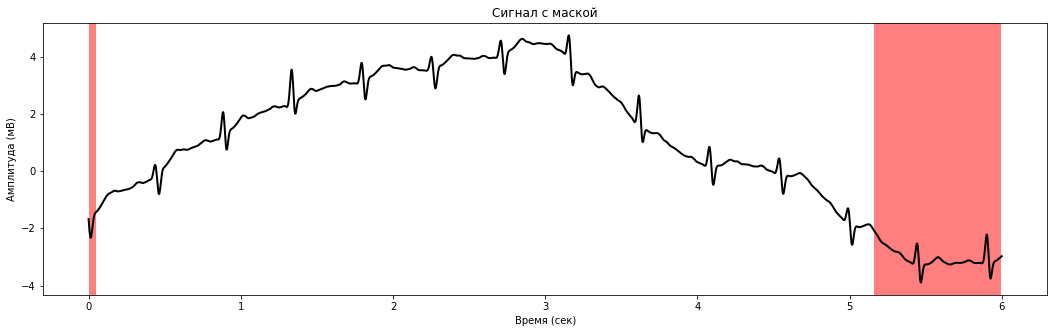

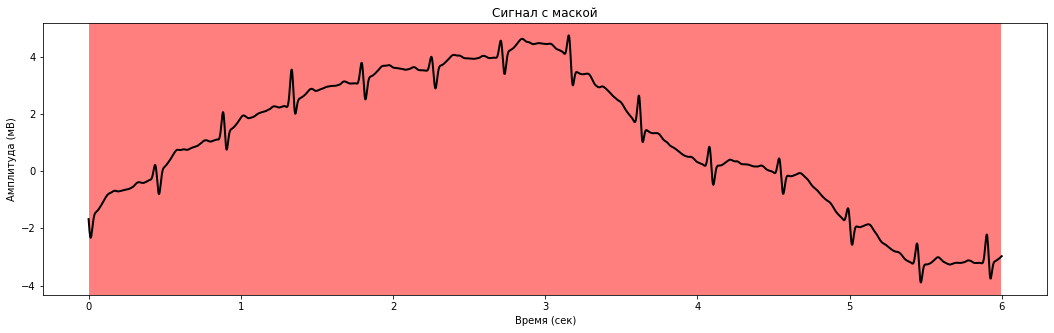

In [1334]:
print_test_ecg(9, 1500)

'https://healing-pebbles.ru/ecg?id=117460&begin=1331315&end=1334315'

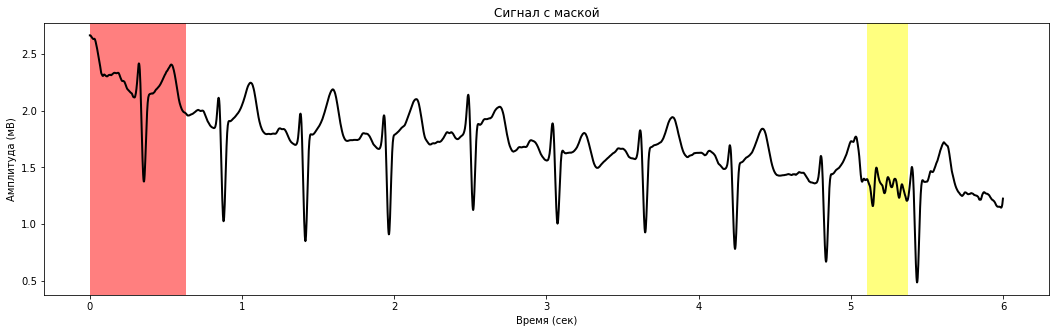

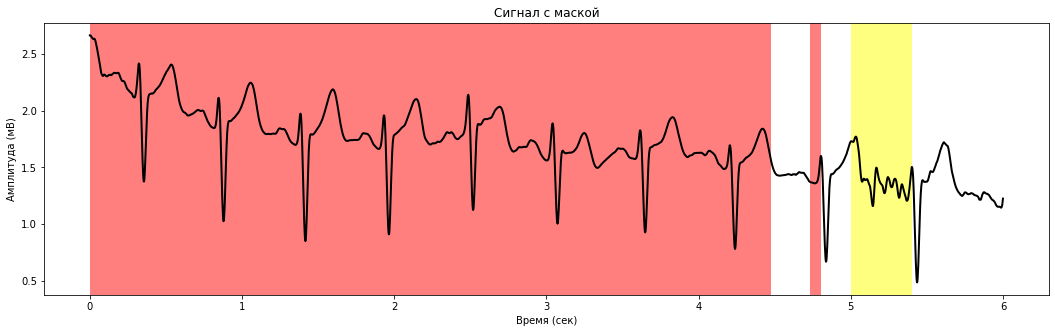

In [1335]:
print_test_ecg(10, 1500)

'https://healing-pebbles.ru/ecg?id=117460&begin=1310211&end=1313211'

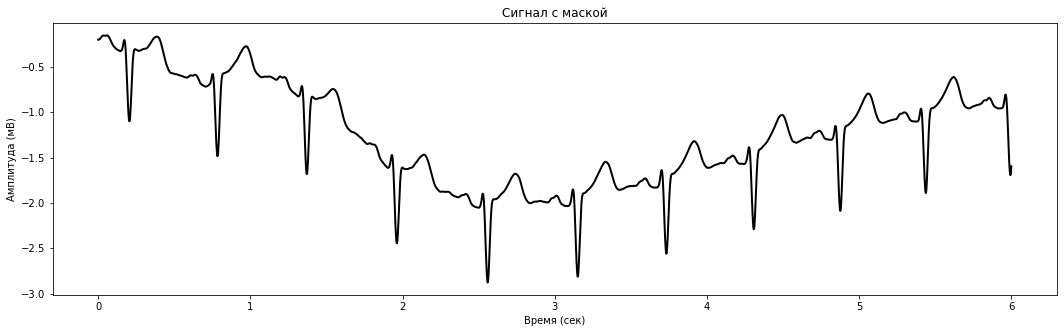

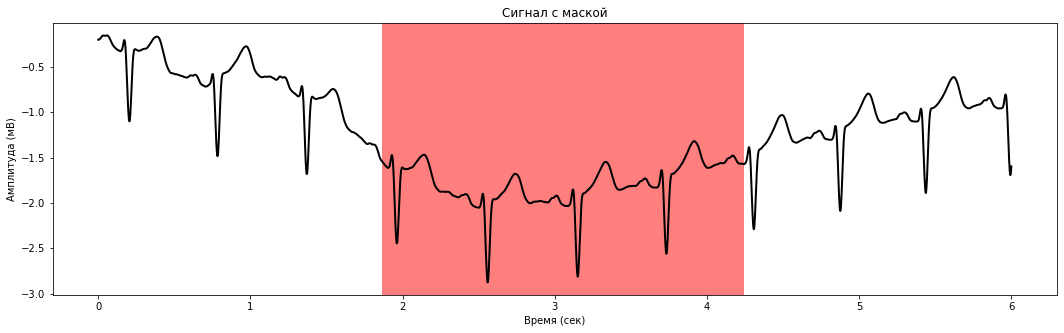

In [1336]:
print_test_ecg(11, 1500)

'https://healing-pebbles.ru/ecg?id=117542&begin=214977&end=217977'

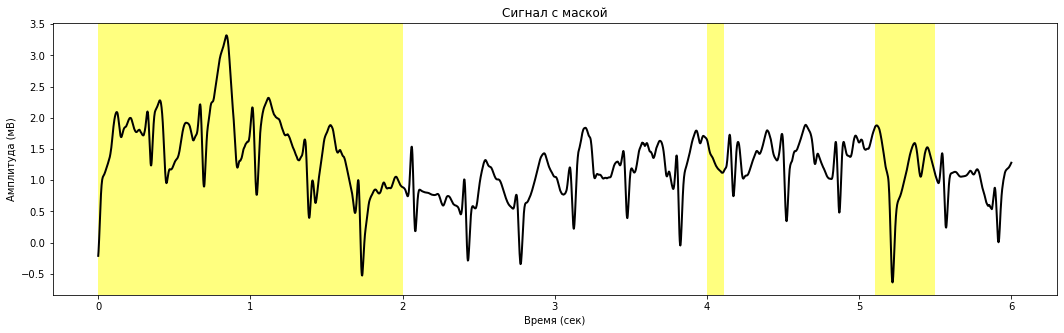

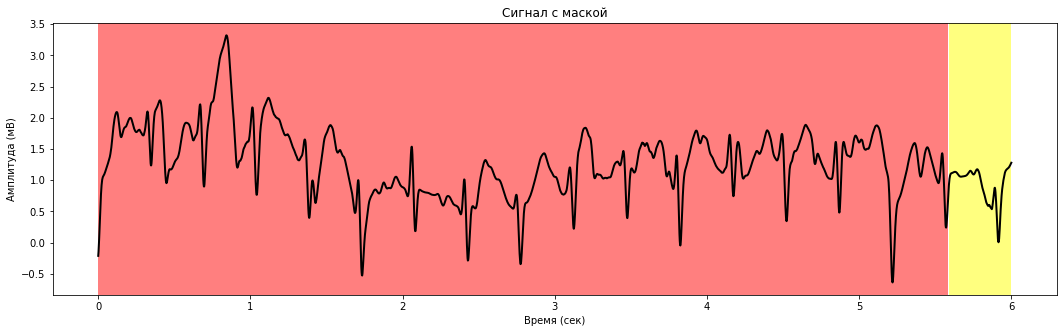

In [1337]:
print_test_ecg(12, 1500)

'https://healing-pebbles.ru/ecg?id=116909&begin=112301&end=115301'

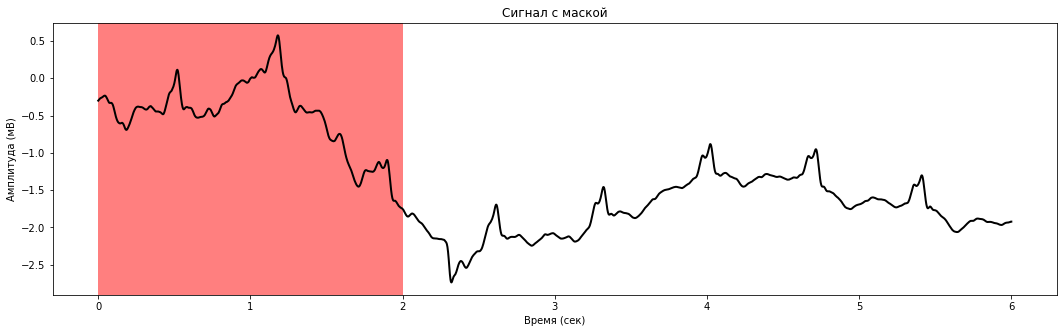

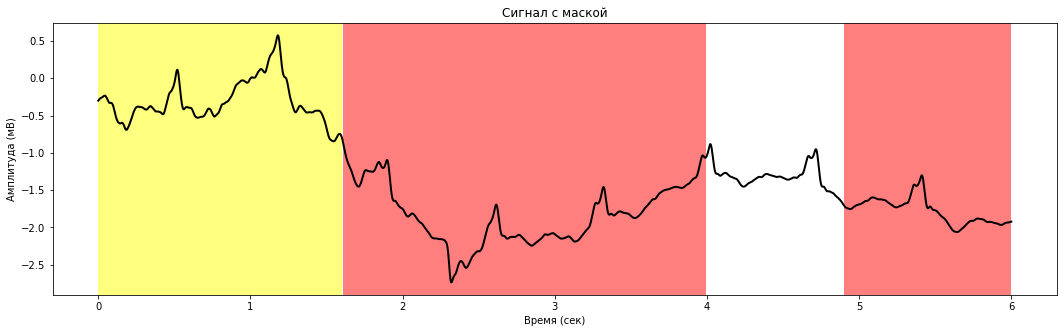

In [1338]:
print_test_ecg(13, 1500)

'https://healing-pebbles.ru/ecg?id=116909&begin=546080&end=549080'

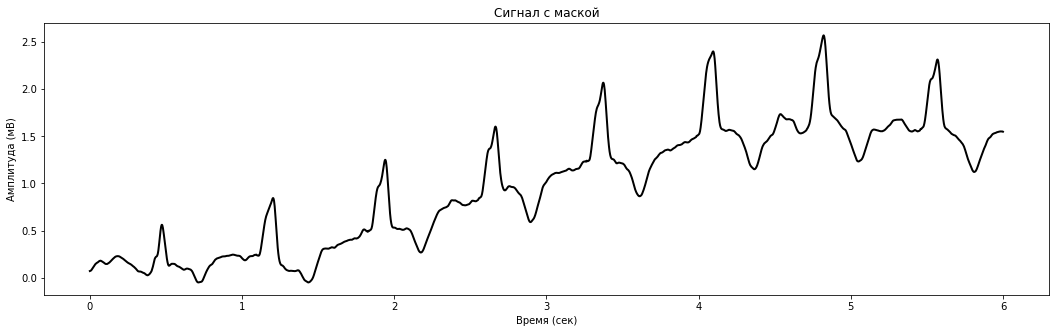

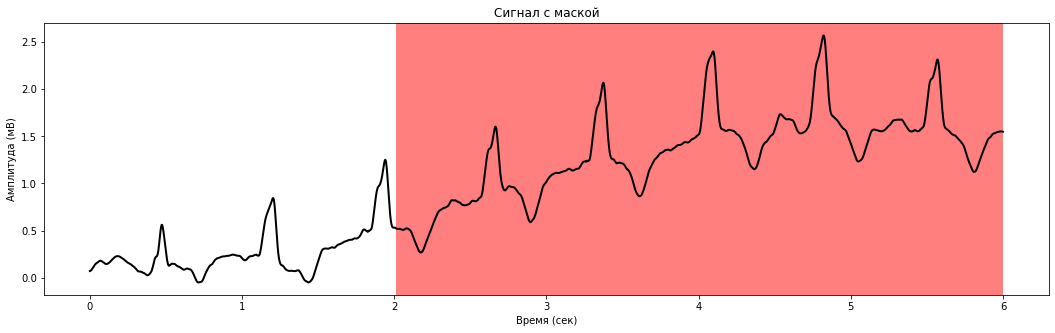

In [1339]:
print_test_ecg(14, 1500)

'https://healing-pebbles.ru/ecg?id=117542&begin=193995&end=196995'

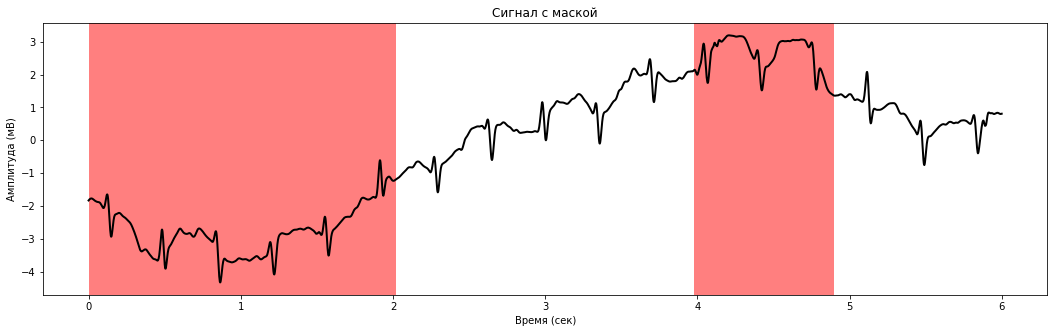

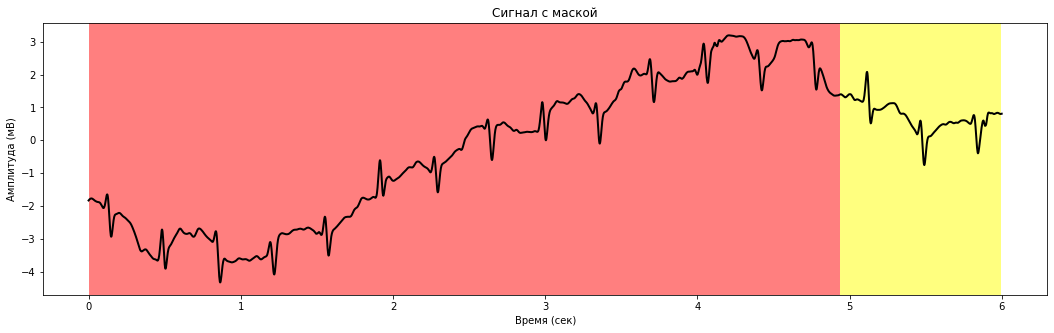

In [1340]:
print_test_ecg(15, 1500)

'https://healing-pebbles.ru/ecg?id=117542&begin=35132&end=38132'

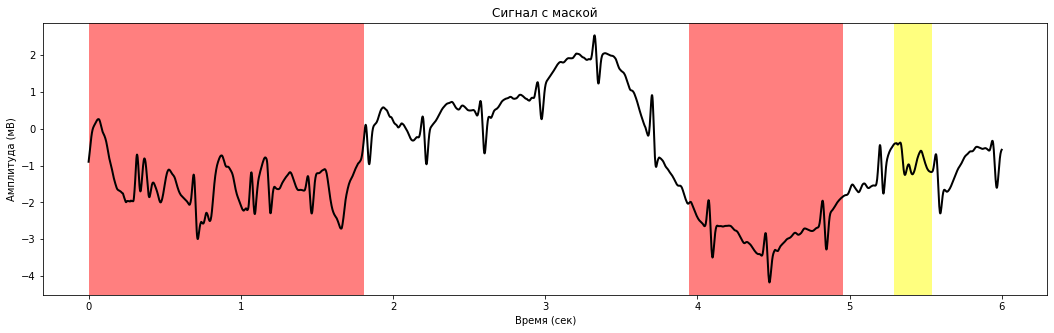

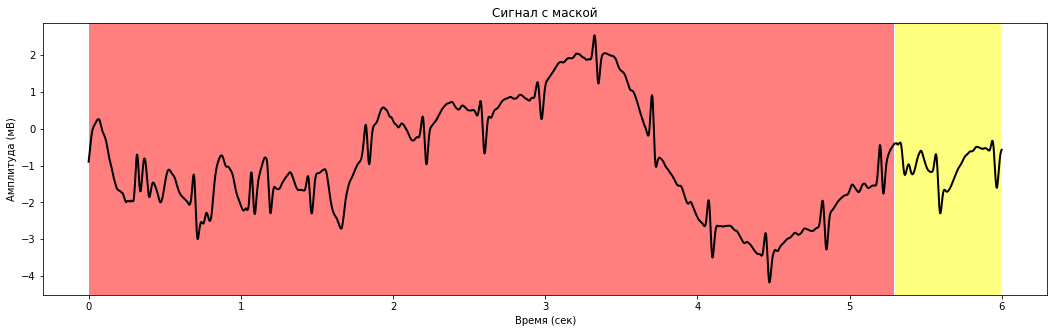

In [1341]:
print_test_ecg(16, 1500)

'https://healing-pebbles.ru/ecg?id=116615&begin=481748&end=484748'

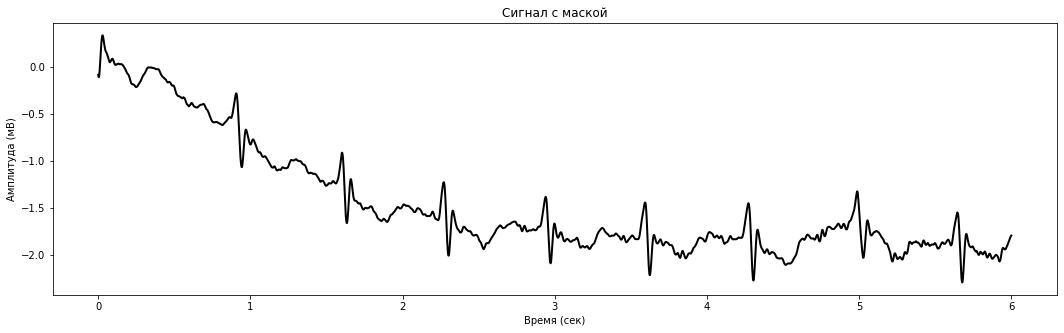

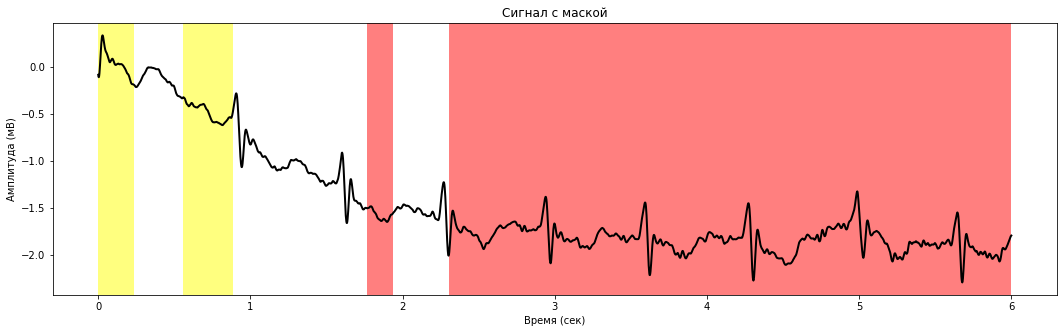

In [1342]:
print_test_ecg(17, 1500)

'https://healing-pebbles.ru/ecg?id=117542&begin=225437&end=228437'

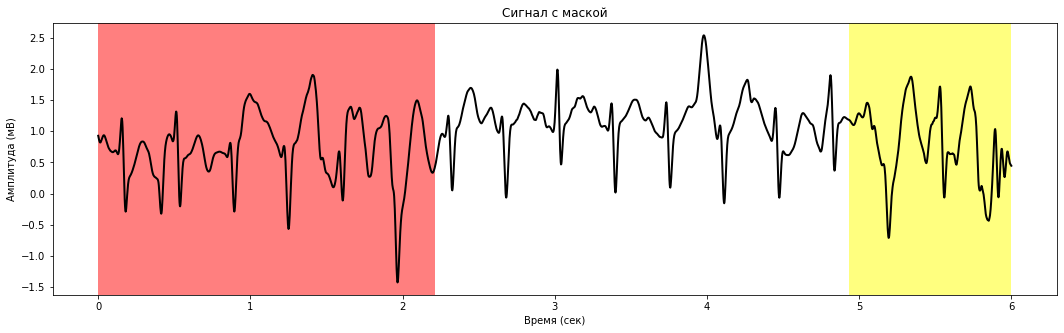

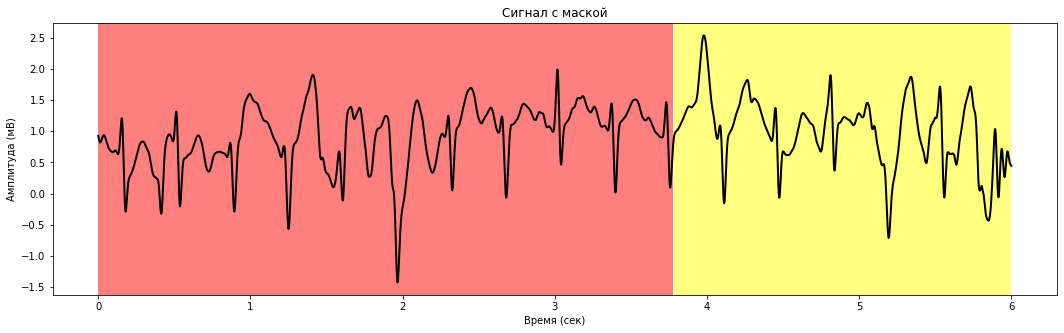

In [1343]:
print_test_ecg(18, 1500)

'https://healing-pebbles.ru/ecg?id=117316&begin=179159&end=182159'

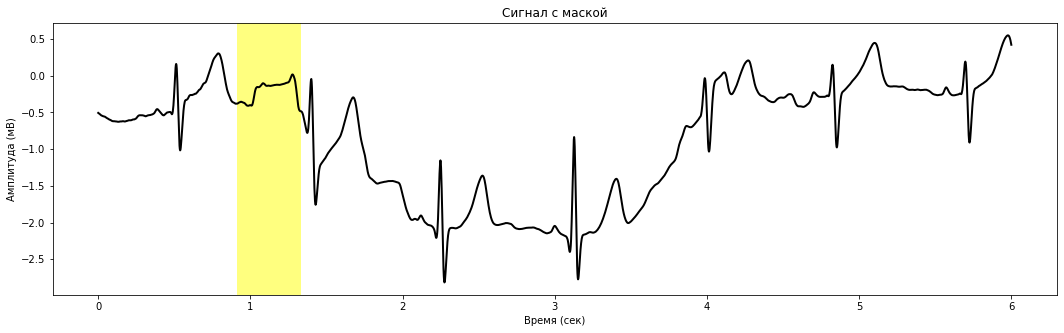

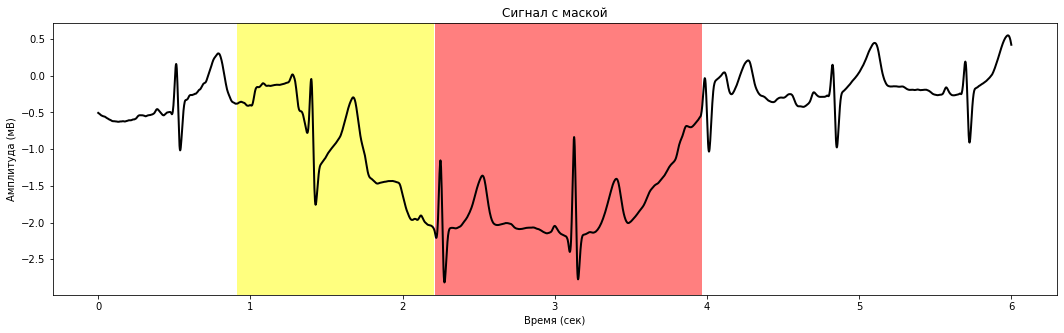

In [1344]:
print_test_ecg(19, 1500)

In [4879]:
x = np.array(get_signal('ecg/117542_signal.json')) * 0.001

In [4970]:
pred = get_full_mask_ecg(x, 0)

In [4971]:
s = 826720

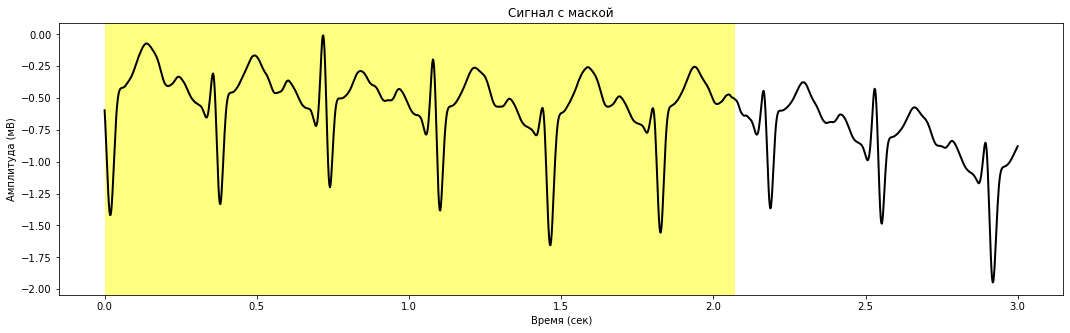

In [5013]:
plot_signal_with_mask(x[s:s+1500], pred[s:s+1500])
s-=1500

In [5006]:
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABC4AAAFNCAYAAADPdy71AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAACkzklEQVR4nOzddZhUZRvA4d872+zSIR2S0gIiHdItIYKU2ILNZ2AidmEgYoJKlwJKhyAgIqWUSCndsbts7877/TF7hmHZmNmdOsNzXxeXuztnznnxsDNznvOE0lojhBBCCCGEEEII4Y8svl6AEEIIIYQQQgghRFYkcCGEEEIIIYQQQgi/JYELIYQQQgghhBBC+C0JXAghhBBCCCGEEMJvSeBCCCGEEEIIIYQQfksCF0IIIYQQQgghhPBbErgQQgghhPAipVQ+pdQDSqkQpVQzpVQzX69JCCGE8GcSuBBCCCGuI0qpu5RSW5RSl5VSJ5VSS5RSLXy9ruuJ1joeaA6cBj4Hzvt2RUIIIYR/U1prX69BCCGEEF6glHoKeA54CFgGJAOdgVZa66d9uTYhhBBCiKxIxoUQQghxHVBKFQTGAiO11j9oreO01ila65+MoIVSaoxSaqrDcz5TSmmlVJX0779VSiWnZ2sYfwoqpdoopY5lON56pdTd6V9XVkqtVkqdV0qdU0pNU0oVyrD9GqVUYvo+E5VS67P5u/RSSv2plIpRSh1USnXOYrv/lFJnlVKhDj/7I/3vFJz+/XCl1N9KqVil1CGl1IPOHCt9vfc5/P2OKqV6pH9vUUq9qJQ6rJQ6o5T6Pv3/P0qpihmO3zj9+9ezPntCCCHE9U0CF0IIIcT1oSkQDvzozMZKqapAl0weeldrHeXwJ9qZ3QFvAaWBm4BywJgM21iwBVWisGWEZLWuxsD3wNNAIaAV8F82xz4H9Ep/bh0gKsPjZ4DuQAFgOPChUqqBs8dSSpXElr3ygtb6p/Qf353+py1wY/oxP81ife8Cx7NZvxBCCHHdk8CFEEIIcX0oCpzTWqc6uf1bwGvuOLDW+oDWeoXWOklrfRYYB7TOsFkottKVnNwLTErfn1VrfVxrvTeb7b9Ofw7A/cA3Gda2SGt9UNusBZYDLZ08VqH07adprb93+PkgYJzW+pDW+jIwGhhgZFkYlFLdsX0WW+nE31sIIYS4bkngQgghhLg+nAeKZbx4zoxS6lagBvCdC/svrZS6ZPwBmjjsr4RSaqZS6rhSKgaYChTL8PwiwEUnjlMOOOjCuv4CCiulqgMdgIWODyqluiilfldKXUhfd1eHteV0rLHAZaCdUsrxM1Vp4LDD94eBYOAGh59ZsAWHnnHh7yKEEEJclyRwIYQQQlwfNgKJwO1ObPsu8JzWOs2F/Z/QWhcy/gC/Ozz2FqCBulrrAsBgbOUjAKT3oKgA7HPiOEeByi6sC2AyMAv4GUhxOG4YMA94H7ghfd2LHdaW07FmA8ZElkccfn4C29/HUB5IxTZFxHA38I/W2vH/kxBCCCEyIYELIYQQ4jqQ3oviZWCCUup2pVQ+pVRIesbBuw6b3mbbXP/sxsPnx5aZcEkpVQZbzwgAlFLh6es6oLV2JnDxDTBcKdUuvQlmGaVUjRyeMx34G/gyw89DgTDgLJCqlOoCdHThWOu11lbgHuBlpdSN6T+fATyplKqklIoC3gRmZSjTeQFbCYkQQgghciCBCyGEEOI6obUeBzwFvIjtYv0otkyB+Q6blcL95QuvAg2AaGAR8IPDYy8CzYB+zuxIa/0H6U000/e3lquzGzJ7TozWeqDWen+Gn8cCj2HLnLgI3IVDKYmzx0oPuLwNfK2UUsAkYArwK/AvtkyXRzM87eeM6xFCCCFE5pTW2tdrEEIIIYQQQgghhMiUZFwIIYQQQgghhBDCb0ngQgghhBBCCCGEEH5LAhdCCCGEEEIIIYTwWxK4EEIIIYQQQgghhN+SwIUQQgghhBBCCCH8VrCvF+BNxYoV0xUrVvT1MoQQQpjSCV8vwMRK+3oBQggh3M6X74vyvhKItm7dek5rXTyzx66rwEXFihXZsmWLr5chhBDClMb4egEmNsbXCxBCCOF2Y67TYwtPUUodzuoxKRURQgghhBBCCCGE35LAhRBCCCGEEEIIIfyWBC6EEEIIIYQQQgjhtyRwIYQQQgghhBBCCL8lgQshhBBCCCGEEEL4LQlcCCGEEEIIIYQQwm9J4EIIIYQQQgghhBB+SwIXQgghhBBCCCGE8FsSuBBCCCGEEEIIIYTfksCFEEIIIYQQQpiM1Wrl22+/ZciQIbz77rvEx8f7eklCeEywrxcghBBCCCGEEMJ5WmseeeQRJk6caP/Z/PnzWb16NeHh4T5cmRCeIRkXQgghhBBCCGEiH374IRMnTiQsLIyxY8dSvnx5Nm7cyMsvv+zrpQnhERK4EEIIIYQQQgiTOHfuHK+++ioA06ZN46WXXmL27NlYLBbef/99tmzZ4uMVCuF+ErgQQgghhBAigCUnJ/Piiy9y00030alTJ7Zt2+brJYk8eOutt4iJiaFjx4707dsXgFtvvZUnn3wSrTUvvPCCj1co8uLUqVNMnDiRjz/+mHPnzvl6OX5Daa19vQavadSokZYIpBBCiNwZ4+sFmNgYXy9AiOuW1pqhQ4cydepU+8+Cg4OZOnUqd955pw9XJnIjLi6OUqVKERsby9atW2nQoIH9sQsXLlCpUiViYmJYu3YtrVq18vBqxnh4//56bM/ZsmULHTp04NKlSwCULVuWTZs2Ubp0ad8uzEuUUlu11o0ye0wyLoQQQgghhAhQn3/+OVOnTiUyMpL58+czYsQIUlNTuf/++/nvv/98vTzhojlz5hAbG0vTpk2vCloAFClShCeffBKAcePG+WJ5Ig/OnDlD7969uXTpEq1ataJWrVocO3aMvn37kpyc7Ovl+ZwELoQQQgghhAhACQkJ9maNX3/9Nb169eLTTz+ld+/exMbGcvfdd2O1Wn28SuGK77//HoB77rkn08cfeughgoKC+Pnnnzl16pQ3lyby6NFHH+XYsWM0a9aMFStWsHr1asqVK8fvv//O+PHjfb08n5PAhRBCCCGEEAHo22+/5dy5czRq1MheFqKU4osvvuCGG25g7dq1TJgwwcerFM46cuQIa9asISwsjDvuuCPTbUqWLEn37t1JS0uzBzmE//vrr7+YPXs24eHhzJgxg9DQUEqUKMEXX3wB2PqaJCYm+niVviWBCyGEEEIIIQKM1poPP/wQgGeeeQallP2x4sWL8/nnnwPw4osv2uvphX+bPn06Wmt69epFwYIFs9zuvvvuA+Cbb77heupnaGaffvopYDt35cuXt/+8c+fO3HzzzZw/f55Zs2b5anl+QQIXQgghhBACAKvVyuuvv07FihWpVq0azzzzDJcvX/b1skQu/Pbbb+zfv58yZcrQp0+fax6//fbbadeuHTExMZJ1YRI//vgjAAMHDsx2u86dO1OqVCn27dvH+vXrvbE0kQcXLlxg2rRpgK1cxJFSipEjRwLw2WefeX1t/kQCF0IIIYQQAq01jz/+OC+99BKHDx9m//79vPfee3Ts2FEaw5mQUSYwaNAggoKCMt1m9OjRAHz00UfEx8d7bW3CdadOneKPP/4gLCyMDh06ZLttcHAww4cPB2xZF8K/TZo0iYSEBDp16kS1atWueXzgwIEULlyYP/74g+3bt/tghf5BAhdCCCGEEILvvvuOTz/9lNDQUObOncu6desoX748Gzdu5MUXX/T18oQLkpKSmD17NgBDhgzJcrvbbruNxo0bc+7cOb7++mtvLU/kwqJFiwBo3749kZGROW5vNO+cPXs20dHRHl2byD2r1WrPpHjkkUcy3SZfvnwMGjQIgMmTJ3ttbf5GAhdCCCGEENe5+Ph4nn32WQC+/PJL+vbtS4sWLZg5cyZBQUG89957rFq1yserFM769ddfuXTpEnXr1qV27dpZbqeUsmddvP/++5JZ48d++uknAHr06OHU9pUrV6ZNmzYkJCQwc+ZMTy5N5MHGjRv5999/KV++PF26dMlyOyMQNW3aNJKSkry1PL/i08CFUqqzUuofpdQBpdRzmTw+SCm1I/3Pb0qpeg6P/aeU2qmU+lMptcW7KxdCCCGECByTJ0/mzJkzNGrUiKFDh9p/3rRpU/s4zaFDh3L+/HlfLVG4YNmyZQDZXggZevbsSc2aNTl69CjTp0/39NJELiQlJbFy5UoAunXr5vTzHJt0Cv9kNNy88847syzpArj55pupV68eFy5c4Oeff/bW8vyKzwIXSqkgYALQBagJDFRK1cyw2b9Aa611XeA14MsMj7fVWtfXWjfy+IKFEEIIIQKQ1povv7R9xHr66aevmj4B8Pzzz9OsWTNOnDjB/fffL1MKTMAIXHTq1CnHbS0WC08//TRg63Uh59f/rFu3jri4OOrWrUvZsmWdfl6fPn0oWLAgmzdvZseOHR5cociNtLQ05syZA2AfV5wdo+zres2g8WXGRWPggNb6kNY6GZgJ9HLcQGv9m9b6Yvq3vwPO/6YKIYQQQogcbd26lR07dlC0aFF69ep1zePBwcFMnTqVAgUK8OOPP8rdWz934sQJdu3aRb58+WjWrJlTzxk4cCAlSpTgr7/+Yu3atR5eoXDV4sWLAejatatLz4uIiGDw4MGAZF34o19//ZVTp05RuXJlGjRokOP2/fv3B+Dnn38mNjbW08vzO74MXJQBjjp8fyz9Z1m5F1ji8L0GliultiqlHvDA+oQQQgghAt6kSZMA2928sLCwTLepVKmSvYHc448/zqFDh7y2PuGa5cuXA9C2bdssz2dGYWFhjBgxApCRi/5oyRLbJZAzpT8Z3XvvvYCtN0JKSopb1yXyxrFMJGOmW2bKlStHixYtSExMtPc8uZ74MnCR2dnJNDdNKdUWW+DiWYcfN9daN8BWajJSKdUqi+c+oJTaopTacvbs2byuWQghhBAiYCQkJNj7GhgXOFkZNGgQd955J/Hx8Tz++OPeWJ7IBSNw4UyZiCOj+d9PP/1ETEyM29clcufQoUPs3buXggUL0rRpU5efX79+fWrWrMn58+ftfTKE76WmpjJv3jzAuTIRg7Ht9Vgu4svAxTGgnMP3ZYETGTdSStUFvgZ6aa3tHaG01ifS/3sG+BFb6ck1tNZfaq0baa0bFS9e3I3LF0IIIYQwtwULFhAdHU3jxo2znT5h+PDDD8mfPz8///zzddsgzp9ZrVZWrFgBQMeOHV16brly5WjVqhWJiYnMnz/fA6sTuWFkW3Ts2JGQkBCXn6+U4q677gKQ5qt+ZPXq1Zw7d44aNWpQp04dp5/Xr18/LBYLS5cu5eLFizk/IYD4MnCxGaiqlKqklAoFBgALHTdQSpUHfgCGaK33Ofw8UimV3/ga6Ajs8trKhRBCCCECwNy5cwHsFzY5KVWqFK+++ipgKxlJTEz02NqE67Zv3865c+eoUKEC1apVc/n5xr+DGTNmuHtpIpfyUiZiGDBgAAA//vgj8fHxblmXyBtXy0QMJUuWpE2bNqSkpFx3AUafBS601qnAI8Ay4G9gttZ6t1LqIaXUQ+mbvQwUBT7LMPb0BmC9Uuov4A9gkdZ6qZf/CkIIIYQQphUXF2dv+te3b1+nn/fII49Qq1YtDh06JP0Q/IwxTaRjx44uXQwZ+vXrR3BwMCtWrODMmTPuXp5wUWJiIqtXrwagc+fOud5P5cqVufXWW4mLi5NMKT+QnJzMDz/8ALhWJmIwAlHXW7mILzMu0Fov1lpX01pX1lq/kf6zz7XWn6d/fZ/WunD6yFP72NP0SST10v/UMp4rhBBCCCGcs2TJEhISEmjatKlLIxZDQkJ4++23AVvpSGpqqqeWKFzkyhjUzBQtWpROnTpdNaZR+M4vv/xCQkICN998M6VKlcrTvgYOHAhIuYg/WLFiBZcuXaJOnTrcdNNNLj+/T58+BAcHs2rVKq6nHo4+DVwIIYQQQgjfMMpE+vXr5/Jzu3btSrVq1Th27Nh12d3eH8XGxvLbb79hsVho165drvcj/RD8x8KFtir6Hj165Hlf/fv3x2KxsHjx4uuuN4K/cSwTyY2iRYvSoUMH0tLSmD17tjuX5tckcCGEEEIIcZ1JSEiwp4y7UiZisFgs9vGZEyZMcOvaRO788ssvpKamcuutt1KoUKFc76dnz57ky5eP3377jWPHjrlvgcIlWmt74KJnz5553l+pUqVo27YtKSkpLFiwIM/7E7nj2Pw2t4ELgKFDhwLwzTffuGNZpiCBCyGEEEKI68yqVauIi4ujYcOGVKhQIVf7GDZsGGFhYaxevZoTJ64ZDCe8LLdjUDOKioqiQ4cOAPYeKML7tm7dyokTJyhTpgwNGjRwyz6N7Coj20p435IlS4iNjaVBgwZUqVIl1/u5/fbbKVy4MNu3b2f79u1uXKH/ksCFEEIIIcR1xijvyMud3EKFCtG1a1e01nIh5Afy2t/CUbdu3QBYtGhRnvclcscx2yI3jVYz07t3b5RSrFixgpiYGLfsU7gmr2UihvDwcAYPHgxcP1kXErgQQgghhMusVs2xYzFcvJjg66UIF2mt7WUiea2d79+/P3Dlw7jwjUOHDnHgwAEKFSpEo0aN8rw/Y/TmypUrZeStj7izTMRwww030LJlS5KTk2W6iA/ExMTYz6vx2pkX9957LwDTpk0jISHw34slcCGEEEIIl2zZcoI6dSZSrtyHFC36Lo8/voSEhBRfL0s4adu2bfYU9Pr16+dpX927dyciIkL6IfiYUSbSvn17goOD87y/smXLUq9ePeLj4/n111/zvD/hmoMHD/LXX38RFRVF27Zt3brv3r17A0hTXR+YNWsWCQkJtGnThooVK+Z5f/Xq1aNhw4ZcunSJH3/8Me8L9HMSuBBCCCGE03bvPkOrVpPZs+cshQqFY7EoPvnkD+64Yw5Wq/b18oQTjAuW7t275zkFPSoqis6dOwNIwz8fMspEOnbs6LZ9GiUnq1evdts+hXNmzJgB2PoYhIWFuXXfRpbV0qVLSUmRgLM3TZo0CYDhw4e7bZ9G1sX1UC4igQshhBBCOCUxMZUBA+aRkJDKHXfU5MSJp9i06T6KFIlg0aL9vPbaWl8vUTjBXWUihttvvx24ktouvCslJcUeXHBHfwvDbbfdBkjgwtu01kybNg24MprWnSpXrkyNGjW4dOkSv/32m9v3LzK3a9cufv/9d/Lnz5+rSU5ZGThwIOHh4axevZpDhw65bb/+SAIXQgi/c+LECT7++GPeffddTp065evliDyKj4/nxx9/ZPXq1Wgtd+TN7KOPfmfXrjNUq1aUSZN6ERERQsOGpZk5sy9Kweuvr2PPnrO+XqbIxokTJ9i6dSsRERH2C9O8Mu7yr1+/Xu7g+sCmTZuIiYmhRo0alC9f3m37bdGiBcHBwWzdupVLly65bb8ie3/99Rd79+6laNGitG/f3iPH6N69O4D0ufAiY2z04MGDiYyMdNt+CxUqZJ8WM3nyZLft1x9J4EII4Vc2btxIzZo1eeKJJ3j22WepX78+R44c8fWyRC5t3LiRatWq0adPH9q1a8fAgQNJSkry9bJELsTGJvHOOxsAmDChK1FRofbHOnSozP33NyA11cqjjy6RAJUfMy5UOnToQEREhFv2WbJkSWrUqEF8fDxbtmxxyz6F8zxRJgIQGRlJkyZNsFqt0ufCi4wykf79+xMSEuKRY0jgwruio6OZMmUKACNHjnT7/o1ykW+//Za0tDS3799fSOBCCOE3Lly4QO/evYmOjqZdu3Y0aNCA06dP07t3b+lqbkJHjhyhW7duHD9+nOrVqxMVFcWsWbN45plnfL00kQtff72NS5cSad68HO3b33jN42++2Y4iRSJYvfpf5szZ44MVCmc49rdwpzZt2gCwZs0at+5X5MwYWWr0GnEnIyvnl19+cfu+xbWsVqs9cOGJMhFDs2bNKFSoEHv37uXAgQMeO46wmTRpEnFxcbRu3ZpatWq5ff+tW7fmxhtv5NixYwFd2iWBC2F6W7ZsoW3btkRFRdGhQwfOnpU0ZbN69dVXOX36NC1atGDp0qWsWLGCG2+8kW3btvHJJ5/4ennCRY8//jgXL16ka9eu7Nq1i1WrVhEUFMQnn3zC2rXSCyEr0dGJdO8+nW+//dPXS7FLSUnjww9/B+CZZ5pnuk3Rovl4803bRc7TT6+QKSN+KD4+npUrVwLuD1y0bt0akMCFtx09epTt27cTGRnp9ukTIH0uvG3Dhg0cPXqU8uXL06xZM48dJyQkxB7oMgJfnpSQkMLZs3EeP44/SklJYdy4cQCMGjXKI8dQSjF06FAAvvvuO48cwx9I4EKY2qFDh+jQoQNr1qwhLi6OlStX0qFDB6Kjo329NOGiM2fO8OWXXwK2OsDg4GCKFCnCZ599BsA777xDTEyML5coXLBp0ybmz59Pvnz5+OqrrwgODqZx48a88MILgC1VMpDTGfPi00//YNGi/QwfvsBvSi4WL97P0aMxVKtWlO7dq2W53X33NaBOnRIcORLNxx9v8uIKhTOWL19OYmIijRo1olSpUm7dtxG42LBhg/S58CKjIWrnzp0JDw93+/6bNGlCeHg4O3bskBtDXmBMhhgwYAAWi2cv07xVLjJ//l5KlfqAEiXe5/bbZ3LxYoJHj+dvpk+fzrFjx7jpppvo1q2bx45jBC5++OGHgP28LIELYWqPPPIIly5domvXruzcuZNq1arx119/8eKLL/p6acJFX3/9NYmJiXTv3p26devaf96xY0datGjBhQsX7EEM4f9eeuklwJZ1Ubp0afvPn3/+eSpWrMju3bv54YcffLU8v/b778ftX//zz3kfruSKb77ZDsD99zfAYsl6fGZQkIVx42xTDd58cx1nzlyfd9j81bx58wDo06eP2/ddqlQpqlevTlxcHFu3bnX7/kXmjMBFz549PbL/sLAwmje3ZVlJnwvPOnXqFDNmzEApxYMPPujx43Xu3BmLxcLatWs9dqG7ZMl++vefQ3S0rbfVggX/0L79FBITUz1yPH8TFxdnvyZ59tlnPRqMqlSpEq1atSIhIYG5c+d67Di+JIELYVq//fYbS5YsoUCBAkyePJnatWszd+5cLBYLn332GTt37vT1EoWTUlNT+fzzzwF49NFHr3pMKcXzzz8P2O5E+MsdaJG1nTt3smLFCvLnz8///ve/qx4LCwuzp0pKICpz27adtH+9adMxH67E5uTJWBYv3k9wsIWhQ+vluH379jfStWtVYmOTeeUVqYv3F8nJyfb+Fu4cxedIykW8KyYmhl9++QWLxULXrl09dhw5r97x+eefk5ycTK9evbjxxmv7CLlb0aJFadasGSkpKaxYscLt+79wIYFhw+aTkmJl1Kim/Pff49x4Y2G2bTvJ008vd/vx/NFbb73FsWPHaNiwIYMHD/b48YYNGwbA999/7/Fj+YIELoRpjR8/HrClnJcoUQKAOnXq8PDDD2O1Wu0Xu8L/LVmyhKNHj1KlSpVMR3917NiRMmXKcODAAdavX++DFQpXGKmugwcPpkiRItc8PnToUKKiolizZg27d+/29vL8WlqalVOnLtu/P33a9xkL3333F2lpmh49qlGihHMj3N57rwNBQYovv9zG7t1nPLxC4YxVq1YRHR1NnTp1qFYt63KfvDAadEoPG+9YunQpKSkpNG/enGLFinnsONJ41fMSExOZOHEiAE888YTXjuvJcpFPPtnE2bPxtGpVgffe60CFCoWYPbsfISEWPv10Mxs3HnX7Mf3Jtm3beOeddwD45JNPCAoK8vgx+/XrR0REBGvXruXff//1+PG8TQIXwpQuXrzIjz/+mGk63csvv0xERAQ///yzXBSZxMyZMwHbOKfM0uiCgoLstXuTJk3y6tqEa5KSkpg6dSpwZTxXRgUKFGDIkCEA9r4mwubMmTisVn3V976ktWby5D8BuPfem51+Xs2axXnwwYZYrZonn1wmmVJ+wHid7devn8eOYdyZX79+vfS58ALjnN5+++0ePU7jxo0JDw9n165dnDt3zqPHul7NnDmTM2fOUL9+fVq1auW14xqBi0WLFrm171R8fAoTJmwG4LXX2qKUrcSwYcPSPP20reno88+vDtj3htjYWIYOHUpqaiqPPvqoRxutOipQoAC9e/cGsI9fDSQSuBCmNGPGDJKSkmjfvj0VKlS46rESJUrYL4rkItf/JSYm2tOX77jjjiy3Gz58OABz5swhNjbWK2sTrlu4cCHnz5+nbt26NGjQIMvtjKDG9OnTSU5O9tby/N6JE1f/2/Z1xsXmzSfYt+88N9wQSadOVVx67pgxbShUKJwVKw7x448/emiFwhkJCQn2czBw4ECPHad06dJUrVqVy5cvs23bNo8dR9hu4CxatAilFAMGDPDoscLCwmjatCkgfS48wWq12qdOPPnkk/aLfG+oWbMmFStW5OzZs2zevNlt+/3++784dy6eW24pTcuW5a967Omnm1O4cDhr1vzHihWH3HZMf5Gamsqdd97J7t27qV69Om+99ZZXj+9YLhJogSEJXAhTmj59OnDlYjYj46Lo+++/l4siP7dixQpiY2O5+eabqVy5cpbbVa1alRYtWhAXF8ecOXO8uELhCqNM5N577832w1eDBg2oVasW586dY8mSJd5ant8zAhfG/zpfZ1xMm7YDgAEDahMc7NpHhuLFI3njDdsoxSeffJL4+Hi3r084Z9GiRcTGxnLLLbdQtWpVjx5Lygq8Y+7cuSQnJ9OuXburGiB7ipxXz5kzZw47d+6kTJky3HnnnV49tlLK7eUiaWlWxo3bCMD//tfsms8ChQqF8+yztoavL7wQWFkXWmueeOIJlixZQtGiRfn555+JjHSuxNJd2rVrR5kyZTh48CAbNmzw6rE9TQIXwnTOnTvHxo0bCQkJyXIO/S233ELt2rU5d+6c/W6+8E9G52Nn0pfvueceQDJp/NWpU6dYsWIFISEhDBo0KNttlVL2uwKBPHPcVUbgon79kgCcPn05u809KjXVysyZtnK7QYPq5GofDz7YkPr1S3LkyBE++OADdy5PuMAI9nsy28IgF7jeYZTk5fRa6y5yXj0jJSXFPnVizJgxhIWFeX0NPXr0ANwXuFiw4B/2779AxYqF6NPnpky3efTRWylePB9btpzgt98Cp9fFJ598woQJEwgNDWX+/PlUqeJapqI7BAUF2RuBBlqTTglcCNNZunQpVquVNm3akD9//ky3UUrZsy6MO8DC/yQlJbFgwQLAucDFHXfcQWRkJBs2bODAgQOeXp5w0cyZM7FarXTt2pWiRYvmuP3gwYOxWCz8/PPPnD/vH2M/fc1ozFm37g2AbzMuVq06xJkzcVStWoRGjXJ3R9c2HrUjAB9//DFxcb5vNnq9uXTpkr2kwBt3c40+Fxs2bCA19foYeehtR44c4ddffyU8PNwjo20zY/S52Llzp/S5cKNJkyZx4MABqlWrxt133+2TNbRu3ZrIyEj++usvjh7NWxBBa80779ju8j/1VJMsM/Xy5Qvhvvts5aRGLwyzW7hwIU8++SQAkydPpkWLFj5by9ChQwkODiYhIcFna/AECVwI01m0aBEA3bp1y3a7wYMHExISwrJlyzh2zPcjBcW11qxZ41KX+6ioKHsfjG+//dbDqxOumjZtGuD8HcBSpUrRqVMnUlJSmDFjhieXZhoXLtg+ZNSoYZsQcO5cvM/SaKdNs42UHjSoTp5qrtu0qcitt97K+fPnJZDsAz/++CPJycm0adPGKyUFZcqU4cYbbyQ2Npa//vrL48e7HhkZND179qRAgQJeOWZ4eDhNmjQBYN26dR45xqZNmxg1ahTvvvvudREciY+P59VXXwXgjTfeIDg42CfrCAsLo2NHW4DZuJmUW6tX/8sffxynaNEI7rkn+4bODz3UCItFMXfuHp9mF7rDtm3bGDhwIFprxo4dy1133eXT9dSsWZNTp04FXINOCVwIU0lNTWXp0qVAzoGLYsWKcfvtt2O1WuUi108ZQaiePXs6/RzjjsR3333n1g7YIm/27dvHli1byJ8/f5YlXJkxykXkd9TmwoVEAEqXzk9IiIWUFCtJSd7/dx4Tk8S8eX8DMGhQ3TztSynFc889B8D7778vfYe8zAgoevODtJF1IWNR3U9rbU//NtLBvcWT5SKLFi2iWbNmjBs3jmeffZY6deqwZ88etx/Hn7z33nucPHmShg0b0rdvX5+uxTh+XnqIJSWl8sgjtp5VTz7ZhMjI0Gy3L1++IN26VSUlxcqUKTtyfVxfO3LkCD169CA+Pp6hQ4faS398zZnMV7ORwIUwlY0bN3Lp0iWqVavmVN2YUS4yadIkrFarp5cnXKC1tgcuunbt6vTzWrZsSaVKlTh27Bi//PKLp5YnXGRcHPXp04eIiAinn9erVy8KFizI1q1bZXwxcP68rYFlkSIRFChgq3WOjU3y+jpmzdpFfHwKrVpVoEqVInneX8+ePbnppps4evQos2fPdsMKzWfmzJkMGDCA6Ohorx3zn3/+YdWqVURERHj1wsgY5ygTKNxvzZo1/P3335QsWZJOnTp59dieClwcOHCAQYMGYbVaGThwIE2bNuXUqVO0a9eOw4cPu/VY/uLgwYP2aRPjxo3z6iSRzPTo0YOwsDDWrVvHiRMnXH6+1ap54oml7N17jmrVijJqlHPjP40x25MmbTdlk86DBw/SqlUrTpw4QevWrfnyyy99fi4DmQQuhKkYjYNyyrYwtG/fnnLlyvHvv//KnR8/s2/fPg4dOkTRokW59dZbnX6exWKRu/R+xmq12tMRXW0UFx4ebq+7lyadV0pFihaNIH9+W+AiJsb7gYtJk/4ErnyozCuLxWKv/Z0wYYJb9mkm27dvZ+DAgcyaNYsffvjBa8f99NNPAdud+cKFC3vtuEbGxbp16+SmgZsZ5/TBBx8kNDT7O9ruduuttxIWFsaOHTvc2pfoscceIzo6mt69ezNt2jRWrVpF27ZtOXXqFHfffXfA/RvSWvPYY4+RlJTEkCFD7IE+XypQoABdunRBa+1y1kVychqDB//A559vJTQ0iK++6kF4uHNlL127VqVEiUj+/vscf/xxPDdL95m9e/fSqlUrDh8+zK233sqPP/7ok+aq1xMJXAhTMe7QO5uKHhQUZB+ZKrXV/sU4l507dyYoKMil5w4dOhSAH374wat3L0Xm1q9fz7///kvZsmW57bbbXH6+Uf4zderU676ZnxG4uDrjwrulFXv2nOX334+RP38offtm3hE+N+666y4KFizI77//zrZt29y2XzNwHEn3559/euWYMTEx9uDuo48+6pVjGipWrEjZsmW5cOGCR9L9d+3axSOPPMKLL754XTX2PXLkCPPnzyc4OJgHHnjA68cPDw+nWTPbnfRVq1a5ZZ+rVq1iyZIl5M+fny+++AKlFBEREcyePZsSJUqwZs0aPv/8c7ccy18sXLiQxYsXU6BAAd59911fL8duwIABgC1L2dnsh8uXk+nZcwYzZuwiKiqUJUsG0apVBaePGRISxJAhddOPu931RfvIxo0br8q0WLFihVeDw9crnwYulFKdlVL/KKUOKKWey+RxpZT6JP3xHUqpBs4+VwSew4cPs3v3bvLnz+9Sp14jcPHDDz8QGxvrqeUJFy1evBhwPnvGUaVKlWjTpg0JCQl5qscU7mFcHA0bNszlIBRAkyZNqFq1KidPnmTlypVuXp25nD9vZFzkI39+291Ub2dcGB8eBwyonWONsisiIyPtr8dffvml2/ZrBnv37rV/vX27dz6cf/vtt1y+fJk2bdpQp07uxtnmllLKfhfZ3dmOP/30Ew0aNGDChAm88cYb1K9fn3/++cetx/BXEydOxGq10q9fP680Ws1M586dAez9xvLCarXyzDPPAPDcc89RvHhx+2PFihWzZ2e9/PLLAXOT4uLFizzyyCMAvP7665QsWdLHK7ri9ttvp2jRouzYsYPNm3Oe9JGQkED37tNZtuwgxYvnY82aYdx2WyWXjzt8eH0AZs7cTXx8isvP97affvqJ1q1bc/bsWTp16sTixYuznHIo3MtngQulVBAwAegC1AQGKqVqZtisC1A1/c8DwEQXnisCjHGHvmPHji6lR1asWJEWLVqQkJDA/PnzPbQ64YqYmBh+/fVXLBZLrmt0jbv0Ui7iW5cvX7b3LDBKeFyllJLyH2w1whcv2gIXhQqF+6THRUpKGt9/b5sE4a4yEUdG4GLu3LmkpPj/B1R3cQxceKOXi9VqtZcUeDvbwmCUi7jrzjzYMg6GDRtGSkoK/fv3p3Hjxhw7doz+/fsHfNPXM2fO2M/pY4895rN1OAYu8tqTYObMmWzbto0yZcrwxBNPXPN43759admyJefPn+edd97J07H8xSOPPMKxY8do0qQJDz/8sK+Xc5WwsDD7Z6svvvgi222Tk5O54447WLv2MKVL52f9+nto2DB3wbRatUrQuHEZYmKS+OGHv3O1D2/Zvn07/fr1IyUlhREjRrBgwQLy5cvn62VdN3yZcdEYOKC1PqS1TgZmAr0ybNML+F7b/A4UUkqVcvK5IsC42t/CkdF5e+rUqW5dk8idpUuXkpKSQvPmzSlSJHeN//r160dUVBQbNmxg//79bl6hcNa8efOIi4ujefPmVK1aNdf7GTJkCEop5s+fz6VLl9y3QBOJjk5EayhYMIzgYIs9cOHNjItFi/Zz9mw8NWsWp3HjMm7ff506dbjppps4f/78dZVd45gRcOHCBY8HbRYsWMD+/fspX768S1Ob3KlLly4ALF++nMTERLfs86GHHuLixYt0796dmTNnsmrVKm688UZ27NjBa6+95pZj+KvXX3+dy5cv061bN5o2beqzddSpU4fSpUtz8uRJduzI/SSImJgY+7Sh1157LdOLP6WUvZTi008/NX3W7Hfffcf06dPJly8f33//vc/Gn2bHKEGaPn16tiNpn3zySRYtWkTRohGsWDGEatXyNsHCyLrw93KRV155heTkZO69914+/fRT6WnhZb4MXJQBjjp8fyz9Z85s48xzRQCJj4+3T5BwZQKF4Y477iAkJISVK1dy6tQpdy9PuMiYE96rV+7jjZGRkdxxxx0ATJ482S3rEq6bOHEicOVOem6VL1+etm3bkpSUdN1Onbh40XZxV7iwbSqLUSrizR4XX31l6z1x7703e6QzulKKgQMHAjBjxgy37z+j1NRUXn31VapXr07Pnj19UlJgtVo5efIkYGuAB7bghaekpKTYLwiffvppn10clStXjvr16xMXF+eWCVBGL4QCBQrwzTffoJQiKiqKb7/9FqUUb7/9dsCOzzx06BCff/45Sin7JApfUUrZg1Lz5s3L9X4ef/xxjh49SqNGjex9qzLTpEkTWrZsSWxsrH0MrBlNnDjR/j45bty4PAX6PalatWp06dKFxMREXn/99Uy3mTlzJp999hmhoaEsXjyImjWLZ7qdKwYMqE14eDC//PIf//57Mc/784QzZ87w888/ExoayptvvinTQ3zAl4GLzM52xpyzrLZx5rm2HSj1gFJqi1Jqy9mzZ11covAXq1evJjExkVtuuYUbbrjB5ecXKVKELl26YLVamTVrlgdWKJyVkpJi72+R1zuB99xzD2BrvJqU5P3JC9e7zZs3s2nTJgoXLmy/GM2L673859IlW+CiUKFwAK9nXPz55ykWL95PRESwvVmaJxgN4ObPn09CQoLHjgO2uvkxY8awb98+fvrpJ2699Vb27dvn0WNmdOHCBdLS0ihcuDBlytjusXjy88g333zDvn37qFq1Kg8++KDHjuOMHj16ALaa8LzI2AuhRIkS9sdatmzJ/fffT2pqasBmXbz00kukpKQwZMgQr/crycxdd90F2DIIcjPx44cffuDbb78lPDycKVOm5NgbySh3Gj9+vOkmjGitefXVVxkxYgRaa958802fNFZ1xZtvvklQUBDjx49ny5YtVz22d+9e7rvvPgA++ugjt2XmFSoUTp8+tmbQ3333l1v26W4//fQTWmvatWt31WuQ8B5fBi6OAeUcvi8LZBwcnNU2zjwXAK31l1rrRlrrRo5Nf4S5GP0tclMmYpByEf+wbt06Ll26xE033ZTnOw7NmzenTp06nDlzJk93fkTujB8/HoB7773XLTWeffr0ISoqio0bN3qlD4C/MQIXhQvbAhfGOFRv9bh48cXVADz4YEOKF4/02HGqVq1Kw4YNiY2NtQcxPWHXrl2MGzeOoKAgvv32W7p27WofuRgXF+ex42ZkZPndcMMNFCtWDPBc4CI2NpZXXnkFgLfeeouQkBCPHMdZRnB6wYIFebrgdOyF8Pjjj1/z+EsvvURISAizZ8/m4MGDuT6OP9q+fTvTp08nNDSUsWPH+no5ALRp04YKFSpw5MgR1qxZ49Jz582bZw98vPPOO9SoUSPH59x+++2ULVuWf/75x1QlZlprnnrqKcaMGYPFYuGrr75i9OjRfn+nvn79+jzxxBNYrVZ69uxpL8c9fPgwPXv2JC4ujoEDB/LQQw+59bj33FMfgG+//ROrNW/9Uzzh119/BfJ2LSLyxpeBi81AVaVUJaVUKDAAWJhhm4XA0PTpIk2AaK31SSefKwKE1jpP/S0M3bt3J3/+/GzZssXrd9zEFe4oEzEopRg5ciQAn332WZ73J5x35swZZs2ahVKKESNGuGWfkZGRDBo0CLj+pk6AbzMu1q07zKJF+4mKCmX06JYeP56RdTFz5kyPHeOVV15Ba81DDz3EsGHDmDlzJjfddBN79uzhk08+8dhxMzp9+jQAJUuWtE9NyK52PC/ef/99zpw5Q9OmTenTp49HjuGKhg0bUqFCBU6cOHHVSFhXxMfH8/zzzwNZ90IoW7YsgwcPxmq18v777+dpzf5m9OjRAIwcOZIKFZwfM+lJFovF5YbKCQkJPPzww/Tr14+kpCQefvhh+3SNnISEhNgbWXrzdzevXn75ZT766CNCQ0OZO3euPVPBDF577TXatm3LyZMnadWqFS+//DJNmzZl//791K9fny+//NLtAZi2bStRoUJBDh+O5pdf/nXrvt3hr79smSANGjTIYUvhKT4LXGitU4FHgGXA38BsrfVupdRDSikjhLcYOAQcAL4CRmT3XC//FYSX7Ny5k2PHjlGyZMk8vVhERETQt29fAKZNm+au5QkXaK3dGrgAGDRokL1J599/+3c36kAyceJEkpOT6d69O5UquT7+LCtGavv333/v8TICf5MxcBEZabtb7unxcFprnn3Wdhdz1KimlCjhuWwLw5133gnYmi7HxMS4ff87duzghx9+IDw8nBdeeAGA/Pnz2y963nvvPa+NV3TMuDACF57IuDh58qT9ov29997zi7u6Sin69+8PkOveNc8//zyHDx+mbt262fZCePrpp1FKMXny5IDpZbVs2TKWLVtGgQIF7MEbf2Gci7lz5+b4O3zq1ClatmzJ559/TmhoKO+99x4TJkzAYnH+MuT+++8nLCyMxYsXmyKrZteuXfaSizlz5tC7d29fL8klERERLFy4kDZt2nDq1Clee+01Tp48SZs2bfjll1+Iiopy+zEtFsXdd9cHYPLkP92+/7xITk6299CpXbu2j1dz/fJlxgVa68Va62pa68pa6zfSf/a51vrz9K+11npk+uN1tNZbsnuuCExGmUjXrl1depPLjFEuMm3atDyP8RKu27FjB4cPH+aGG26gcePGbtlnVFSU/e7tpEmT3LJPkb34+Hh7mcioUaPcuu+bb76ZW265hUuXLnm1SeexY8fo2rUrJUuWpGvXrj4JgmUMXEREGIGLVI8ed+HCf9i48RjFi+dj1CjvTCsoV64cLVq0IDExkYUL3Z8waWRg3XfffZQqVcr+83bt2tG6dWsuXrzotTu3mWVceCJwMXr0aOLj4+nduzfNmzd3+/5zywhczJ07l9RU1/4tT58+nY8//pigoCAmTZqUbS+Em266iV69epGUlGRvGmxmFy5csPdxeuGFF+xlRv6icuXKtG7dmoSEhGybZl68eJGOHTuydetWKlWqxKZNm/jf//7ncmCtePHi9O/fH6013333XV6X73ETJkzAarXy4IMP+myyT15FRUWxbNkyvvrqK5566im+//57VqxYQaFChTx2zGHD6gEwb97fXLjgPzcv9u/fT0pKCjfeeCP58+f39XKuWz4NXAjhDHf0tzC0adOGUqVKcfDgQTZt2pTn/QnX/Pjjj4CtYVteg1CO7r33XsB2l97TYwbBdof64sWL123wa9KkSZw/f57GjRvTqlUrt+/fyLrIaY68u8TGxtK+fXuWLFnC6dOnWbJkCS1btvT6mN2LF20f0q4ELmzTIBISPPdvOi3NyvPP23pbvPhiK3tfDW/w1HSRmJgYey8jI73coJTi5ZdfBmw9WryR1WPc/S9ZsqT9A7+7R/5u3LiR7777zn432580bNiQatWqcerUKXvGXU4uXbrECy+8YC8de+2112jYsGGOz3vqqacAW6lZWlpa7hftY0aJ04kTJ2jWrJn97+VvjKaZH3zwQaYNsuPj4+nRowc7d+6kRo0abNq0ifr16+f6eEYD5ylTpvh1k06r1Wr/t26m8pDMhIaGct999/HBBx8wZMgQj08pqlSpMJ06VSYxMZWvvtrq1n0nJSXx0Ucf2a8rXHHo0CEAqlSp4tY1CddI4EL4tfPnz7Nx40ZCQkLo0KFDnvcXFBRk/7As5SLepbVm+vTpAPYxpu5y6623UrNmTfuoKk/67bffqFq1KkWKFKF27dps27bNo8fzNwkJCbz55psAPPvssx5JRx8wYAAFChRg48aN7Ny50+37z+iVV17hn3/+oVatWmzfvp1OnTpx/vx5unbt6tUmjhkzLvLls2VcJCR4LuPiiy+2smfPWSpWLMSDD+Z8YehO/fr1IygoiOXLl3P+/Hm37Xfq1KnExcXRunVratasec3jbdu2pVGjRpw9e9YrE2wcS0WMO3WXL1922/4TEhLsd+ZHjRpF5cqV3bZvd1BK2S9wP/roo2y31VozceJEypcvb3+deffdd+19HnLSokULqlSpwqlTp9wygtVXvv/+e+bMmUNUVBRTpkzx2UjbnNx+++3UqlWL//7775oxrYmJifTt25cNGzZQrlw5li9fTl6b5Ldp04Zy5crx33//sW7dujzty5P27NnDyZMnKVOmTJ4CNderJ55oAsCnn24mJcV9Acjx48fz5JNP0r17d7Zv3+7Sc//919Zzw52lscJ1ErgQfm3p0qVYrVZat27tttQso1xk1qxZXrk7L2y2bNnC/v37ueGGG7jtttvcum+llD3r4ptvvnHrvh0dOHCArl272utr9+zZw2233XZdBS8mTpzIyZMnufnmm7n99ts9cozIyEj776mnsy6OHz/OhAkTUErx/fffU79+febOnUvt2rU5cOCA/eLJGy5dst2xzFgq4qmMi127zjBq1HIA3n23PWFh3r04KlGiBO3btyc1NdVtWRfGhS9cm21hUErx9NNPA7YPsp7OnHIsFTHex2JjY922/9GjR7N3715uuukmXnrpJbft153uvvtuChYsyPr16/n9998z3eb8+fN06dKFESNGEBsbS7t27Vi3bp39XDlDKWXP0jAC5Wbzww8/cP/99wO2RpQ33nijj1eUNWNkplKK1157zT5hJCEhgV69erF06VKKFSvG8uXLKVeuXPY7c4LFYmHIkCEAfl0usnWrLVOgSZMmftFrxmw6dqxMjRrFOHYshilTdrhtv7NmzbJ/vX79epeeK4EL/yCBC+HX3FkmYqhfvz7Vq1fn7Nmzue5yLlxnZLgMGDDAI3ePhgwZQkhICEuWLOH48eNu339aWhr9+vUjOjqanj17EhsbS58+fYiOjqZbt25cuHDB7cf0N+fOneP1118HbKnb7iz3ycgoF5kyZYpHsx4+/fRTkpOT6dOnj735b1RUlH2qyfvvv++1kpFre1zYfk880Zzz3Ll4br99JomJqQwfXp877qjl9mM4Y/jw4QBMnjzZLftbtWoVu3bt4oYbbsi2GV7v3r0pVaoUf//9t33EnadklnHhrsDFnDlz+PjjjwkODmbKlClERES4Zb/uFhUVZZ8A9cQTT1xz02D//v00bdqUZcuWUbRoUWbPns3KlStp0aKFy8cysirnzZtHYmJi3hfvRTNnzqR///6kpKQwatQoe2mEP2vbti3PPfccVquVLl26cM8999C4cWN7hsUvv/zi1MhTZxlNQefMmePVjDhXGIELZ8qbxLUsFsWLL9qmW7388i9ueQ+MiYlhyxZ7q0Q2b97s0vP/++8/QAIXviaBC+G3kpKSWLx4MeDewIVSyt4oydNlBcImNTXVPvbQuBvmbsWLF6dnz55YrVaP3ImZNWsWf/31FxUqVGDKlClERUUxY8YMWrRowalTp+yp0IFs9OjRXLx4kfbt29O1a1ePHqtu3bo0adKEmJiYq+6SuFNCQgJfffUVcG2T0aZNm3L33XeTnJzME0884ZHjZ+StUpGkpFR6957FwYMXufnmkowf38Wt+3dFr169KFSoENu2bbOPmsuLd999F4DHHnuM0NDQLLcLCQmx155//vnneT5udhwzLoxO/O4IXMyaNct+ke5sDwhfeuaZZyhdujSbNm3iySeftGe6rFy5kiZNmtjHLP755595KiesXr06DRs2JCYmJle17L6gtebVV1/lrrvuIi0tjRdeeMFvJsM4Y+zYsdx7770kJiYyefJkdu3aRYUKFVizZo3bJzBUr16dJk2acPnyZebPn+/WfbvLjh22LIGbb77Zxysxr4ED69CgQSmOH49lzJg1ed7f7t1XD590tVTkyJEjAH4zkvh6JYEL4bdWrlxJdHQ0devWpWrVqm7dd/fu3QH46aef3LpfkbmVK1dy+vRpqlatSqNGjTx2HKNcZNKkSW5N/05LS+O1114D4MUXX6RAgQKArWnV5MmTyZcvH9OnT2ft2rVuO6a/+eOPP/jmm28ICQmxpwZ7mqebdM6aNYvz58/TsGFDmjRpcs3j77zzDlFRUSxevNh+B82Tspoq4s5SEa0199yzkPXrj1CmTH5++mkgkZFZX+B7Wnh4uD2YmdcAwqZNm1ixYgVRUVFZlok4uu+++7BYLMybN48zZ87k6dhZSUtLs08QKV68uFt6XOzZs4fOnTszYMAA+0Xus88+65b1elLBggWZN28eISEhTJgwgW7dunHXXXfRoUMHLly4QPfu3Vm3bh1ly5bN87GMf1Nm6WU1ZswYxowZg1KKt99+m9dff900QQuA4OBgvv76a7Zv384bb7zB7Nmz2bVrV6Y9Ztxh2LBhgP+WixiNHN392fV6YrEoxo/vQlCQ4r33fmPBgr152t+uXbsA6NixIwAnTpxw6fnGe0TJkiXztA6RNxK4EH5rzpw5gPsbOQI0a9aMwoULs2/fPvbt2+f2/Yurffrpp4AtLdyTH8Y6duxI2bJlOXjwoFvTv2fPns3evXupWLGiPU3VUKVKFZ555hkAXnrppYCcNJKQkMDw4cPRWvPUU0+5Ne03O/3796dgwYL88ccf/Pnnn27dt9baPtL1kUceyfTfZYkSJXjooYcAWxDD07xRKjJ27FqmT99JZGQIP/98F2XKFHDbvnNrxIgRgO0iJLclV5cuXbIHLh999FEKFy6c43PKly9Pt27dSElJcVupSkbnzp3DarVSrFgxQkJC8lwqMm/ePBo0aMCyZcvIly8fb7/9Nq+99pppLnKbNGnCjBkzCA8PZ8mSJcyYMYPg4GDGjh3L/Pnz7RkpeXXnnXeilGLRokVun+Dibrt27WLs2LEEBQUxe/ZsUwShslK/fn2ef/557rjjDredy8z079+f0NBQVq5cybFjxzx2nNxISkri2LFjWCwWypcv7+vlmFqzZuV4++32AAwdOp/Nm3NfBmwELtq0aUNQUBAXLlzIdBJOZrTW9sBFXhvMiryRwIXwS8nJyfZRUp4IXAQHB9Oliy09WspFPOvgwYMsXryYsLAwj48FCwoKstcET5o0yS37dMy2eP755zNNP3/iiScoUqQI69atY+XKlW45rj/53//+x549e6hRo4Z9lKQ35MuXzx4ocnfWxfr169m2bRtFixZlwIABWW735JNPEhoayty5c9m/332TLzJjjEMtXNgzpSLTpu1gzJi1WCyKWbP6Ub++f9w5qlmzJp06dSIhIcHprIuUlBR+/fVX3n77bR566CFq1arF7t27qV69Oi+88ILTxzYCU1988YVHxis69rcA8hS4OH/+PPfffz9JSUncfffdHDlyxGOTfTypb9++HDp0iIkTJ/LOO++we/duXnrpJYKCgtx2jNKlS9O2bVuSk5OZN2+e2/brCRMmTABs/xb79u3r49WYQ5EiRejZsydaa7/Lqjl8+DBaa8qXL09ISIivl2N6o0Y1pU+fm4iJSaJly8l89tnmXN0gMkpF6tata389Nl6fcxIdHU1ycjJRUVHky5fP5WML95HAhfBLq1at4tKlS9SuXZvq1at75Bg9evQApFzE0z777DO01gwYMMArkWojcDFnzhxiYmLyvL+5c+fy999/U6FCBXt6akYFCxbkf//7H4C9eWWgWLhwIZ999hmhoaFMnz7d62/aRrnItGnT3DZC0qgnBxg5ciTh4eFZblu6dGmGDh2K1pr33//NLcfPTEpKGnFxKVgsiqgoW3DMnaUia9b8xz33LATgo4860a1btTzv052MHiPvvPNOjmUby5Yto379+rRu3ZrRo0fzxRdfcOLECRo3bsyyZcuIjIx0+ridOnWiQoUK/Pvvv6xYsSJPf4fMOPa3gLwFLqZOncrFixdp27YtkyZNomjRou5bqJeVKlWKhx56iGeeeYZq1Tzzb9EM5SJWq9Xep8GYJCKcY7wfT5o0ySNBx9wyykT8eRqMmSilmDGjLw8+2JCkpDRGjlxMkybfsGmTa5k2RsZF7dq1KV26NAAnT5506rnG67gR8BC+I4EL4Zfmzp0LeCbbwtCpUyeCgoJYv36936eSmlVsbKw988FbzSsrV65M69atSUhIYPbs2XnaV0pKiv0CN6tsC8PIkSMpUKAAv/76q/0N0uxOnDjBPffcA8Bbb73lk0ZjtWrVonnz5sTGxvL999+7ZZ8//fQTq1atolChQjz++OM5bm8EpaZO3Ul0tGemFERHXxmFatxBDw+3lYokJKTmqQRp5cpDdO06jeTkNB555BYeffTWvC/YzTp06ECXLl2IiYnhf//7X6Z/37S0NF599VU6d+7Mnj17KF++PCNGjODjjz/ml19+4ffff3e5cVpQUBAPPPAA4JkmnRkzLozAX3x8PGlpaS7tyxjv+fDDD5suy8IX+vTpQ1hYGGvWrPHIpCl3+Ouvvzh16hRly5albt26vl6OqXTq1Ily5cqxb98+v2rCapSuuGP8q7AJDQ3i88+7M2fOHRQvno8//jhOkybfcNddd9nHlGbn3LlznD59mqioKMqXL0+pUqUA5wMXRjC9RIkSuf9LCLeQwIXwOykpKfY7EJ4MXBQuXJiWLVuSmprKsmXLPHac69kHH3zApUuXaN68uVc73hsjFvNaLvLmm2/y999/c+ONN+Y4lq5AgQL2Dv/ffPNNno7rD6xWK8OGDeP8+fN07NjRa5M1MvPYY48B8Pbbb5OcnJynfV28eNH+dxk7dixFihTJ8TnVq1enbdu2xMenMG3azjwdPysZ+1uArTlZWJgtfT4xMXflIosW7aN79+kkJKRy770389FHnfO+WA/58MMPCQ0NZcqUKfaAoSE2NpbevXszZswYAF555RX27t3LhAkTeOyxx2jTpk2uL+bvuecegoOD+emnn9xeL28ELoyMC4vFYq/9d2WUY3R0NJs3byYkJMStU7YCWaFChejWrRtaa/tUK3/zxx9/AOTp3+/1KiQkhCeffBLwTg8iZxm/88bFsXCffv1q8u+/j/Pcc82JiAhmxowZ1K5dO8fAlVEmUqtWLZRSLgcuJOPCf0jgQvid5cuXc+HCBWrWrMlNN93k0WPJdBHPOXnyJO+//z5gu1vvTf369SMqKoqNGzfy999/52ofixYtspd9fPPNN9lmWxiMHh5TpkxxuumTv/rwww9ZuXIlxYoV49tvv8Vi8d3bRb9+/ahVqxZHjx7NUxPFdevW0aRJE/7991/q1avn1OQJg1Gy8vnnWzzSgDWzwAXkvs/FhQsJPPXUMnr0mEFSUhojRjTiyy97EBTkv2/71atXZ/r06VgsFl599VVGjBjBihUr+Pzzz2nQoAE//fQThQsXZvny5YwZM4aIiAi3HLdkyZL07t2btLQ0twcdM/vAm5tykQ0bNqC15pZbbpEaaxf4e7nIzp22QKhkW+TOfffdR6FChdiwYQPr1q3z9XKAKxfDErjwjMjIUN56qz07dz5Mv379iI+Pp0+fPqxevTrL5ziWiQAUK1YMsN3IcMa5c+euep7wHf/9BCOuW8YHx4zTGzzB6HOxZMkSUlPd0wBP2Dz//PPExcXRq1cvWrZs6dVjR0ZGcueddwLw7bffuvz82bNnc/vtt5Oamsqzzz5LmzZtnHpew4YNqVevHufPn7c3lzWjbdu2MXr0aAAmT57s8w9gFouFV155BYA33njD5ayLtWvX0qJFC1q1asW+ffuoWbMmCxcuJDg42Ol99O7dm+LF87Fz5xl+/939XeyzClwYfS5cmSxy/HgMt9zyFR9++DtKKcaMac2nn3bFYvH/O7p9+/Zl0qRJKKWYOHEiHTt25OGHH+bAgQPcdNNNbNq0iQ4dOrj9uEaTzq+++sqt7wUZMy4Ae8aFKz1bjDvzzZs3d9vargddu3alYMGCbN++PddBbE8yAhd16tTx8UrMKX/+/PaMvBdeeMEvpnpl9jsv3K9y5SLMnj2bkSNHkpyczLBhw7J8Tc0YuChUqBDgfODC2M6ZDE3hWRK4EH7l1KlT/PTTTwQFBWXZCNGdqlWrRtWqVblw4QK///67R45x9uxZli9f7nT34kDwxx9/8O233xIaGmrPuvA2ozfDt99+S2Ki830JJk+ezMCBA0lNTeWZZ55xKVtEKWXPujBruci5c+cYOHAgKSkpjBgxwp6V5Gt9+/bNVdbFlClTaNu2LRs2bKBQoUK89NJLbN261eUxdaGhoQwfXh+AL77Y6tJznXHhgm2iyLWBC6PPhXOBi6SkVDp0mMKhQxepV+8GNm26j1deMVca+rBhw9i2bRvDhw/ntttuo0+fPkyZMoW//vqLqlWreuSYbdu2pVq1ahw/ftyt9fIZe1zAlT4XCQkJTu9n7969wJUP3sI54eHh9kkd/ph1YQRTatWq5eOVmNcTTzxB8eLFWbduncfGGrvCyLiQwIXnKaX4+OOPadiwIceOHcvyRpURuDB+z4zAhbP97Ywx3c6M2RaeJYEL4Ve+//57UlNT6dGjh9de9D1ZLrJ8+XIqVapEp06dqFixIuPGjfOLOwKelJCQYO8x8eSTT1KlShWfrKNp06bUq1ePM2fOMHXqVKeeM3HiRO655x6sViuvvfYab7/9tssXfIMGDSIsLIwVK1Zw+PDh3CzdZ86ePcttt93Gvn37qF27ts+CTplxzLp49dVXnbpTsnTpUu655x601jz33HMcPXqUsWPHZjtFJDv332/r0zJr1m776FJ3MQIXRYteXf7gaqnIF19s5e+/z1GtWlFWrx5Go0al3bpOb6lfvz6TJk1i1apVzJs3j8GDB3t0tKBSyqEcyH1NOk+cOAFg72IP2Etc4uPjnd6PEbioUaOG29Z2vRg8eDBgC2L7U2ZlXFwcZ8+eJTQ0lDJlyvh6OaZVuHBhPvzwQwAef/xxNm3alKf9JSUl8f7777NmzZpcPV96XHhXUFAQzz77LHBlip0jrbU9syljxoWzgQvJuPAfErgQfkNrzddffw1c6RXgDUa5yM8//+zW/f722290796duLg4KlasSFJSEqNGjQq4cZkZPfvss+zZs4caNWrw8ssv+2wdSimeeeYZAN57770cO/hv377dPvlk3LhxvPjii7m6S124cGH69u2L1popU6a4vnAf+f3332nWrBk7d+6kRo0aLF++3G09BNylb9++NGvWjJMnT9rTg7Pyxx9/0LdvX3u5z1tvvWVP0c+tKlWK0KHDjSQmpjJlyo487SsjI3BRpMjV/89dHYk6daptXW++eds1+xLZGzZsGGFhYSxbtsxtZQXGNAvHC1NXMy6sViv//PMPgMfGgweyNm3aUL16dY4fP+7WEr6YmBhGjRrF5s2bc/X8I0eOALbpE77sIRQI7rrrLgYNGsTly5fp1KkTP/30U65vEj344IM8/fTT9OjRI8fRzJmRRo7ed/vtt1O6dGn+/vtvfvnll6seO3bsGNHR0RQrVsx+QzS3gQvJuPA9eaUUfuPXX39l//79lClThk6dOnntuC1atKBAgQLs2bPHPn87r6xWKw899BApKSk89NBDHDx4kFmzZqGU4pVXXmHx4sVuOY6/Wbp0KePHjyckJIRp06b5vIlc//79qVChAvv27WPOnDlZbpeSksI999xDWloajzzyiL1TeW4NGTIEsKUmezLDJj4+nnHjxtnv6ubGpk2b6Nq1K02bNuXAgQPUrVuXNWvW+OXdIovFwrfffktERARTp07NcmrMvn376NatG/Hx8QwdOtStzWEffNCWdfHFF1vdem6zyrgwSkWc6XFx+vRlNm8+QXh4MF26eKakIpAVLVqU4cOHo7W293jJi9jYWGJjYwkPD7/qA6/jSFRnnDx5ksTEREqUKEHBggXzvK7rjVKKESNGAPDpp5+6bb8vvvgi48aNo1mzZk7XyjsyMvJcHeErrqWU4ttvv+WOO+4gOjqanj170rJlS1599VVWrlzp9ASfc+fO2ccOX7582elsTUNiYiLx8fEEBwfbm/AKzwsJCeHee+8Fri0J27HDFsyvW7eu/WaU8XosgQvzkcCF8BtGtsXw4cNdapqXVyEhIXTubBsR6K6sizlz5rBz507Kly/PuHHjsFgs9O/fn9deew2tNUOHDvXbufK5dfbsWfvI0Ndee40GDRr4dkFAcHAwL774ImAbn5hVmvA777zDn3/+ScWKFd1ykdu+fXtKlCjB3r172bZtW573l5WPPvqIUaNG0aBBg1ylQG/YsIFWrVqxZMkSIiIieO6559i0aZNf3ymqWrUqEyZMAODhhx9m8uTJVwUQjh8/TqdOnTh37hxdunTh66+/dmt/h549q1OyZBR79pxlw4ajbtvv+fOZZ1y4Uiqyfr3tDm7LluXtzxOueeWVV4iMjGTBggV5nlLgWCbi+G/Q1VIRY0Srq31ZxBXDhg0jKiqKNWvW2Bud5kVCQgJffPEFAKmpqaxcudLlfUjgwr2Cg23jMd99913y58/Phg0bGDNmDB06dKBUqVI8/fTTOU7ymT9/PikpV4LEf/31l0trcCwpMFNfoUDQv39/ABYuXHjV5yHHwIXB1eacRo8LKRXxPQlcCL9w8eJF5s6di1LKHjX1JneWi6SlpTF27FjA1uXaMd1+9OjRdOrUifPnz3P//ffn+Vj+IiUlhUGDBnH69Glat27N//73P18vyW7YsGFUrlyZffv28fHHH1/z+I4dO+zn66uvvspzOQHYPkAZU0082RDOuBt0+vRpl9OV09LSePDBB0lOTmbo0KEcPXqUt956K9f9H7xp+PDhPP744yQnJ3PPPffQvn173nrrLZ555hnq1KnDf//9R+PGjZkzZ47b+yKEhARxzz31Afc26XRHqcjWrbamcI0bS718bpUsWZKnn34agFGjRuWpJ0JmZSLgeqmIEbgoW7ZsrtdyvStYsCAjR44E4JFHHslzr4t169ZdNd1o9+7dLu/j6FFb4FMCUu4TFBTE008/zaFDh5gzZw5PPPEEDRs2JDY2lvfff5+6deva+x1kZtWqVcCVMbrZbZsZ6YXgO7Vq1aJq1aqcO3eO9evX23+eXeBCMi7MRwIXwi98+eWXJCYm0r59eypWrOj143fp0gWLxcKaNWuIiYnJ077mzp3Lnj17qFChgj0DwWCxWPjuu+8oUKAAS5YsYcWKFXk6lj/QWvPYY4+xYsUKSpQowZQpUwgKCvL1suxCQkLsjbtGjx7N1q1XLjbj4+MZMmSIvaSnffv2bjuu8cFn5syZOfbXyI2YmJir6vAPHDjg0vNXr17N7t27KV++PF9++SVFixZ19xI96sMPP2TKlCkULFiQ1atX8/zzz/Pee+9x8eJFOnbsyKJFi4iMjPTIse+/vyFKwZw5uzl/3vkGi9m5UipydXmVK6UiRuCiYUP/K/Mxk1GjRlG6dGk2b97MCy+8kOv9GBkXWQUuXM24kMBF3owePZpy5cqxefNm3n777Tzty8iwMM5JbgIXRi8EfyzLM7tixYrRr18/PvzwQ7Zs2cIff/zBzTffzH///UfXrl0zvWDVWtv7Ixj9rvbs2eNSkEumT/iOUorevXsD8OOPP9p/ntnIYaPk7tKlS06VfErgwn9I4EL4XFxcHB988AGAz+7UFy1alGbNmpGSkpKnYEJaWhqvvvoqYMu2CA0NvWabG264wV4//eyzz5p+ysj48eP5/PPPCQsLY8GCBZQrV87XS7pGjx49GDlyJCkpKdx5550cOHCA1NRU7rvvPnbs2EGVKlV477333HrMxo0bU7lyZU6ePGm/i+NO//3331Xfuxq4mD9/PgBDhw4lLCzMTavyHqUUgwcP5p9//mHSpEmMGjWKp59+mvXr17Ns2TKKFSvmsWNXrFiITp2qkJSUxuTJf7pln1llXLhSKrJ7t62RXL16MoYvL6Kiopg5cyZBQUG8++67/PDDD7naj5Fx4ThRBHJfKiKBi7wpWLCgfUz1K6+8kqvyDoMxucKYRLNnzx6X92E0fixRokSu1yGcc8stt/Dbb79x6623cuzYsUwbh+/du5fTp09TsmRJGjduTIkSJUhKSnKpQaeUFPhWnz59AFvgQmtNQkICe/fuxWKxULNmTft2ISEh5MuXD6vVyuXLl7PdZ1paGrGxsSilKFCggEfXL3ImgQvhc1988QVnz56lcePGdOjQwWfrMMaiOkZqXTV9+nT+/vtvKlSowLBhw7Lc7vHHH6dUqVJs3779mg7IZjJr1ix7I8vJkyfTpEkTH68oa++//z716tXj4MGD1KlTh0qVKjFjxgwiIyP58ccf3VIi4kgpZf834InZ8v/+++9V37sauDA+tBtlUmZ1ww03MHz4cN5//33effddmjdv7pXjjhx5CwAffLDRqWyInBiZG9eWitgyLnIqFUlMTOX48ViCghTly0sDx7xq2bIl77zzDmDLnsrN63ROpSKuBi5kZGbedejQgRdffBGr1UqfPn3sAVxXpKWl2TP37rjjDuDKOXKFkXEhgQvvCA8P58svvwRsZaEZAxLG73ibNm1QStkzYU6ePOn0MSRw4Vu33HILpUuX5ujRo2zdupU//viDtLQ0ateufU2zeKN5ak6BC+PxqKgomf7jB+QMCJ+KiYmxN0N8+eWXfdrMqG/fvoCtsU9iYqLLz4+NjbXPkh4zZkym2RaGiIgIHnroIcCWsWA2p0+f5u6772bAgAFYrVZefvllBg4c6OtlZSs8PJxffvmFu+66i8TERI4dO0bFihVZtGiRfba3uw0bNgylFD/++GOuus5nx8i4MNIfDx486PRzY2Nj2bdvHyEhIdSvX9+t67pedOtWlUaNSnPq1GU+/TRvzf601jn2uMgpOHL48CUAypcvSHCwvLW7w1NPPcX9999PYmIinTt35u2333a6LwW4r8eFcYFljPITefPqq69y1113ERsbS+/evWnevDnjx4/PsXGj4e+//7aPOa9WrRohISHExMS4/LnBOK/+3Aw50NStW5cePXqQmJh4zYQZI3DRtm1bAAlcmJDFYrGXi/zwww/8+uuvALRu3fqabY2bVTkFLozyccm28A/y6Ub41Lhx4zh37hwtWrSga9euPl1LlSpVaNCgAbGxsSxbtszl5z/33HOcPHmSxo0bM3To0By3f+CBBwgJCWHhwoX27uJmMHfuXKpUqcJ3331HeHg4H3/8MWPGjPH1spxSuHBhpk2bxs6dO1m7di379u3L9A3NXcqXL0/79u1JSkpye9aFkXHRtGlTAJfSWY1O6bVr1842wCayppTitddsH3DffHMdx4/nvjdOXFwKKSlW8uULITz86olKzpaK/PvvJQAqVZIaXHdRSvH555/z6KOPkpyczOjRo6lQoQJjx47l3LlzOT7fcaqII1dLRYxjebL86XpisViYOnUqH3zwAQULFuS3337jscceo1y5cjz33HM5NuwzGiHfcsstKKXsGROuvAaDZFz4yjPPPAPAZ599RlJSEmAbYb9mzRogb4ELac7pe0a5yOzZs5k7dy5w5Zw6cjbjwghoynhb/yCBC+EzZ86csfe2eOutt/xidJQxTmnWrFkuPW/y5Ml89tlnhISE8NlnnzmVTlayZEn69euH1Wpl4sSJuVqvt/3xxx8MHDiQy5cv07VrV7Zv385jjz3mF+fOFbVr16ZVq1ZunziRGaPJ17vvvuv0hYozjIyLRo0aATh1IWUwumxLtkXedOpUmW7dqhIdnUS3btO5eNH5u/GOssq2AOdLRf791/aBuVKlQrlag8icxWLhk08+YenSpTRs2JCzZ8/yyiuvUL58eZ555pls77K7q1REAhfup5Tiqaee4ujRo0yZMoWWLVsSHR3NO++8Q/369bMtvTPGqd5yi61czMiYMAIRzoiLiyM+Pp7w8HC5IPKy5s2bU69ePc6fP8+CBQsAW3PVc+fOUbp0aapUqQLkLnBhBL2M5o/C+1q1akWFChU4ePAgO3bsoGjRopneGJWMC3OSwIWfc+eFjr954403uHz5Mt27d6dFixa+Xg5wJXAxf/58oqOjnXrOjBkzuO+++wCYMGECDRs2dPp4xkXtpEmTrpod7o+01owYMYLU1FQeeeQRfv75Z2rUqOHrZfm97t2706hRI06fPu3WAJWRcVG/fn2CgoKIjY213z1y9rlVq1Z123quR0opJk3qRbVqRfnrr9N06zadM2fiXN5PVv0twHEcavYZF8eP2+4KlS0rH648oVOnTmzevJnVq1fTpUsXEhISeO+99+jYsWOmd+hTU1OzzLhwJXChtbYHLsw2+ccM8ufPz+DBg/n111/5/fffadSoEYcPH6ZNmzbs378/0+ds2bIFyFvg4uzZswAUL17cdIF/s1NKce+99wLYm7U6lokY5yM3gQu5O+97wcHBvP766/bvx4wZk2kDciNwkVOJmPG4BC78g08CF0qpIkqpFUqp/en/vSa3VSlVTin1i1Lqb6XUbqXU4w6PjVFKHVdK/Zn+x7c1Bh6ycuVKatSo4fLdfzPYvHkzn332GUop3njjDV8vx65SpUq0bduWhIQEp/6/z5w5k8GDB2O1WnnppZe4//77XTpekyZNqFGjBmfPns1VeYo37d69m61bt1KkSBHeeecd+bDlJKWUfdLMO++8k2N03xlaa3vGRaVKlex3Ys+fP+/U843n+mL0cKApUSKSlSuHUL58QTZuPEbt2p/x1lvrOHTI+Z4mV0ahZp1xkVOPi1OnbP+uSpVyb5NZcYVSirZt27J48WI2bdpEmTJlWLduHb169bpmZOLRo0dJS0ujTJkyhIeHX/WYUSriTI+Ly5cvk5ycTGRkpP15wjNuvfVWfvnlF1q1asXx48fp3LnzNecoKSmJv/76C6WU/SZFbgIX0gvBtwYNGkRYWBgrVqzgyJEj1/S3gCvn1ZUSIOP9XQIXvjV48GC2bt3KmjVreOSRRzLdxtWMCzmn/iHbwIVSqqlSaoJSaodS6qxS6ohSarFSaqRSKi95UM8Bq7TWVYFV6d9nlAqM0lrfBDQBRiqlajo8/qHWun76n8V5WIvfOnjwIEePHmXEiBGcOnXK18txm7i4OAYPHkxqaiqPPfYYdevW9fWSrjJ8+HDAlgWRnZ9++sketBgzZgxjx451+ViOkye+++471xfrRcZIwL59+17TnVlkr0uXLtx6662cPXuW559/Ps/7u3jxIjExMURFRVG0aFF74MLZchGjp0qFChXyvBYB5coVZP364bRtW5GzZ+N5/vnVVK78CVWrjuedd9aTnJyW7fOzKxVxtsfF6dO2TI+SJSVw4Q2NGzdmw4YNlCpVil9//dU+rcBw6NAhAG688cZrnutKxoWUiXhXVFQUixcvpnbt2hw6dMhezmrYuXMnKSkp1KhRw34hk5vAhdELoXBh6UnjC0WKFKF3795orfn0009Zvnw5AO3bt7dvY5ybnHqeODLuzrt7SplwXYMGDbLtYeZqjwvJuPAPWQYulFJLgPuAZUBnoBRQE3gRCAcWKKV65vK4vQDjKu074PaMG2itT2qtt6V/HQv8DVxXs8AeeOABOnTowIULFxg5cqSvl+M2Tz/9NPv27aNWrVr2iSL+pG/fvhQsWJBNmzbZOxJntGHDBu644w7S0tJ47rnneOWVV3J9vMGDB6OUYuHChW6fPOFOGzduBPDpyFqzMpr8BQcHM378eBYvzlus1TFjQinlcuBCMi7cr1y5gqxcOZQFCwZw1111iIwM4cCBCzz33CqaNPk62+ad589n1+PCCFw4l3EhgQvvqVChAp988glgK310vDufXeDCleacRkmBBC68JzIy0j7t680337wqIGGUiRi9hSB3F7gSuPA9I0P2vffeIz4+nubNm18VzDfOjSufyyTjwjwk48Kcssu4GKK1vldrvVBrfUJrnaq1vqy13qa1/kBr3Qb4LZfHvUFrfRJsAQog25bKSqmKwM3AJocfP5KeCTIps1KTQKCU4ptvviEyMpIffviBlStX+npJeTZt2jQmTpxIaGgo06ZN88vU13z58vHkk08C8OKLL6K1vurxU6dOcccdd5CUlMRDDz3Em2++mafjlS1blnbt2pGcnOy3ZUFaa3tDsltvvdXHqzGn+vXr2wNcffv2td/hyQ2jR0WlSpUAXApcJCQkcPbsWUJCQmS8optZLIqePaszbVofLl16jsWL76JixUJs336Knj1nkpKSeeaFM805nS0VkcCFd/Xp04ebb76ZEydO8MUXX9h/bownzixwYZSOONOTxij/kv4W3tWmTRt69uxJQkLCVSPLMwtcGI0Yne2LBRK48Adt27a96o68MW3EUKhQIcC1wIVkXJiHs4ELybjwL1kGLrTW13wCVkoVUw6F7Zlt47DtSqXUrkz+9HJlgUqpKGAe8ITW2rhlNRGoDNQHTgIfZP5sUEo9oJTaopTaYty5MJNy5crx0ksvAfD444+TlpZ9yrE/mzp1qn1M6Lvvvku9evV8vKKsPfHEExQpUoR169Yxb948+89TUlIYMGAAJ0+epHXr1owfP94tvR6McpHvv/8+z/vyhMOHD3PhwgVKlChBuXLlfL0c03r++ee57777SExMpGvXrowdO9alD7uGjBkTxkWNMz0ujLuHJUuWdGr6jcid4GALXbpUZcuW+6lYsRDbtp1kwoTNmW579qytzKNYsWtLsJwpFbFaNadP2z583XCDfGD2JovFYg9IfvTRR/ZeF3v27AHItIGxEbjIbiKJwbiLLxe43vfcc7Yq5gkTJtgvbiRwETiUUsyfP58333yTuXPn0rPn1UnkknER2CTjwpyyKxVpopRao5T6QSl1s1JqF7ALOK2U6pzTjrXW7bXWtTP5syB9H6XSj1MKyLTzjVIqBFvQYprW+geHfZ/WWqdpra3AV0DjbNbxpda6kda6UfHixXNatl964oknqFSpEnv27GH27Nm+Xo7LEhMTeeqppxg6dChWq5WxY8fy+OOP5/xEHypYsCCvvfYaAA8//DCnT58mLS2NoUOHsnbtWkqWLMnMmTMJDg52y/F69+5NVFQUGzduZN++fW7Zpzv9888/ANSqVUuacuaBxWLhiy++YPTo0aSlpfHKK69Qrlw5hg4dypIlS0hOTnZqPxkzLowPzsYbbHaMfjlGXbbwrKJF8/HRR50AGDduI6mp1mu2ya4/hTOlIpcuJZKSYqVAgTDCw93zmiSc16NHDypXrszhw4dZuHAhYOuFALbRyxkZHe6dybiQ8Yq+07RpU1q0aMGlS5f45ptviI6OZteuXQQFBV01Sto4N1IqYj6FChVi9OjR9O3b95rHHN9XrdZrX7czIxkX5uHqVBEJXPiH7G63fQq8CcwAVgP3aa1LAq2AvDYmWAgMS/96GLAg4wbpmR3fAH9rrcdleKyUw7e9sQVUAlZYWJi9od8bb7zh9AuoPzh+/DitWrXiww8/xGKx8P7779szSPzdQw89xG233ca5c+do2LAhN998MzNnziR//vwsWLDArWn2kZGR9OvXD/DPrAtjpr0x31zknsVi4c0332TlypW0bduW2NhYpkyZQteuXalatapTJSQZMy6MFEZnAhdGxoUELrynR4/qVK1ahKNHY1i9+t9rHs+uzMMIRCQmZp1xcfFi1qUmwvMsFos9GP/hhx8SGxvLf//9R2hoaKYjh13JuDDu4htp68K7nnrqKcCWTbNo0SLS0tJo3rz5VQ2qjXMjGReBJSgoiAIFCqC1dvrcSsaFeTjbnNN4XIJR/iG7wEWw1nq51noOcEpr/TuA1nqvG477NtBBKbUf6JD+PUqp0kopo2tdc2AIcFsmY0/fVUrtVErtANoCT7phTX5t6NChlC9fnt27d7No0SJfL8cpVquVfv36sXnzZipUqMDGjRsZNWqUr5flNIvFwrRp06hfvz7Hjx9n586dlCxZkqVLl9K4cZZJPrlmlNFMmTLF74JTErhwv3bt2rF69Wr27NnDK6+8Qo0aNThy5AidOnVi+vTp2T43Y8aFEbjI6c4BXMm4kP4W3mOxKO68sxYACxZc+xaaXeDC6HGRXanIpUu2C+DChcOz3EZ41vDhwylYsCDr16/n448/BmzZFiEhIdds60qPC+MuvgQufKNnz55Ur16d//77j0GDBgHQrVu3q7aRjIvA5Uq5SGpqKomJiVgsFr/s3yauFhkZCeQcuIiLi7tqe+Fb2QUuHK+cMg4b1+SB1vq81rqd1rpq+n8vpP/8hNa6a/rX67XWSmtdN+PYU631EK11nfTHehqNPgNZaGgojz76KAATJ0708Wqcs3DhQn7//XdKly7N5s2bueWWW3y9JJeVLFmSzZs3s2LFCpYuXcq+ffto1qyZR47VunVrKlSowJEjR1i7dq1HjpFbErjwnJtuuokxY8awc+dOXnzxRcBWnnThwoVMt9daX5NxYdw5kIwL/3X77bZeBwsW/IPVmrHhr9Gf4toPRs5lXNgCF4UKSeDCV6KionjggQcA7FmFGS9wDUapiCs9LqRUxDeCgoJ4//337d9HRUXZe1IZctPjQgJS5uDKxBjHO/NSUuv/jKwpx2lQmZHAhX/JLnBRTykVo5SKBeqmf218X8dL6xMOhg8fTlhYGEuXLrXfcfVn331nm3j75JNPYtb+IgDBwcG0b9+eTp06eTT9z2KxMGTIEMD/ykWOHj0KQPny5X28ksAVHBzM2LFjad++PTExMXz66aeZbnf27Fni4+MpVKiQ/UOvK6Ui0uPCNxo0KEXZsgU4fjyWLVtO2H+elJTKxYuJBAUpiha9tjmnM4ELI+NCAhe+9eyzz151IXrHHXdkup2UiphL9+7defXVV2nSpAnTp0+/5rXTODeuZFwYF7kyqcC/uTJZRHohmIsRuMhpLLXxuAQu/EN2U0WCtNYFtNb5tdbB6V8b31+b+yg8rmjRovTv3x+t9VVj1/xRcnIyy5YtA+Cuu+7y8WrMwwhczJkzx6mLUG8xLnZLlSqVw5YiL5RSjB49GoAvv/zSPqHAUcZsC3AtcGGMTDVzMNGMlFL07FkNgEWLrjTgNbItSpSIxGK59i6d0ZzTmR4XUiriW0WLFmXZsmV07NiRadOmUadO5vd4HJtzZhy3nZFkXPiHl19+mY0bN9KjR49rHouMjCQoKIiEhARSUrIfW2yQJo7m4GwfBMdt5Jyag1HO42zGhWNfG+E7Oc7CU0qVz+yPNxYnrvXwww8D8M033zhVH+srW7duJSEhgZtuuonSpUv7ejmmUa1aNdq0aUNcXBwTJkzw9XIAW93mmTNnUEpRokQJXy8n4LVt25aqVaty/Phxfvnll2sez9jfAlwLXBglKEWKFHHHcoULunSxNWpctuyg/Wf//XcJgIoVC2X6nLCwIMA2VSSri1zJuPAfjRs3ZtmyZdkG7IOCgggODkZrneOFrmRc+D+llP012NmsC7nINQcjcOFM/yjJuDAXZzMupFTEv+QYuAD+A1YAPwOL0v/87ME1iWw0adKEevXqce7cOebOnevr5WRp/fr1ALRs2dLHKzGfF154AYBx48bZXzB96ezZs2itKVasWKaN5oR7KaXsKeY//fTTNY8bgYvcZlwYKa8SuPC+Nm0qEhJiYfPmE1y4YLvLc+iQ7XzceGPmTfqCgiyEhFjQGlJSMm/ae6U5pzSEMwtny0WkF4I5uHJn3nE7CVz4N+P8SMZF4JHAhTk5E7gYCRwC1gD2ppgeXZXIklLKnnXhz0069+zZA0CDBg18vBLzadeuHU2aNOHcuXO8/PLLvl4OJ0/aet9KmYj3GOnICxcuvOYu+99//w1AjRo17D9zZaqIZFz4TlRUKC1alMdq1axceQjIOXABOfe5kOac5uNYLpIdI+NCSkX8m3FR4+zNBrnINQdXAheScWEuErgwpxwDF1rriVrrLsAXwONKKXPM4gxggwYNIn/+/GzYsIGdO3f6ejmZ+ueffwCoXr26j1diPkopPvnkE4KCgvjwww9ZvXq1W/Y7depU3nvvvRzr+TKS8Zne17hxY0qUKMHhw4fZtWvXVY8ZQcGbbrrJ/rPcZFzIGD7f6NSpMgDLltkm9Rw6dAnIPnBh9LlISMi8rEBKRczH2YwL44JJLob8mysXuGlpaSQkJKCUkrp5P+dKqYgEo8zF2R4XRmBDflf9gzM9LpRSqjPwAhAF+Efh/XUsKirK3sTRX7MujMBFtWrVfLwSc7rlllsYPXo0Wmt69erFhg0b8rS/rVu3MmTIEJ555hmef/55l55rjM+UwIX3WCwWunfvDsDPP1+pzNNa2zMuatasaf95ZGQkSikuX75MWlpalvtNS0sjOjoapZTcwfWRzp1tI4WXLj2Yfj7PAlC1atYZMDllXFwpFZHAhVkYgYvsMi601vaLIbnb599cybgwtpGxmf5PMi4ClzMZF2lpaSQlJaGUsr9mC99yplTkCPAKsB6YAYQrpfp4dFUiR0a5yPfff+/SCC5vOH/+PBcuXCAqKkrKC/JgzJgx3HXXXVy+fJl27doxfvz4XDdkHT9+vP1rxwthZ5w/fx6wdcwX3tO5c2cAVqxYYf/Z0aNHiYuLo0SJEledD4vF4tRMcscJBUFBQR5YtchJ3bo3ULJkFCdOxLJt20l27TqDUlCvXtaBQSkVCTxGqUh2GReJiYlYrVbCwsIIDg721tJELhgXuM4ELuTOvHkY50gyLgJPWFgYSimSkpKyvOHjWCYiQUb/4EzgYhWwF7gF6JH+p7snFyVyVrt2bdq2bUtcXByTJk3y9XKucuTIEcDWPFB+0XMvKCiI7777jhEjRpCUlMRjjz1GxYoVeeKJJ1i6dGmmozIzo7Vm1apV9u8PHDjAiRMnnF6H0RNBAhfe1a5dOywWC+vXr7d/IDKyLRzLRAxG4CK7D87S38L3lFJ07GgrF/ngg42kpFipXr0YUVGhWT4nIsLZjAtpzmkWzpSKON6ZF/7NyLiQJo6BxZWmq5JxYS6OpVpZ3fCR/hb+x5keF3drrYdn+HOPNxYnsvfEE08A8Mknnzh9EesNx44dA6Bs2bI+Xon5BQcHM2HCBObMmUPdunU5deoUH3/8MV26dOGGG27g7bffzvHcHzhwgGPHjlGsWDFat24NwI4dO5xeg1zs+kaRIkW45ZZbSElJYe3atcCV/haOZSIG4401u7RH6W/hH4w+FzNm2PqXNGmS/WulkXGRkJB94EIyLszDmVIRKRMxD1cyLowLXAlc+L/clIrIeTWPnPpcSH8L/5Nl4EIp9aJSKssrFaXUbUopybzwoW7dulG1alUOHz7MV1995evl2Engwv369evHn3/+ydq1a3nppZeoWrUqFy5cYPTo0bRt2zbbN1WjP0bLli2pVKkSYCs5cJZRKiKBC+/r2LEjAMuXLwecy7jILnAhoxX9Q5cuVShQIMz+/f33Zz99KedSEduHLglcmIczpSJyZ948JOMiMOWmVEQyLswjp89NknHhf7LLuNgJ/KSUWqWUek8p9YxS6mWl1BSl1E5sJSObvLNMkZmgoCDefvttAF566SW/6XUhgQvPUErRqlUrxo4dy759+1i6dCmlS5dm/fr1PPTQQ1k+b+PGjQA0a9aMcuXKAa4FLqRUxHcyBi7++OMPAOrWvXYitTOlIsbUEWnM6VuFC0fw+efdKF06Py++2JKmTZ3LuMgscJGYmEpSUhqhoUH2khLh/1zJuJALXP8nPS4CU25KReS8mocELswny8CF1nqB1ro58BCwGwgCYoCpQGOt9ZNa67PeWabISu/evWndujXnz59n7Nixvl4OIIELb+nUqRO//PILERERTJs2LcvJI7/99htgC1yUL18euNKHxBlSKuI7t956K/nz52fv3r389ddf7Nixg9DQUBo3bnzNts6UihiBC2N8qvCdgQPrcPz4U7z22m059gLKbhyqY7aF9BQyD2cyLqTHhXlIxkVgkoyLwCaBC/NxpsfFfq31t1rrt7TWH2mtl2mtsx96K7xGKcWHH36IUoqPP/44z2MzwZaO/tBDD7F169ZcPd9o/Fi6dOk8r0Vkr1q1ajz11FMAjBs37prHo6Oj2b17N6GhoTRo0CBXGRdSKuI7ISEhdOrUCYA+ffqgtaZx48b2ukxHrmRcSODCXLLLuJBRqObkTHNO6XFhHpJxEZikx0Vgy6nHhfH7LD0u/IczU0WEn7v55pt5+umnsVqtDBw4kP379+d6X6mpqdxxxx188cUXNG/e3H6h44pz584BUKJEiVyvQzhv5MiRBAUFsXDhQnt2hGHTpk1orWnQoAHh4eH2wIWRFeMMybjwrREjRgBw6NAhAO6+++5Mt5OMi8DlTOBC+luYi5SKBBbJuAhMzowZN8jdefPJKePC+LmcU/8hgYsA8frrr9O0aVOOHj3KLbfcwvjx4zl58iRaa5f2s3z5cnbv3g3YPlD98ssvLq/l7FlbBVGxYsVcfq5wXalSpWjXrh2pqanMmzfvqseMDJxmzZoBV86JkUWRk9TUVOLi4lBKSfqjj7Rp08YevOjYsSNDhgzJdDtnMi6io6MB6XFhNtmNQzUCFwULSuDCTKQ5Z2AxLmwk4yKw5HRH3pGxTWYZkcI/SamI+UjgIkCEhISwbNkyevfuTXR0NI899hilS5emePHiNG/enBEjRrBz584c9zN79mzANoYTrjQFdJbW2p5xUbx4cRf/FiK3BgwYAMCMGTOu+vn69esBaNGiBXBlDObFixexWq057tfxA5bUz/uGUooJEyZw9uxZli5dSmhoaKbbScZF4MpuHGpsbDLAVVNKhP9zplREPjSbR25KReRmgP9zDFzk9JlJAhfmI4EL88kxcKGUCldKjVRKfaaUmmT88cbihGvy58/PvHnzmDJlCh06dCBfvnycP3+e3377jYkTJ1K3bl1GjhxJamrmI/W01vZAxbvvvgvAnj17XFpDXFwcSUlJRERESE2YF/Xu3ZvQ0FDWrFnDyZMnAUhJSeH3338HrgQuQkJCKFCgAFar1akyIKNmUz5g+V6xYsWyDR5Jj4vAlV2pSGysrdQgf/7MA1rCP0mpSGBx5c689EIwD4vF4lSQESRwYUbS48J8nMm4mAKUBDoBa4GyQM7tdYVPKKUYPHgwy5cv5/Llyxw8eJDVq1fzyCOPEBoaymeffcbw4cMzjRzv37+fkydPUrx4cbp16wbAf//959LxpUzENwoVKkSXLl3QWtuzZrZt20Z8fDzVq1e/KvvF6FXhTLmIBC7MQzIuAld2pSKXL9syLqKiJHBhJlIqEliMi1tnAhdyXs3F2aCUBC7MRzIuzMeZwEUVrfVLQJzW+jugG1DHs8sS7qCU4sYbb6Rt27aMHz+e1atXExkZydSpU/nqq6+u2X7NmjUAtG7dmgoVKgC26RNZZWhkRspEfGfgwIEATJs2DYB169YB0LJly6u2MwIXGRt5ZkZSWs3DlYwL6XFhLldKRa4dh2qUikjGhbk4k3Eh41DNw5WMCwlcmEtOF7cG49zL3XnzkOac5uNM4ML4pHRJKVUbKAhU9NiKhMc0b96cb775BoBXXnnlmu7Xa9euBWzNAMPCwihdujRpaWkcP37c6WMYgQvJuPC+Hj16kD9/fjZv3sw///zDqlWrgGsDF0WLFgWcC1xIxoV5SMZF4MquVEQyLsxJxqEGFglcBC5nJotYrVZ7ENL43Rb+TzIuzMeZwMWXSqnCwEvAQmAP8K5HVyU8pn///jRu3JjTp0/z8ccf23+utb4q4wKgYsWKgGvlIhcvXgSuNIEU3pMvXz769esHwIQJE1i9ejUWi4UuXbpctZ2UigQmZzIupLbanCRwEXikVCSwSOAicBnnNrubAsbvcXh4uDQyNxHpcWE+OQYutNZfa60vaq3Xaq1v1FqX0Fp/7o3FCfdTSvHGG28AMH78ePuL7cGDBzlx4gTFihWjZs2agG3MJsDp06ed3r+kovvW0KFDAdu5TU5OpkWLFteU7UjgIjA5k3EhH5jNKSIiBMh+qkj+/DJVxEykOWdgkcBF4HKmVMR4TPpbmItkXJiPM1NFGmTyZ5VSarZSqqk3Fincq127dtSrV4/Tp0/b+yEY2RatWrXCYrH9szAueI2Gm86QVHTfatWqFa1atQJs3bDffPPNa7YpVKgQgEwVCTDOZFzIm7A5ScZF4HEm40J+X81DAheBy5lSEWnMaU7S48J8gp3YZi2wGXDMfWqotZYrU5NSSjFq1CiGDh3KuHHjuOeee1ixYgVg629hkMCF+VgsFhYuXMj3339PkyZNuOWWW67Zxjg3ErgILDllXKSlpZGYmIhSSj5cmYyMQw08knERWIzX1JxGZoKcV7NxplREAhfmJBkX5uNM4OKA1vo2xx8opbZ7aD3CS+68806ee+459uzZw8KFC1myZAkA3bt3t29jNNiUwIW5FCxYkEcffTTLx3MTuJAPWP4vp4wL4405X758UoNrMjIONfC40pxTXn/9X0hICEFBQaSlpZGSkkJISEiW20rTVXNxplREAhfm5GzgQnpc+A9nmnMWUUoNUkp1VUoZY1B1Xg6qlCqilFqhlNqf/t9MOzkqpf5TSu1USv2plNri6vNF1kJDQ3nssccAuP3224mNjaVevXpUqlTJvo1kXAQmI3vCCEpkRzIuzCOnjAu5CDKvK+NQpcdFoJDmnIHHmXIRrbVc5JqMlIoErpx+Z6VUxP84E7hYCDQHBgCfKaUOkPdxqM8Bq7TWVYFV6d9npa3Wur7WulEuny+y8OCDD17VRPOJJ5646nEjcGGMOHWGBC78n5SKBKacMi4k5dG8pMdF4HGmVER+Z83FmcBFSkoKVquVoKCgbLMyhP9wpVRE7sybi7M9LuS8+g9npoo8qrUeobUeqrVuCbQDUpVSq5VSbXJ53F7Ad+lffwfc7uXnC2xNGufMmUOVKlUYOXIkgwcPvupxybgITK4ELow7fhK48H85ZVzIRZB5OdPjQgIX5pJTqYjVapXfWZMxzqncmQ8sUioSuCRwYT459rhQShXRWl8wvtdaHwZK5PG4N2itT6bv76RSKqv9aWC5UkoDX2itv3Tx+SilHgAeAChfvnwelx14OnTowP79+zN9rGjRooBzYzMNErjwf8a5kVKRwCIZF4HryjjUlGseMzIupDmnueRUKpKQkIDWmoiICIKCgry5NJFLzmRcyAWu+UipSODKKXAhmTT+x5nmnJuUUn8Ck4ElWmun+lsopVYCJTN56AXnl0dzrfWJ9MDECqXUXq31ry48n/Rgx5cAjRo1ylNvjuuNUUYSHR3t9HMkcOH/jCCElIoEFsc3YK31NQ04pSGceWWVcZGSkkZSUhoWi7JvI8whp1IR+X01HwlcBCZnSkWMx+S8mkt259ZqtdoDy8brtfA9Zz7pVAPaA/cA45VSs4Bvtdb7snuS1rp9Vo8ppU4rpUqlZ0uUAs5ksY8T6f89o5T6EWgM/Ao49XyRN1FRUVgsFuLj43Pskm2QwIX/kx4XgSk4OJjQ0FCSk5NJSkq65o3WyLiQRn/mk1XgwjHbQibFmEtOpSKSIWU+ErgITJJxEbiy+511PKfy/uo/nOlxobXWK7TWA4H7gGHAH0qptUqpprk87sL0/ZD+3wUZN1BKRSql8htfAx2BXc4+X+SdUsqli1zH7SRw4b+kVCRwZdfnQi6EzCurcajGRBHpb2E+RqlIVhkXkqJsPhK4CEzS4yJwZReUkv4W/inHwIVSqqhS6vH0caT/Ax4FigGjgOm5PO7bQAel1H6gQ/r3KKVKK6UWp29zA7BeKfUX8AewSGu9NLvnC/czykWcCVykpaURFxeHUkoujvxYREQEFouFhIQEUlKurZl3JIELc8muz4UELswrLOzKOFTHas0rGRcyCtVscsq4kA/N5iOBi8DkylQROa/m4vg7m7ETgrwG+ydnSkU2AlOA27XWxxx+vkUp9XluDqq1Po9tOknGn58AuqZ/fQio58rzhfu50ufC8SLXYnFm0q7wBaUU+fPnJzo6msuXL1O4cOEst5XAhblkl3EhNfPmZbEoQkODSE5OIzk5zR7IkFGo5pVTc06pmTcf41xldU5BLnDNSEpFApfFYiEsLIykpKRrSmwlcOGfnLm6HKW1fi1D0AIArfU7HliT8CNGWYEzgQspEzEP4+I1qwkUYJs3n5SURFBQkDQmMglnMi6kx4U5ZdbnQkahmldoqO2cpaSkYLVar3lcSkXMRzIuApMrpSLy+2o+Wf3eSuDCPzkTuHjV46sQfsuVjAsJXJhHdnfmDUa2RVRUlDQmMonsAlJSKmJuRp+LhIQrgQsZhWpeSqlsJ4vIh2bzkcBFYJJSkcCW1fmV12D/5EypSD6l1M3AVVcuWuttnlmS8Ceu9LiQwIV5ZHdn3mCUFkiZiHlkl9IqgQtzyzzjQkpFzCwsLIzExESSkpKuueCRD83mI4GLwCSlIoEtq/Mrr8H+yZnARRngA64OXGjgNo+sSPgVybgITM6Uikh/C/PJ7oOz9Lgwt8wCF5JxYW7h4eFER0dn2hNBLoTMRwIXgUmmigQ2KRUxF2cCFwe01hKkuE5J4CIwOVMqInfozSe7D1jS48LcIiJCAOlxEUiymywiH5rNxzif2QUujHMtF7jm4UypiDTTNa+sPjdJ3xL/5EyPi4seX4XwW8ZFjnG3NjsSuDAPZ0pFjBdxCVyYhzOBCzmf5mRkXCQkXBlhLFNFzM2YLCI9LgKDZFwEJikVCWw5ZVzIOfUvOQYuJNvi+uZMSYHBCFwYWRrCfzlzXuWDs/lI4CJwZdfjIn/+MJ+sSeRNdhkXciFkPhK4CExSKhLYpDmnueRYKqKU2pHxR4DWWtf1zJKEP3HmBdsgGRfm4UypiLxom092v6/S48LcpMdF4DEyLqRUJDBI4CIwyVSRwCbNOc3FmR4XO4BawMvpX4vriCsZF47jM4V/c6ZURN6IzSe7D86ScWFumY1Dlaki5ibjUAOLBC4CU0hICEFBQaSmppKSkkJISMg128h5NS9pzmkuzpSKDAaGAPcCrwMWrfVhTy9M+AdXAhfSyMY8JOMiMElzzsCVeamI7YJXSkXMSUpFAosELgKTUirHPhfy+de8pFTEXHIMXCiligAngHuA2cAcpdSnnl6Y8A+uBC7kl9w8XGnOKefTPKTHReDKrlREMi7MSZpzBhbjAiizQJRBAhfmlFO5iJxX85JSEXNxplRkK6DTv1bp/+3qmeUIf+NKjwv5JTcPac4ZmKTHReC6UipyZarIleacErgwIxmHGlhcybgwzr0wh5zOrQQuzEsyLswlx8CF1rqSNxYi/FNuSkXkhdv/SalIYMoqcJGSkkJKSgoWi8V+l1eYi5SKBB4pFQksUioSuHI6tzI607wk48JcnJkq8lRmP9daj3P/coS/kVKRwCTNOQNTVh+uHPtbKKWueZ7wf1IqEnikVCSwSOAicGXX48Jqtdp/hyWTxnykOae55NjjAngayJ/JH3EdkFKRwCSlIoEpq99X6W9hfplnXEipiJlJqUhgkcBF4Mru3Bq/v2FhYVgszlxWCX+SVamI/K76J2d6XJzUWr/q8ZUIvySlIoFJSkUCU1aBC+lvYX4REbYRfMY4VKtVExdnC1xERkrgwoyyG4cq76fmY5xPCVwEnuwCF3JOzU1KRczFmcDFjUqp+UAitukiG7TW8zy6KuE3HAMXWuts08zll9w8ZKpIYJKMi8CVMeMiPj4FrW1NO4OD5S6fGRmlIpJxERgk4yJwZTdVRM6puUmpiLk4E7joBQQBEUBp4D6lVCut9eMeXZnwCyEhIYSEhJCSkkJycnK2jf3kl9w8XMm4kDdj88gpcBEVFeX1NQn3MAIXxlQRacxpflIqElhkHGrgcibjQn5XzSmrz03yGuyfnJkqstbxe6XUJOB7j61I+J18+fIRHR1NfHx8toELeUM2D2dKgOTN2Hxyas4pGRfmlS+frVQkPt6WcSGNOc0vu+ac8n5qPo6lIlllqMp5NafsmnPKOTU3ybgwF5fzS7XWaVrrQZ5YjPBPzva5kF9y85BSkcAkPS4CV2SkLXBh9LWQxpzml1VPBKvVKhdDJhQcHExwcDBaa1JSUjLdRs6rOUmPi8CVVRmQfAb2TzkGLpRSqUqpGIc/sUqpGG8sTvgHZwIXVqvVnh4p46D8nzTnDEzS4yJwGQ044+JsF0SScWF+WTXndHwvlSkF5pLdBa6MzTSv7M6rlNWamzTnNBdn3hF3aq0LOPzJr7Uu4PGVCb/hzN1544NWREREtg08hX+QjIvA5HgH12q12n8uPS7Mz8i4iI+XHheBIqueCHIH17yy61siYzPNS5pzBq7MglKpqakkJyejlMq2RF54nzOvnNrjqxB+Te7OB57Q0FCCg4PtL86ZkTdj87FYLJleDEnGhfldybiQUpFAkVWpiLyfmpeUFAQmOa+BK7OglGOPN7kZ61+cmSqSTyl1M3DVmdNab/PMkoS/caZURD5omU9kZKS96Wpo6LUXP3JOzSkiIoKEhAQSEhLs5056XJif0ZxTSkUCR1Z35+W117yyy7iQC1zzksBF4MqsVEReg/2XM4GLU8C4DD/TwG3uX47wR86UFcgLt/kY02Li4uIoVKjQNY/LC7c55cuXjwsXLhAfH0/RokUBybgIBNc25zRKRSRwYVZZXeTK+6l5ZXeB61hSK8xFpooEruwyLuSc+h9nxqG2cfdBlVJFgFlAReA/oL/W+mKGbaqnb2O4EXhZa/2RUmoMcD9wNv2x57XWi929TmEjGReBKbvzmpKSQkpKCkFBQYSEhHh7aSIPMmvQKYEL85PmnIEnqx4X8n5qXpJxEZicybiQ31dzyuzcymuw/8oxcKGUejmzn2utx+bhuM8Bq7TWbyulnkv//tkM+/8HqJ++hiDgOPCjwyYfaq3fz8MahJOkx0Vgyu68Sn2feWUXuJDmnOblmHGhtXbocSGNw8xKelwEHikpCExyXgNXSEiIvedbSkoKISEh8hrsx5xpzvkc0BlIBuIc/uRFL+C79K+/A27PYft2wEGt9eE8HlfkgjMZF/LCbT7ZlQDJ+TSvzAIX0uPC/IKCLISFBaE1JCamSqlIAJBSkcAjGReBSaaKBLaM51cCF/7LmcBFaWAa0AYoB6zQWn+Qx+PeoLU+CZD+3xI5bD8AmJHhZ48opXYopSYppQrncT0iGzI6MzBlF5CS82lemd0ZMgIXknFhbo7lIpcv20pGpFTEvHJqzikXQuYjd+YDk5zXwJbxho98BvZfOQYutNaXtNYTgIFABPC1MztWSq1USu3K5E8vVxaolAoFegJzHH48EaiMrZTkJJBlIEUp9YBSaotSasvZs2ez2kxkQ0pFAlN2zabkfJpXdhkX+fPn98mahHs4lotcybiQUhGzyilwIRlS5iMZF4Epu8CFBBrNL+ONPPkM7L+c6XHRERgKhAHTgZHO7Fhr3T6bfZ5WSpXSWp9USpUCzmSzqy7ANq31aYd9279WSn0F/JzNOr4EvgRo1KiRdmbt4mpSKhKYMrvANciLtnlldl5jY2MBybgwO8eMiys9LiTjwqyyuhiS11/zkjvzgUmmigQ2CVyYhzOlIkuBGkA4MBz4QSm1MI/HXQgMS/96GLAgm20HkqFMJD3YYegN7MrjekQ2pFQkMGUXkJI3YvOSjIvAlS+fLeMiPj6Fixdtv6OFCoX7ckkiD3LKuJD3U/ORjIvAJAGpwCaBC/PIMeMCaOuB474NzFZK3QscAe4AUEqVBr7WWndN/z4f0AF4MMPz31VK1Qc0tnGqGR8XbiTjUAOTZFwEJsm4CFxGdkVMTBKXLtkujAoXlg/LZhUWZivzSUxMRGttn+Akr7/m5cwFrhHcEOYhgYvAJoEL88gxcKG1Xuv4vVKqOXAXsDbzZ+RMa30e26SQjD8/AXR1+D4eKJrJdkNye2zhOikVCUwSuAhMmXU/l+acgcHIroiOTuTiRSNwIRdBZhUcHGwfw5eamkpIiJFRI6+/ZiUZF4HJmaki8vtqXhK4MA9nSkVQStVXSr2rlPoPeB3426OrEn4lu9o+g/ySm48ELgKTEZww3oBTUlJISkrCYrHIB2aTMwIXFy4kEB1tuzAqWFACF2aW2Z1cef01L7kzH5jkvAa2jIELOaf+K8uMC6VUNWxjSAcC54FZgNJae6J0RPix7CLNBvmgZT4SuAhMxhuwkWXhmG1hpKILczICF0ePxqC1rXQkONip+w/CT4WHhxMbG0tiYiIFChQA5PXXzCTjIjA5Bi4cy7qMnzluI8xHMi7MI7tSkb3AOqCH1voAgFLqSa+sSvgVZzIu5IXbfLILXMj5NK+MGRdSJhI4jMDFv/9euup7YV6ZXejKh2bzkjvzgSk4OJiQkBBSUlJISUkhNPTKNCc5r+YngQvzyO5WTV/gFPCLUuorpVQ7QG7XXYck4yIwScZFYMqYcWE05pSJIuZnBCr+++8SII05A4EELgKLZFwErpzGF8t5NS8JXJhHloELrfWPWus7sY1CXQM8CdyglJqolOropfUJPyA9LgKTBC4Ck2RcBK4rGRcXr/pemJf0uAgsknERuLI6t3JezS9j4ML43GT8XPiPHItjtdZxWutpWuvuQFngT+A5Ty9M+A9nMi7khdt8JHARmLLqcSEZF+bn2OMCZKJIIJCMi8AiGReBK6vPwnJezS9j4EIyVf2XS129tNYXtNZfaK1v89SChP+RjIvAZJyrzMbcyvk0r4wZF8YbsGRcmF/GDIuSJeWcmp0ELgKLZFwELsm4CFxZZVxI4ML/SDtykaOM3ZQzIx+0zEeacwam7KaKCHPLGLgoW7aAj1Yi3EUCF4HFeM+UjIvAk1ngQmttP9dyXs0rq4wL+dzkfyRwIXIUFBREaGgoWmuSkpIy3UaaE5mPlIoEJkl5DFylSl39IUoCF+YnPS4CixGIkoyLwJNZ9rERtAgLC8NikUsqs5LPTeYhv2XCKdmlPzr+XD5omYfxQi2Bi8Bi3CGQjIvAU6JEJFFRV8bwlSkjH6rMTjIuAotkXASuzD4HyzkNDAUK2G4CGAELKRXxXxK4EE7J7u6848/lg5Z5SMZFYJJazcCllKJy5cL27yXjwvwkcBFYJOMicEngInAZgYvo6GhASkX8mQQuhFNyyriQUhHzkR4XgcnxvFqtVnkDDjBW65U+Q+XLF/ThSoQ7ZAxcWK1W+9fGY8I8JOMicGU2VUQ++wYGI3ARExNDcnIyycnJBAUFyWuwH5LAhXBKdiNRtdbyhmxCknERmIKCgoiIiLD/XkqpSGAZOLA2ACNH3kJkZGgOWwt/l/GmgON7qdTMm48zGRfyvmpOknERuBwDF45ZqkopXy5LZCLY1wsQ5pDdSNSUlBTS0tIICQkhJCTE20sTuRQSEkJwcDCpqamkpKRcde4kcGFu+fPnJyEhgZiYGGkyFWCeeqoprVtXpGnTsr5einCDjBkX8tprbpJxEbgkcBG4HAMX8pnJv0k4Xzglu4wLSZUzr6yyLuTDs7kVLGgrIYiOjpaMiwATFhZMs2bl5E5QgJDARWBxzLjIOD5eLnLNLbMbeHJOA0N4eDihoaEkJydz7tw5QD4z+SsJXAinZJdxIemP5iWBi8CUWeBC7h4I4X8kcBFYgoODCQ4Oxmq1kpqaav+5kZkaFBQkmakmJRkXgc3Iujh+/Dggn5n8lQQuhFOcybiQD1rmY5wzYwKFQd6Mzc0xcCHNOYXwXxkvhuT91Pwy63Mhmanml13gQn5fzc8IXBw9evSq74V/kcCFcEp2GRfyhmxemWVcpKWlkZSUhFKKsLAwXy1N5IERuHBsNCWBCyH8T1YZF8ZYY2E+mfW5kJsB5pfZDTw5r4HDCFT8+++/ABQtWtSXyxFZkMCFcEp241Al4mxemQUuHO/4SR29OUnGhRDmIKUigSezjAu5wDU/KRUJbEbg4tChQ4AELvyVBC6EU2R0ZmDKLnAhd/zMyzFwceHCBQCKFCniyyUJITIhgYvAIxkXgSmzwIVkHAcO43PTwYMHAQlc+CsJXAinZJdxIS/c5pVZ4MLodyEfnM3LeAM+deoUCQkJhISESMaFEH5IelwEHsm4CEwyVSSwlShRAoC///4bgGLFivlyOSILErgQTsku40JKRczLyKqQjIvAYgQuHGs1pexHCP8jGReBJ7uMCzmv5iWlIoGtZMmSgG0CEEjGhb+SwIVwijMZF/KGbD6ScRGYMgtcCCH8jwQuAo9kXAQmac4Z2IzAhUE+N/knCVwIpzgzDlVeuM1HelwEpsKFCwOwb98+QN6AhfBXGW8KSODY/KTHRWCSjIvAdsMNN1z1vXxu8k8SuBBOyW4cqqRAmpdkXAQm486BMVFE3oCF8E9GgNh43ZWMC/PLLONCbvCYX3aBC/l9Nb+MGRfFixf30UpEdiRwIZziTMaFvHCbj3HOjA/NIBkXgaB06dJXfS+BCyH8k/E6e/nyZUAucAOBZFwEJsm4CGyOgYuoqCjKly/vw9WIrPgkcKGUukMptVspZVVKNcpmu85KqX+UUgeUUs85/LyIUmqFUmp/+n8Le2fl16/sMi7kg5Z5ScZFYJJaTSHMwZj2Y7zuGllS+fPn99maRN5Ij4vAJFNFAlu5cuXsX+fLlw+LRe7t+yNfnZVdQB/g16w2UEoFAROALkBNYKBSqmb6w88Bq7TWVYFV6d8LD8ou40JS5cxLelwEprCwsKuCFWXLlvXhaoQQWcmYcSGBC/OTjIvAlNnnYLlxFzjCw8O58cYbAahSpYqPVyOy4pPAhdb6b631Pzls1hg4oLU+pLVOBmYCvdIf6wV8l/71d8DtHlmosHMm40ICF+aTXcaFBC7MrVSpUvava9Wq5cOVCCGyEhoaSlBQECkpKSQnJ0vgIgBIxkVgytiPBuS8BpoVK1bQv39/vv76a18vRWTBn/NgygBHHb4/lv4zgBu01icB0v9bwstru+44Mw5VXrjNJ7uMCwlEmVuFChXsX990000+XIkQIitKqavKRSRwYX7ZZVzI+6p5RUREoJQiMTGRtLQ0QAIXgebGG29k1qxZ8pnJj3kscKGUWqmU2pXJn145P9u2i0x+pnOxjgeUUluUUlvOnj3r6tNFuswucA3yhmxeknERuAYNGmT/OuOYLyGE/3C8kyuBC/OTjIvApJS6JutCzqsQ3hXsqR1rrdvncRfHgHIO35cFTqR/fVopVUprfVIpVQo4k806vgS+BGjUqJHLgQ9h40zGhQQuzEeacwauO++8k0OHDlGtWjWUyiwOLITwB5JxEVikx0XgioqK4vLly8TFxVGgQAH75yXjd1gI4VkeC1y4wWagqlKqEnAcGADclf7YQmAY8Hb6fxf4ZIXXkewyLqRUxLyMuwfSnDPwWCwWXnjhBV8vQwiRA8cGnRK4MD8Zmxm4MjbTNf4rgQshvMNX41B7K6WOAU2BRUqpZek/L62UWgygtU4FHgGWAX8Ds7XWu9N38TbQQSm1H+iQ/r3woOwyLqRUxLwk40IIIXxLMi4Ci1Eq4phxITd4AkPG8cVG4EJu9AjhHT7JuNBa/wj8mMnPTwBdHb5fDCzOZLvzQDtPrlFczXEMlNb6qtRzKRUxL+OcOXbJlowLIYTwHuO1Njo6moSEhKtq6YX5SMZF4HLMuLBarfL5Vwgv8+epIsKPBAcHExISgtaa5OTkqx6TOwnmJRkXQgjhW8bF0KlTpwDbXV3pS2NemWVcSOAiMDg253QMWgQFBflyWUJcNyRwIZzmmHXhSEpFzCu7cahyx08IITzPSD83AhdSJmJuknERuBxLRaRMRAjvk8CFcJpxkZuxz4WkypmXZFwIIYRvFShQAICjR49e9b0wp+wCF/K+am6OpSIyUUQI75PAhXBaVhkXErgwLyOlNSkpibS0NEAyLoQQwpuKFCkCwP79+wEoWrSoL5cj8iizGwKScREYMsu4kMCFEN4jgQvhtMwyLqxWK0lJSSilCAsL89XSRC4ppa45r5JxIYQQ3mMEKvbt2wdAsWLFfLkckUeOfRAMErgIDI4ZF1IqIoT3SeBCOC2nuk1pJmZOGSeLSMaFEEJ4j5FxceLECUAyLswus2ldErgIDJJxIYRvSeBCOC27Ro5yd968HO8Oaa1lSowQQniREbgwSMaFuRnvqZl9VpL3VXMzghQxMTHS40IIH5DAhXCadMoOTEYjuJiYGBITE9FaEx4eLuO9hBDCCzJmWEjgwtwyloporeWzUoAoWLAgANHR0VIqIoQPBPt6AcI8JOMiMBmj92JjY6W/hRBCeJlkXAQWo+l1QkICVquVlJQU0tLSCA4OJjQ01MerE3khgQshfEsyLoTTMsu4kMCF+WUWuJA3YiGE8A4JXAQWi8Vy1Y0eKSkIHI6Bi+jo6Kt+JoTwPAlcCKdlNg5V0h/NzygViY2NlcacQgjhZYUKFbqqNK9EiRI+XI1wB8c+F9LEMXAUKlQIsAUuLl68CEDhwoV9uCIhri8SuBBOy2wcqmRcmJ+RceHYbErOpxBCeIfFYqFy5cr272vXru3D1Qh3cJwsIoGLwGFkV1y6dEkCF0L4gPS4EE7LLONCAhfmJ6UiQgjhW0ZfBJDX30Dg2KDT+JwkgQvzcywVkcCFEN4nGRfCaZllXEipiPk5Bi6Mmk2jfEQIIYTn/e9//wNgyJAhPl6JcIfMSkUkIGV+ErgQwrck40I4zTH10SAZF+bn2ONCmk0JIYT3DR48mCpVqlCvXj1fL0W4gePnJWnOGTgiIiIIDg4mKSmJU6dOARK4EMKbJONCOM1405XARWDJLONCAhdCCOE9SimaNm0q76UBwrFURHpc/L+9e4+xtK7vOP7+7OziAi7Zqzq7XAWNXII3WMBtUjRbtcSUQG2lRtu6fxCb0mhrm7ZI1ZY0valNWhsVi1oSS22DWwlFkCZSSwOrQpbbbq3WLi1KVvYOljKwfPvHPGc5jDO7Z2bOmXPZ9yuZ7HOe5znPfNn8+O3M53yf3zM6khz6+WjHjh2AwYW0kAwu1LHWP7qtf4TBW0VGQfvinK3gorVytiRJmh2Di9HVCipaH9wZXEgLx+BCHZsuuLDjYvjZcSFJUve0/7xkcDFa1q1b94LXftAjLRzXuFDHDC5GU+vTgj179hhcSJI0T+2LOPq0rtFy4oknHtpevXo1Y2NjfaxGOroYXKhj3ioymlatWgXA7t27DS4kSZqn1qLXBw4cOPRzkh0Xo6E9uDj99NP7WIl09DG4UMemCy78JGH4GVxIktQ97cHFxMQEYHAxKgwupP4xuFDHpgsufD758Fu5ciUAe/fuZc+ePYDBhSRJc9V+q0gruGitJ6XhZnAh9Y+Lc6pjh+u48JOE4bVkyRJOOOEEnnvuOR555BHA4EKSpLlq77jYu3cv4NMnRsWGDRsObZ955pl9rEQ6+thxoY7ZcTG6Vq1axYEDB9i5cycAL33pS/tckSRJw6kVXLQvzmlwMRrWrFnDd77zHW677TYuv/zyfpcjHVXsuFDHli5dyqJFi3j66ad55plnADsuRkVrnQuY7MBofy1JkjrX6lo8cOAA+/btAwwuRskZZ5zBVVddxYte9KJ+lyIdVQwu1LEkhwKKVmBhx8VoaA8q1q5dy6JFTg2SJM1Fe8eFt4pIUnf05beTJD+X5OEkzyU5b4ZzTkrytSTbm3Pf13bsI0m+n2Rr83XJwlV/dJt6u4hPFRkN7YtNrV27to+VSJI03FzjQpK6r19rXDwEXA58+jDnPAt8oKruS7IMuDfJHVW1rTn+51X10V4XqheaGly0/vRWkeHWvsDUunXr+liJJEnDrXWryM6dOzl48CCLFy/muOOO63NVkjTc+hJcVNV2mLz14DDnPAY81mw/kWQ7sA7YNuOb1HOtgOKJJ54A7LgYFWedddah7fbuC0mSNDvLli3jmGOOOfQo1BUrVhz2Z15J0pENxY3sSU4FXgtsadt9VZIHknw2if13C6S94+KZZ55hYmKCsbExFygacu3BxRVXXNHHSiRJGm5JXnDbpbeJSNL89azjIsk/Ay+b5tAHq+rLs7jOi4GbgPdX1YFm9yeBa4Fq/vwYsGmG918JXAlw8sknd1y/ptceXLR3W/hJwnA75ZRTuOaaa1ixYgUXXHBBv8uRJGmojY+Ps2PHDgCf1CVJXdCz4KKqNs73GkmWMBlafKGqvtR27Z1t53wGuOUwdVwHXAdw3nnn1XxrOtpNF1y4vsVouPbaa/tdgiRJI6G94+LlL395HyuRpNEwsLeKZPIj/OuB7VX18SnHxtteXsbkYp9aAO3BhY9ClSRJ+nHj48//qHr66af3sRJJGg39ehzqZUkeBS4C/inJ7c3+tUlubU7bALwbeNM0jz390yQPJnkAeCPw6wv933C0WrZsGWBwIUmSNJP2jguDC0mav349VWQzsHma/T8ALmm27wKmXTihqt7d0wI1o/aOi/379wPPP/ZLkiRJsHHjRq6++mrA4EKSuqEvwYWGl8GFJEnS4Z1//vlcf/31bNmyhQsvvLDf5UjS0DO40KxMF1wsX768jxVJkiQNnk2bNrFp07QPvZMkzdLALs6pwWTHhSRJkiRpIRlcaFbag4t9+/YBBheSJEmSpN4xuNCs2HEhSZIkSVpIBhealdbjUPfv329wIUmSJEnqOYMLzcrq1asB2L17t8GFJEmSJKnnDC40K63gYteuXQYXkiRJkqSeM7jQrCxfvpxFixaxb98+du3aBRhcSJIkSZJ6x+BCszI2NsbKlSsB2LZtGwAveclL+lmSJEmSJGmEGVxo1lq3i0xMTAAwPj7ez3IkSZIkSSPM4EKz1gouYPLWkWOPPbaP1UiSJEmSRpnBhWZtzZo1h7bttpAkSZIk9ZLBhWZt3bp1h7bXrl3bx0okSZIkSaPO4EKzdu655x7atuNCkiRJktRLBheatVe/+tWHts8///w+ViJJkiRJGnUGF5q1s88++9D2u971rj5WIkmSJEkadYv7XYCGz/HHH8+WLVtYvHgxK1eu7Hc5kiRJkqQRZnChOVm/fn2/S5AkSZIkHQW8VUSSJEmSJA0sgwtJkiRJkjSwDC4kSZIkSdLAMriQJEmSJEkDy+BCkiRJkiQNLIMLSZIkSZI0sAwuJEmSJEnSwDK4kCRJkiRJA8vgQpIkSZIkDSyDC0mSJEmSNLBSVf2uYcEkeRx4pN91zMFqYFe/i9DIcnyplxxf6iXHl3rJ8aVec4ypl4ZxfJ1SVWumO3BUBRfDKsm3quq8fteh0eT4Ui85vtRLji/1kuNLveYYUy+N2vjyVhFJkiRJkjSwDC4kSZIkSdLAMrgYDtf1uwCNNMeXesnxpV5yfKmXHF/qNceYemmkxpdrXEiSJEmSpIFlx4UkSZIkSRpYBhcDIslbk3w7yXeT/M40x5PkL5rjDyR5XT/q1HDqYHxdnGR/kq3N14f6UaeGU5LPJvlhkodmOO78pTnrYHw5f2nOkpyU5GtJtid5OMn7pjnHOUxz0uH4cg7TnCRZmuQbSe5vxtfvT3POyMxfi/tdgCDJGPBXwE8BjwLfTHJzVW1rO+2ngVc0XxcAn2z+lA6rw/EF8K9V9bYFL1Cj4PPAJ4AbZjju/KX5+DyHH1/g/KW5exb4QFXdl2QZcG+SO/wZTF3SyfgC5zDNzdPAm6rqySRLgLuSfKWq7mk7Z2TmLzsuBsN64LtV9b2qmgD+Drh0yjmXAjfUpHuA5UnGF7pQDaVOxpc0Z1X1dWDPYU5x/tKcdTC+pDmrqseq6r5m+wlgO7BuymnOYZqTDseXNCfNnPRk83JJ8zV1AcuRmb8MLgbDOuB/2l4/yo9Pap2cI02n07FzUdNq9pUkZy9MaTpKOH+p15y/NG9JTgVeC2yZcsg5TPN2mPEFzmGaoyRjSbYCPwTuqKqRnb+8VWQwZJp9U9OyTs6RptPJ2LkPOKVpNbsE+EcmW8qkbnD+Ui85f2nekrwYuAl4f1UdmHp4mrc4h6ljRxhfzmGas6o6CLwmyXJgc5Jzqqp9TaiRmb/suBgMjwIntb0+EfjBHM6RpnPEsVNVB1qtZlV1K7AkyeqFK1EjzvlLPeP8pflq7g2/CfhCVX1pmlOcwzRnRxpfzmHqhqraB9wJvHXKoZGZvwwuBsM3gVckOS3JMcAVwM1TzrkZ+MVmZdgLgf1V9dhCF6qhdMTxleRlSdJsr2dybti94JVqVDl/qWecvzQfzdi5HtheVR+f4TTnMM1JJ+PLOUxzlWRN02lBkmOBjcC/TzltZOYvbxUZAFX1bJKrgNuBMeCzVfVwkvc2xz8F3ApcAnwX+F/gPf2qV8Olw/H1duBXkjwLPAVcUVVD2UamhZfkRuBiYHWSR4EPM7lAlPOX5q2D8eX8pfnYALwbeLC5TxzgauBkcA7TvHUyvpzDNFfjwN80TxBcBPx9Vd0yqr9Dxv8vJEmSJEnSoPJWEUmSJEmSNLAMLiRJkiRJ0sAyuJAkSZIkSQPL4EKSJEmSJA0sgwtJkiRJkjSwDC4kSdK8JTmYZGuS+5Pcl+QNfa5nPMktXb7mR5O8qZvXlCRJR+bjUCVJ0rwlebKqXtxsvwW4uqp+so/1/BlwV1V9uYvXPAX4TFW9uVvXlCRJR2bHhSRJ6rYTgL0ASS5O8vUkm5NsS/KpJIuaY29OcnfTofEPSVrBx44kN7YuluSLSXY028c013ooyYOt/dP4WeC25j1jTbfEg0keSPJrzf7XJ/mXJPcmuT3JeLP/ziTnNe+7Ocl7AKrqEWBVkpd1/69MkiTNZHG/C5AkSSPh2CRbgaXAONB+S8V64CzgESbDhMuT3AlcA2ysqh8l+W3gN4A/aN6zNskKIEB7UPAWYElVnZNkNfCtqYUkOQ3YW1VPN7uuBE4DXltVzyZZmWQJ8JfApVX1eJJ3AH8IbGq71KeBe6rqc2377gM2ADfN4u9GkiTNg8GFJEnqhqeq6jUASS4CbkhyTnPsG1X1vebYjcBPAP/HZJjxb0kAjgHubrvejcA7mQwu/hb43Wb/QeC4JGOHqWUceLzt9UbgU1X1LEBV7WlqOwe4o/n+Y8Bjbe/5CJOBy0lTrv1DYO1hvrckSeoygwtJktRVVXV30w2xprVr6ilMBhJ3VNUvzHCZm4HPNef9Ms8HF18FLmcymPj+DO99isnOj5ZMU0OAh6vqohmu8TSTHRcfBD7Utn9pc31JkrRAXONCkiR1VZJXMdnBsLvZtT7Jac3aFu8A7gLuATYkOaN5z3FJXtl2mYnmnLubbQCaromngN8C3jhDCf8BnNr2+qvAe5Msbr7XSuDbwJqmO4QkS5Kc3faePwKuBX5myv5XAg918vcgSZK6w+BCkiR1w7HN41C3Al8EfqmqDjbH7gb+mMlf+P8L2FxVjzPZSXFjkgeYDCle1X7BqvpwVX24fV+SnwdOqKrrZyqkqn4E/GcrFAH+Gvhv4IEk9wPvrKoJ4O3AnzT7tgJvmHKdCeBXgeuSLGrWxTiDadbVkCRJvePjUCVJUs8kuRj4zap62wJ/38uA11fVNV2+5uuq6ve6dU1JknRkrnEhSZJGTlVtTrKqy5ddDHysy9eUJElHYMeFJEmSJEkaWK5xIUmSJEmSBpbBhSRJkiRJGlgGF5IkSZIkaWAZXEiSJEmSpIFlcCFJkiRJkgaWwYUkSZIkSRpY/w9mW0j2NErvUwAAAABJRU5ErkJggg==

0.1122124031007752